# Looking at the output from the video
We start by reading in the data that we saved and plotting it out.

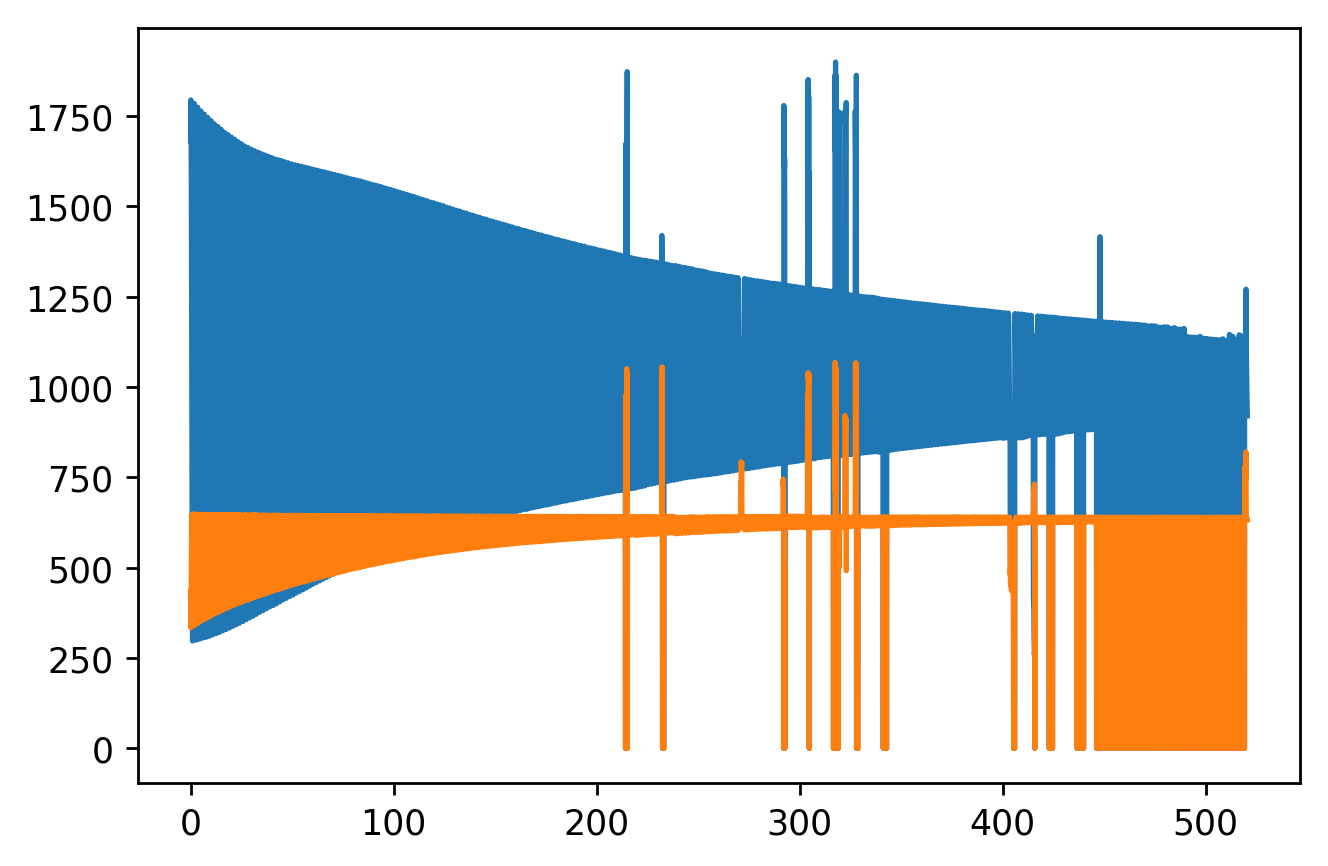

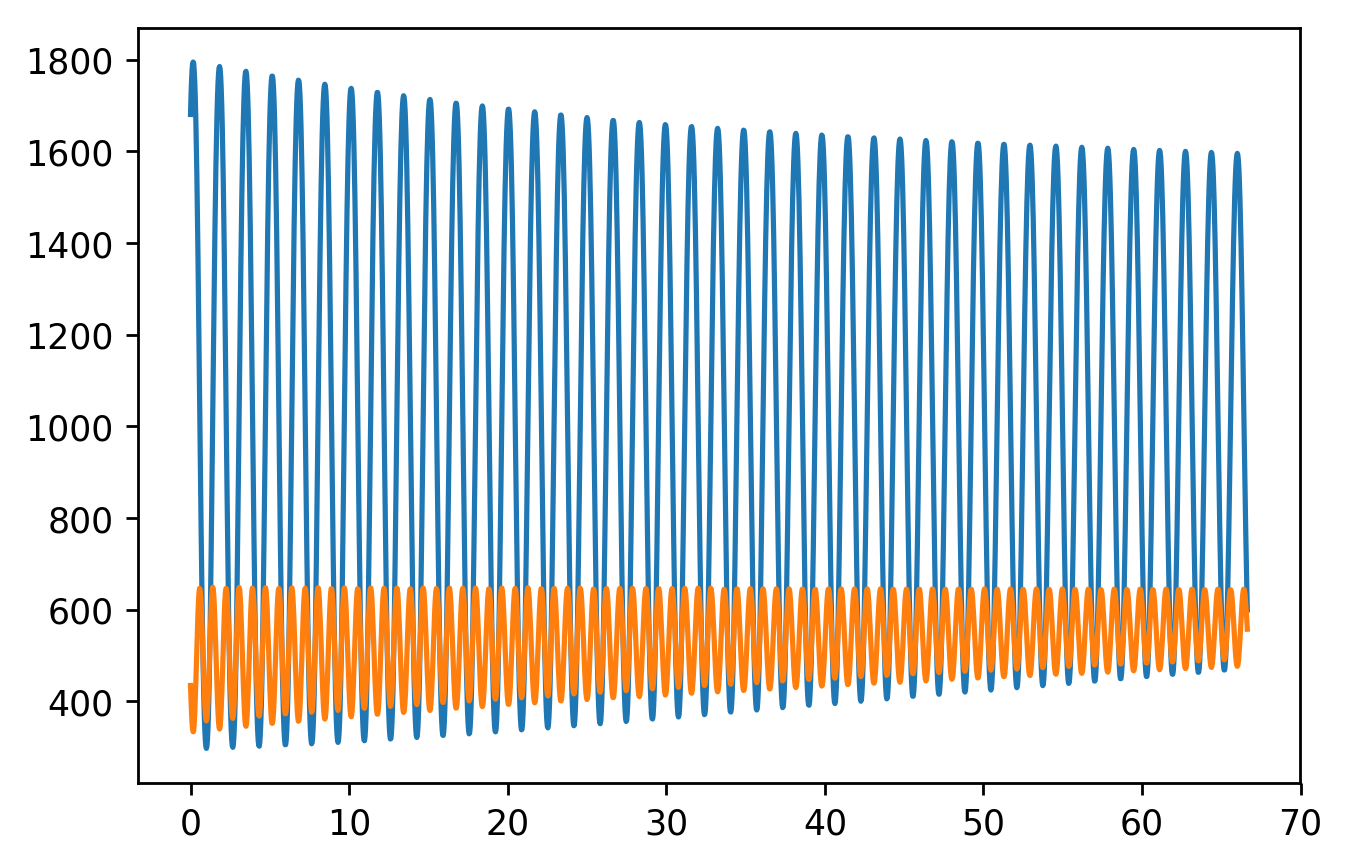

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)

fps=30  #we could, perhaps, read this in from the movie and save it, but it is too much work for too little gain

x=np.load('xposLong.npy')
y=np.load('yposLong.npy')

t=np.linspace(0,len(x)/fps,len(x))
plt.figure()
plt.plot(t,x)
plt.plot(t,y)
plt.figure()
plt.plot(t[:2000],x[:2000])
plt.plot(t[:2000],y[:2000])

What features do we see?  What do they tell us?
1.
2.
3.
4.
5.
6.
7.


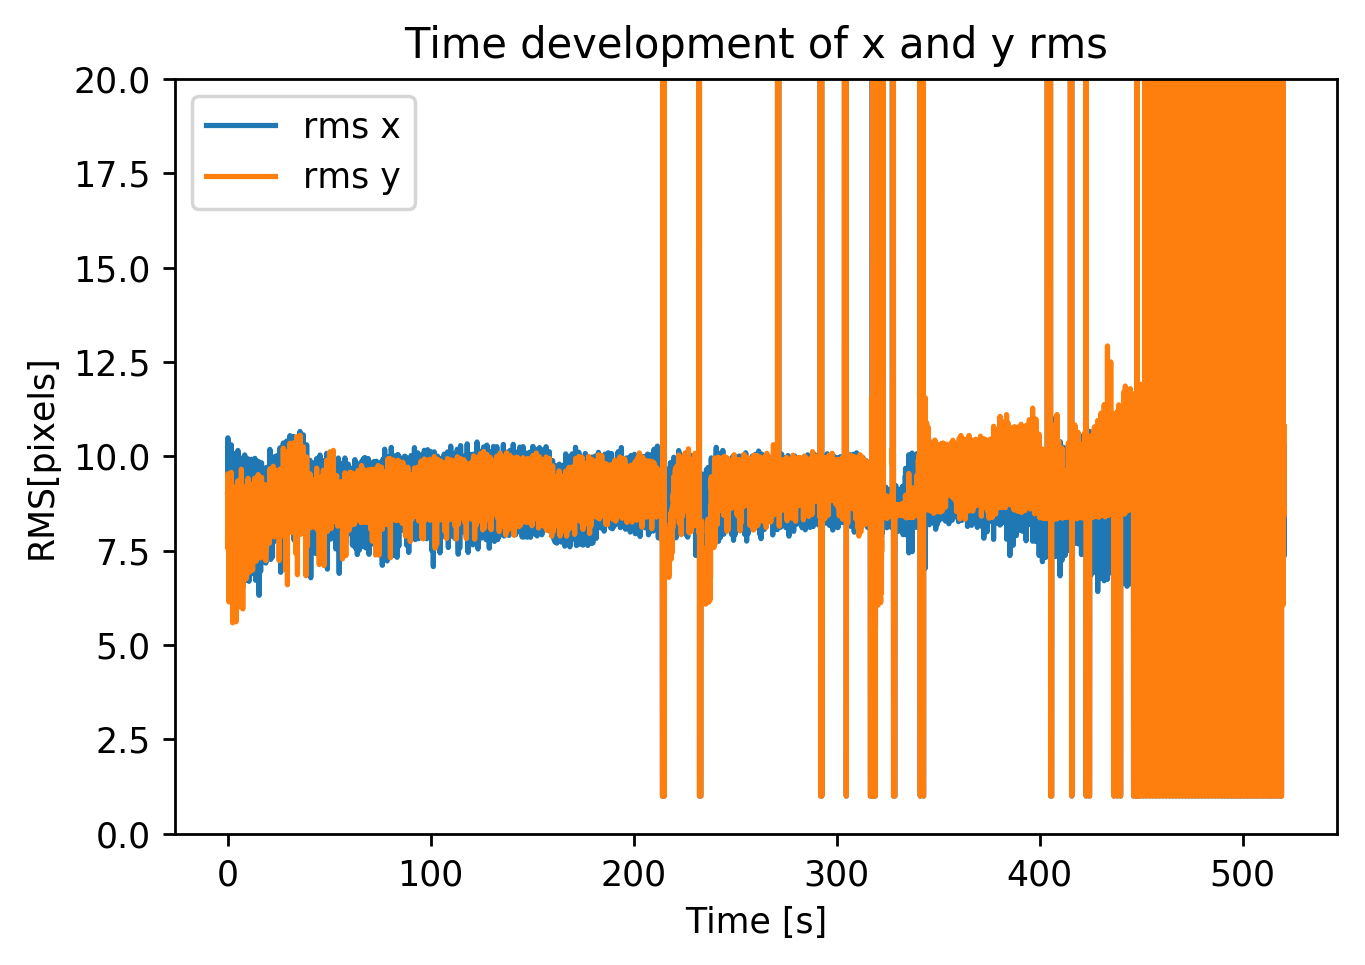

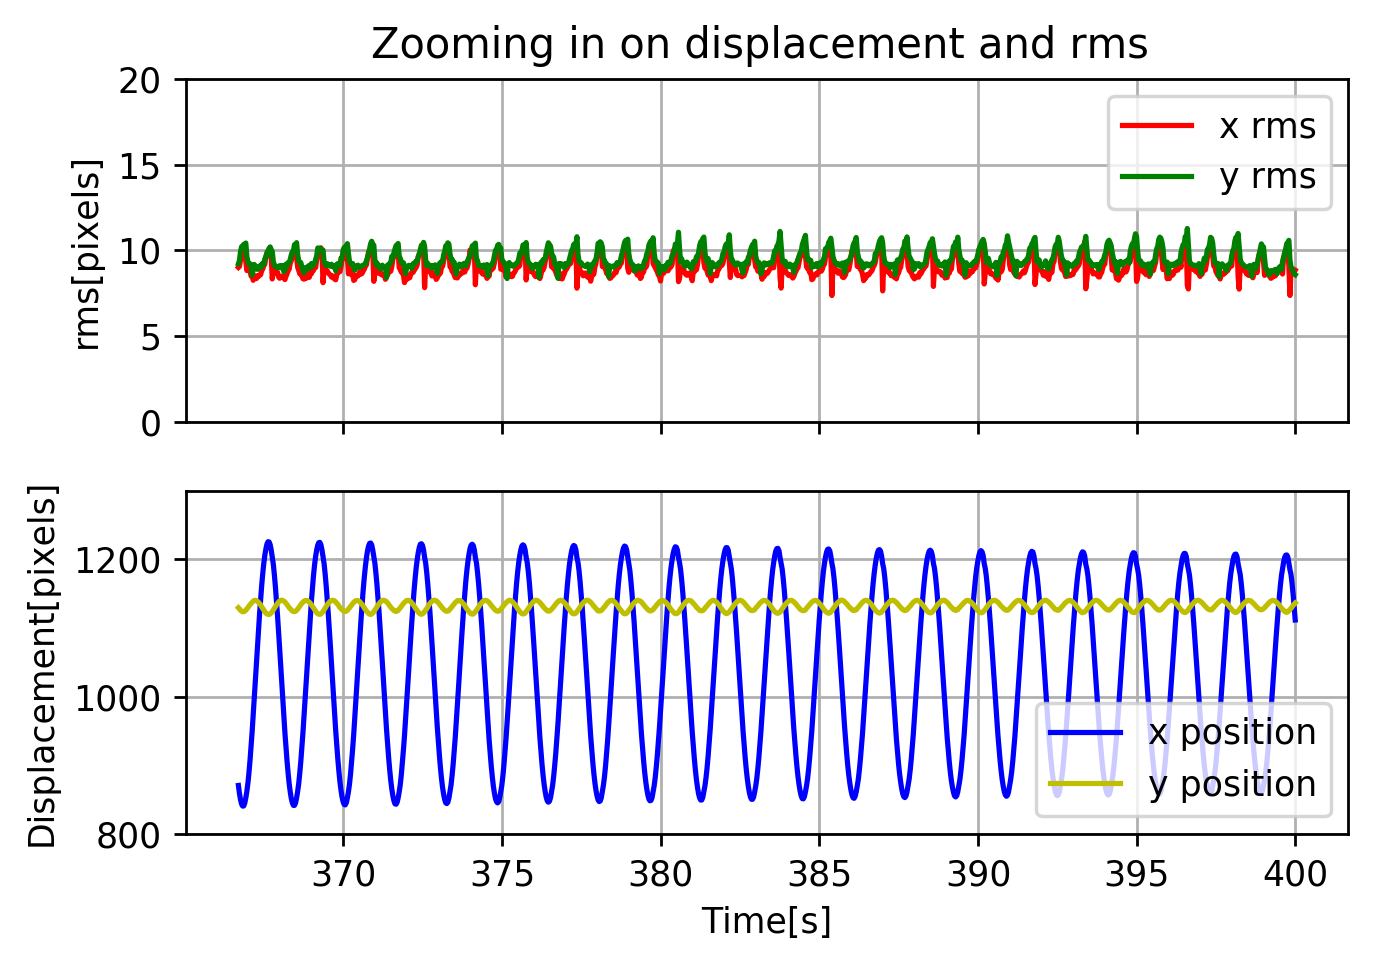

In [2]:
dx=np.load('dx.npy')
dy=np.load('dy.npy')
plt.figure()
axes=plt.gca()
axes.set_ylim(0,20)
plt.plot(t,dx,label='rms x')
plt.plot(t,dy,label='rms y')
plt.title('Time development of x and y rms')
plt.xlabel('Time [s]')
plt.ylabel('RMS[pixels]')
plt.legend()


m=11000
n=12000
f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Zooming in on displacement and rms ')
axarr[0].set_ylabel('rms[pixels]')
axarr[0].set_ylim(0,20)
axarr[0].plot(t[m:n],dx[m:n],'r',label='x rms')
axarr[0].plot(t[m:n],dy[m:n],'g',label='y rms')
axarr[0].legend()
axarr[0].grid()
axarr[1].set_xlabel('Time[s]')
axarr[1].set_ylabel('Displacement[pixels]')
axarr[1].plot(t[m:n],x[m:n], 'b',label='x position');
axarr[1].plot(t[m:n],500+y[m:n], 'y',label='y position');
axarr[1].set_ylim(800,1300)
axarr[1].grid()
axarr[1].legend()


# Fitting a function to data

We now want to calibrate our data- in particular we want to find $(x_0,y_0),$ the pivot point.  We can then calculate $\theta=\tan^{-1}\frac{x-x_0}{y-y_0}$.  We can do reasonably well finding $x_0$ by looking at the data relatively late in the data set, where the pendulum amplitude is low.  We know that the oscillation must be symmetric in $x$.  To start tinkering, let's just print out the data from 370-372 seconds:

In [3]:
t1=370*30
t2=372*30
ar=np.array([np.arange(t1,t2),t[t1:t2],x[t1:t2],y[t1:t2]]).transpose()
print(ar)

[[ 11100.            370.02369213    842.65222623    624.31648616]
 [ 11101.            370.0570276     842.15166461    623.95437731]
 [ 11102.            370.09036307    845.20505992    624.30492676]
 [ 11103.            370.12369853    852.4226361     625.39255014]
 [ 11104.            370.157034      861.32127955    627.49791377]
 [ 11105.            370.19036947    872.31486146    629.29219144]
 [ 11106.            370.22370494    887.19663648    631.36481242]
 [ 11107.            370.2570404     904.66801075    633.40591398]
 [ 11108.            370.29037587    923.9750983     635.49803408]
 [ 11109.            370.32371134    944.98725212    637.31586402]
 [ 11110.            370.35704681    968.79854015    638.65693431]
 [ 11111.            370.39038228    992.42328767    639.63424658]
 [ 11112.            370.42371774   1017.12307692    639.8027972 ]
 [ 11113.            370.45705321   1042.29766804    639.89300412]
 [ 11114.            370.49038868   1067.08027211    639.10068

We see the minimum is at 11101: $x=842.2$ and the maximum is at 11125: $x=1223.7$.  We do pretty well- probably with an accuracy of about .1 pixel- just taking the average:

In [4]:
x0=(x[11101]+x[11125])/2
print('x0=',x0)

x0= 1032.9263927


But there are somethings that don't feel completely right about this procedure.  What is that?  

We are now going to look at fitting a function to data.  What we do is use the metric $\chi^2$, which measures the mean difference between data and a model by summing the squared normalized 'residuals'.  (Although we need to be careful with the word 'residual'.  It tends to be used in different ways, with different units and different normalizations. )  We define
\begin{equation}\chi^2=\sum_{i=0}^{i=N}\left(\frac{f(x_i)-y_i}{\sigma_i}\right)^2\end{equation}
where $x_i,y_i,\sigma_i$ are the independent variable, dependent variable and uncertainty associated with each data point.  If our uncertainties are correct, and the fluctuations are statistical, we expect that $\chi^2=N-1$-- that is the number of "degrees of freedom".  

Let's take our function looks like a cosine curve:
\begin{equation}x(t)=A\cos(\omega*t-\theta_0)+x_0$

We make two functions- on that calculates $x(t)$ and one that calculates $\chi^2$.


In [5]:
def xFunction(t,A,x0,omega,theta0):
    #if one of the parameters is a vector, it returns a 2d array with the rows corresponding to a vector of one of A,X0,omega,theta0 and 
    #columns to different times
    #if parameters are scalers it returns a 1d vector
    tt=t.reshape(1,-1)  # we make t into a row matrix and one of the other parameters into a column matrix.
    if not np.isscalar(A):
        return A.reshape(-1,1)*np.cos(omega*tt-theta0)+x0
    if not np.isscalar(x0):
        return A*np.cos(omega*tt-theta0)+x0.reshape(-1,1)
    if not np.isscalar(omega):
        return A*np.cos(omega.reshape(-1,1)*tt-theta0)+x0
    if(not np.isscalar(theta0)):
        return A*np.cos(omega*tt-theta0.reshape(-1,1))+x0
    return A*np.cos(omega*tt-theta0)+x0

def chisquare(func,t,x,sigma,A,x0,omega,theta0):
    '''Calculates chisquare.  t is the independent variable for the data, x are the data value, sigma are the uncertainties.  
    Those three arrays need to be the same length.  '''
    return np.sum(((func(t,A,x0,omega,theta0)-x)/sigma)**2,axis=1).reshape(-1)

To see how the function behaves, let's plot it from t[11500:12000], and we will tweak the parameters to make it look like the data (which we overlay).


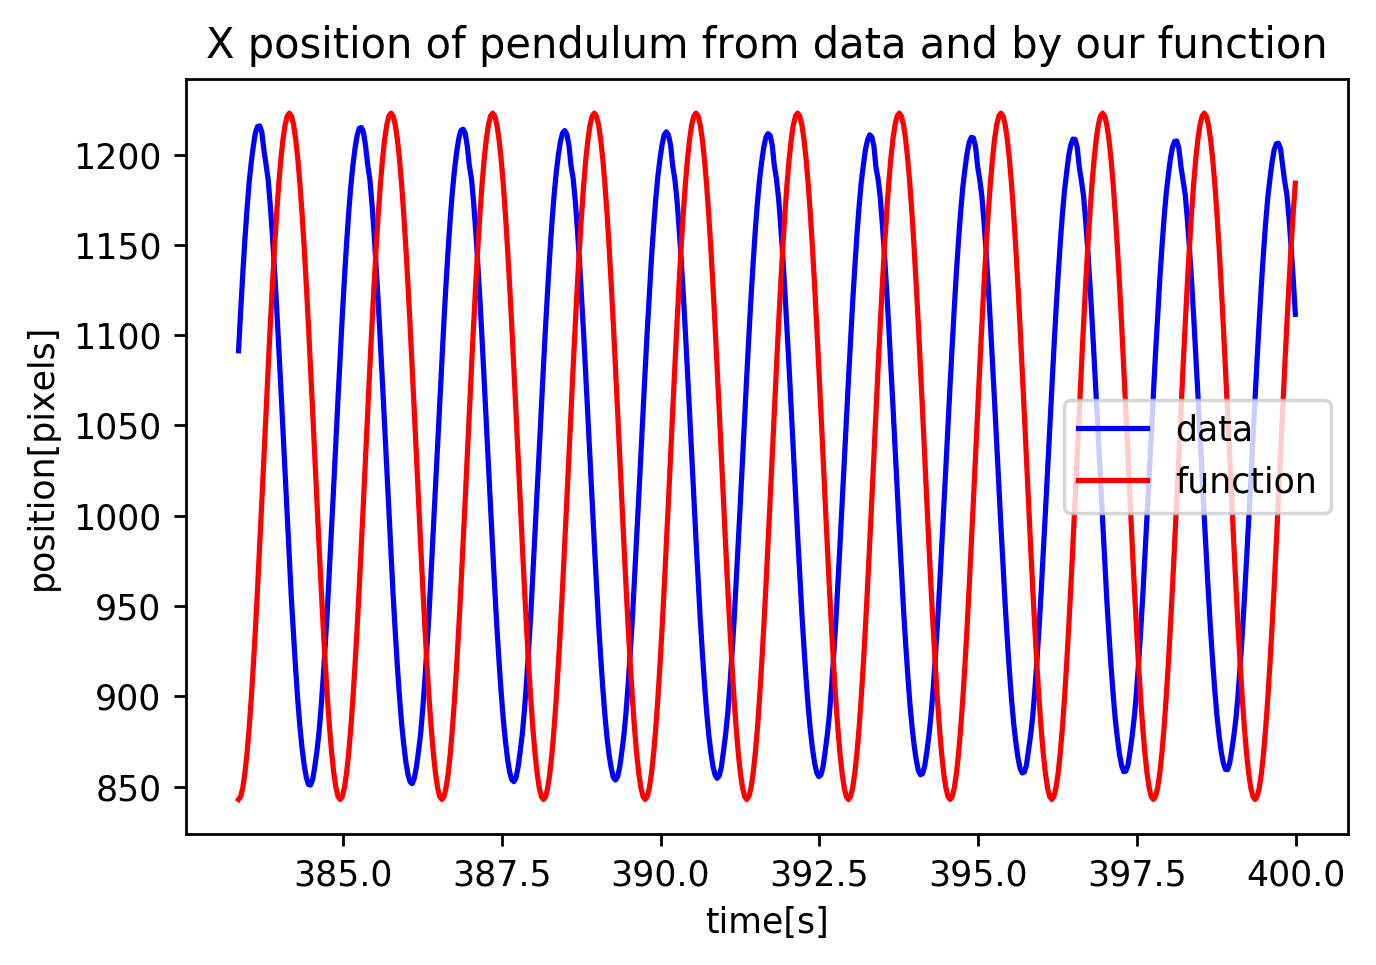

In [6]:
m=11500
n=12000

omega=2*np.pi/48.0*30  #using 24 bins between minimum and maximum
theta0=omega*t[m]-np.pi  #so that bin m is at a minimum

xcalc=xFunction(t[m:n],190,x0,omega,theta0).reshape(-1)

plt.figure()
plt.title('X position of pendulum from data and by our function')
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()

We need to shift the function to the left- so we want to decrease theta0 by roughly $\pi/2$

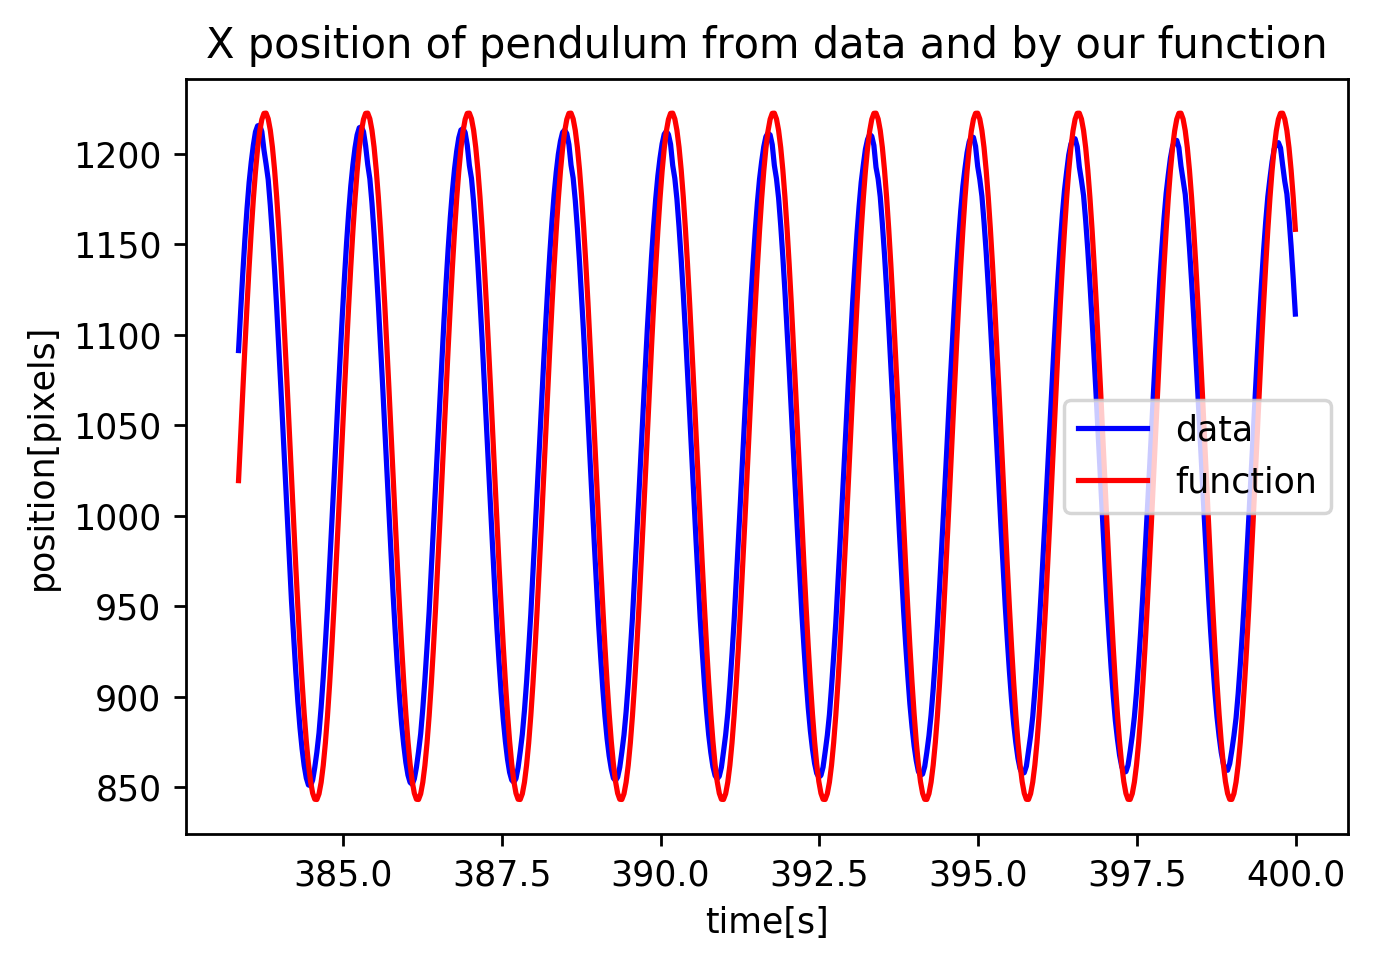

In [7]:
theta0=theta0-1.5
xcalc=xFunction(t[m:n],190,x0,omega,theta0).reshape(-1)

plt.figure()
plt.title('X position of pendulum from data and by our function')
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()

Now let's calculate $\chi^2$.  We will do a "minimization by hand", where we plot chisquare versus each parameter in turn, and pick the parameters that correspond to the minimum.

Let's start by varying the amplitude

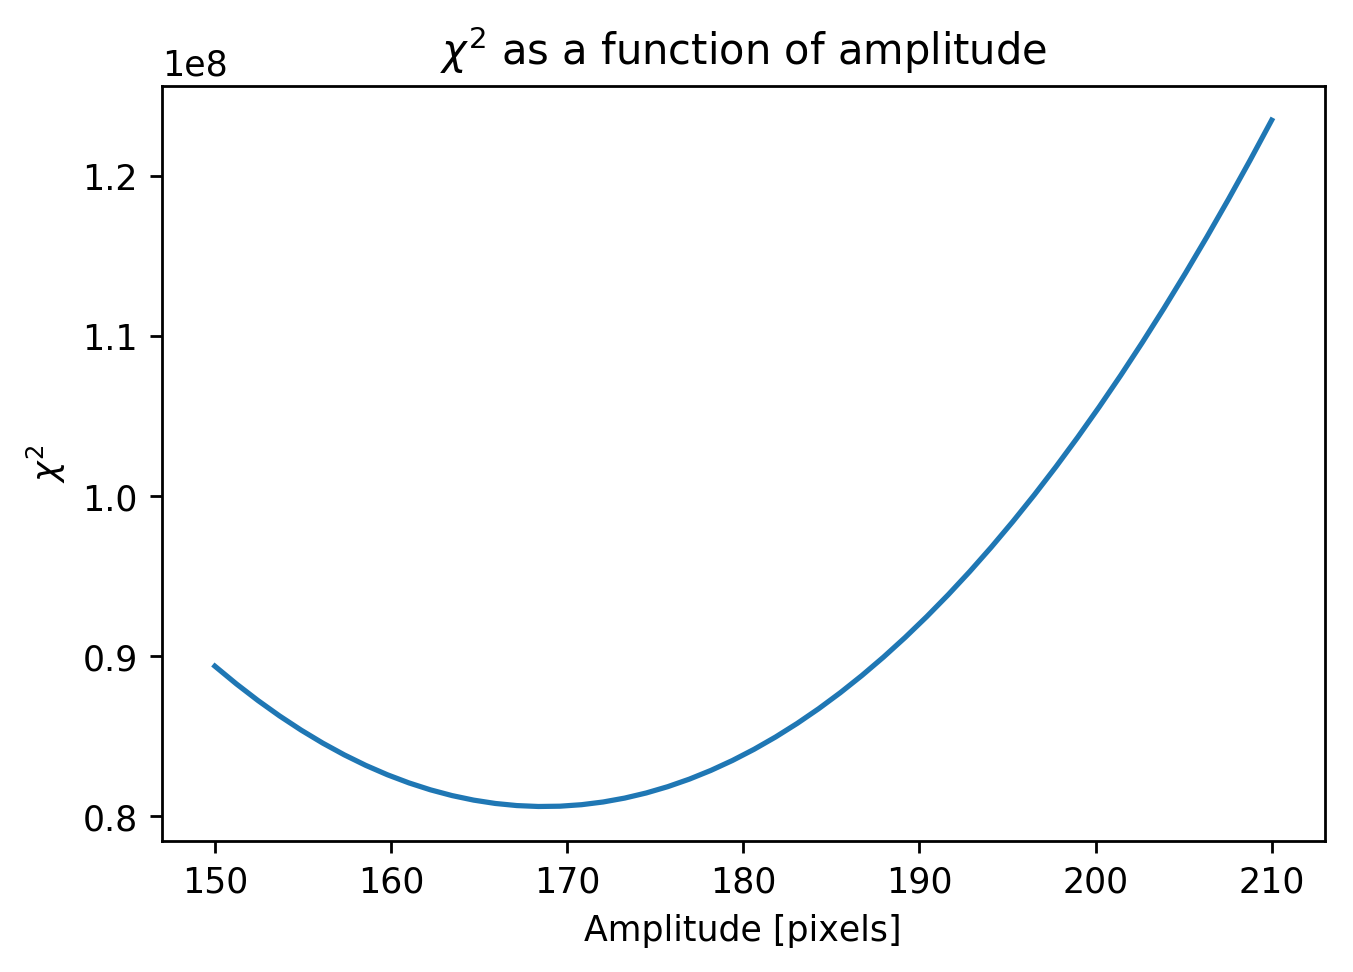

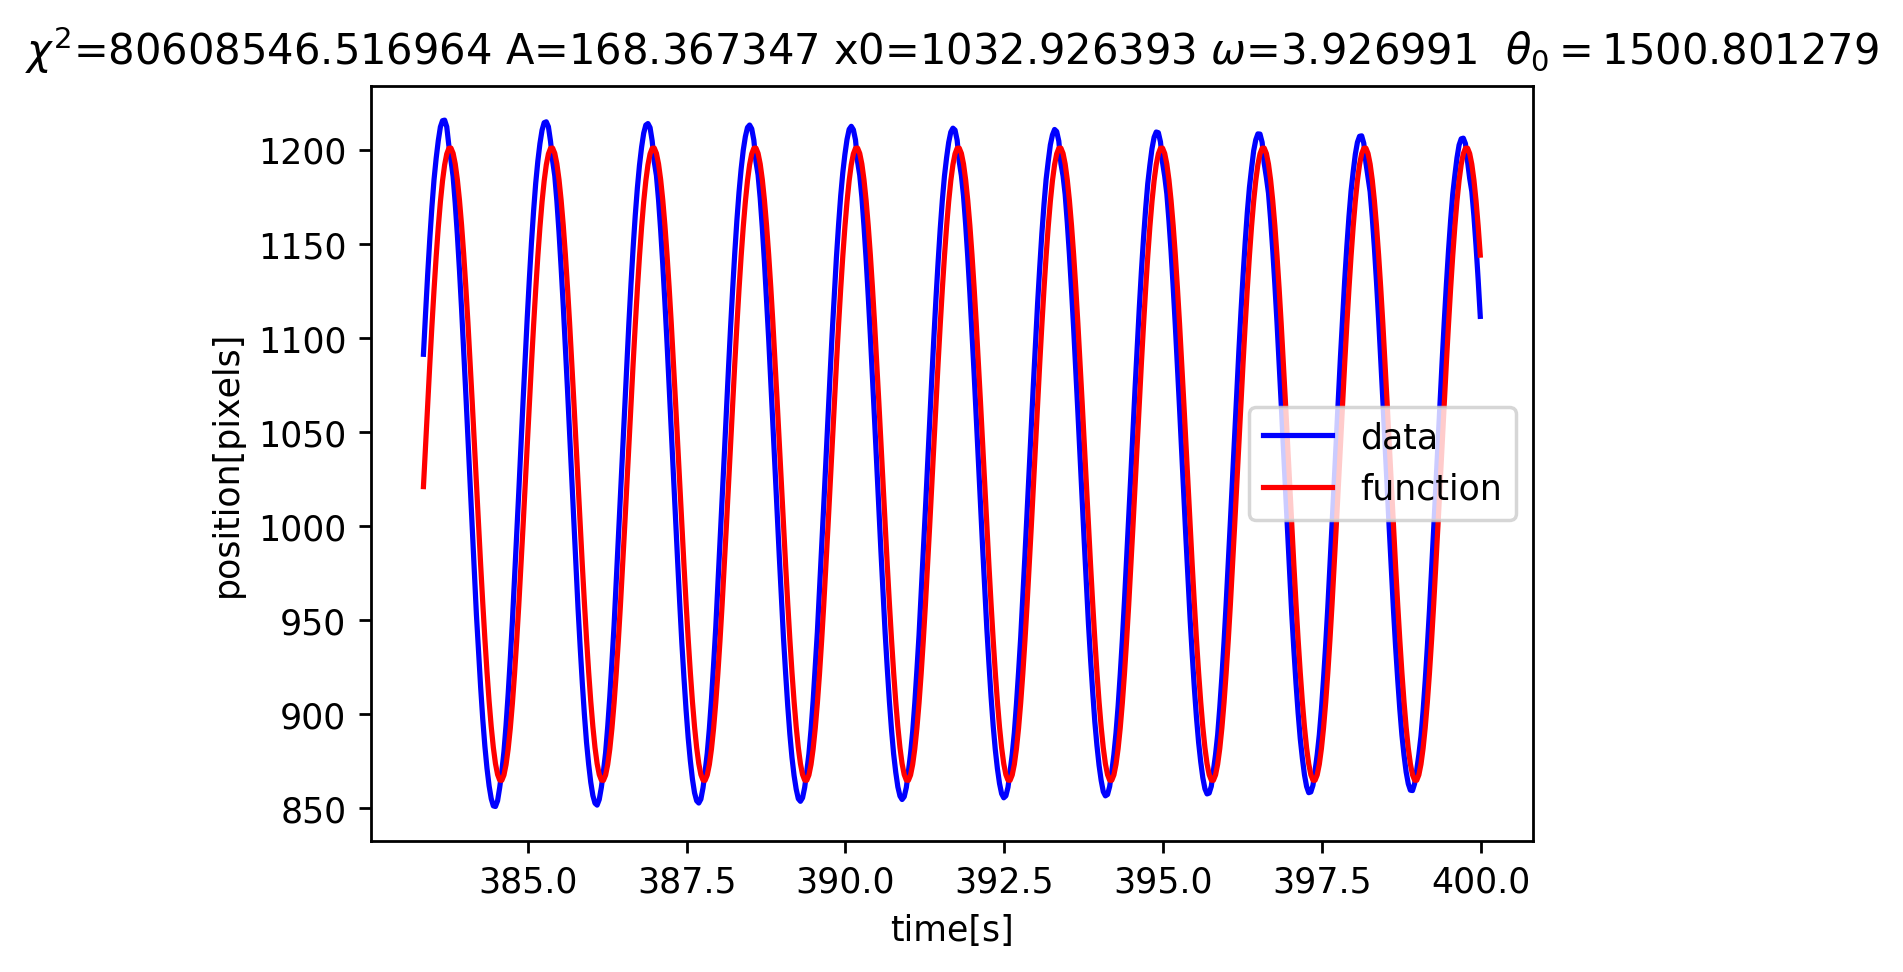

In [8]:
uncertainties=np.ones(n-m)*0.1  #  0.1 pixel seems reasonable, but perhaps a little small. We may come back and address this
amplitude=np.linspace(150,210,50)
chisq=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amplitude,x0,omega,theta0)

amp0=amplitude[np.argmin(chisq)]
bestChiSquare=np.amin(chisq)

plt.figure()
plt.title(r'$\chi^2$ as a function of amplitude')
plt.xlabel('Amplitude [pixels]')
plt.ylabel(r'$\chi^2$')
plt.plot(amplitude,chisq)

xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
title=r'$\chi^2$=%f A=%f x0=%f $\omega$=%f  $\theta_0=%f$' % (bestChiSquare,amp0,x0,omega,theta0)
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()


Now do theta0, since it seems most off

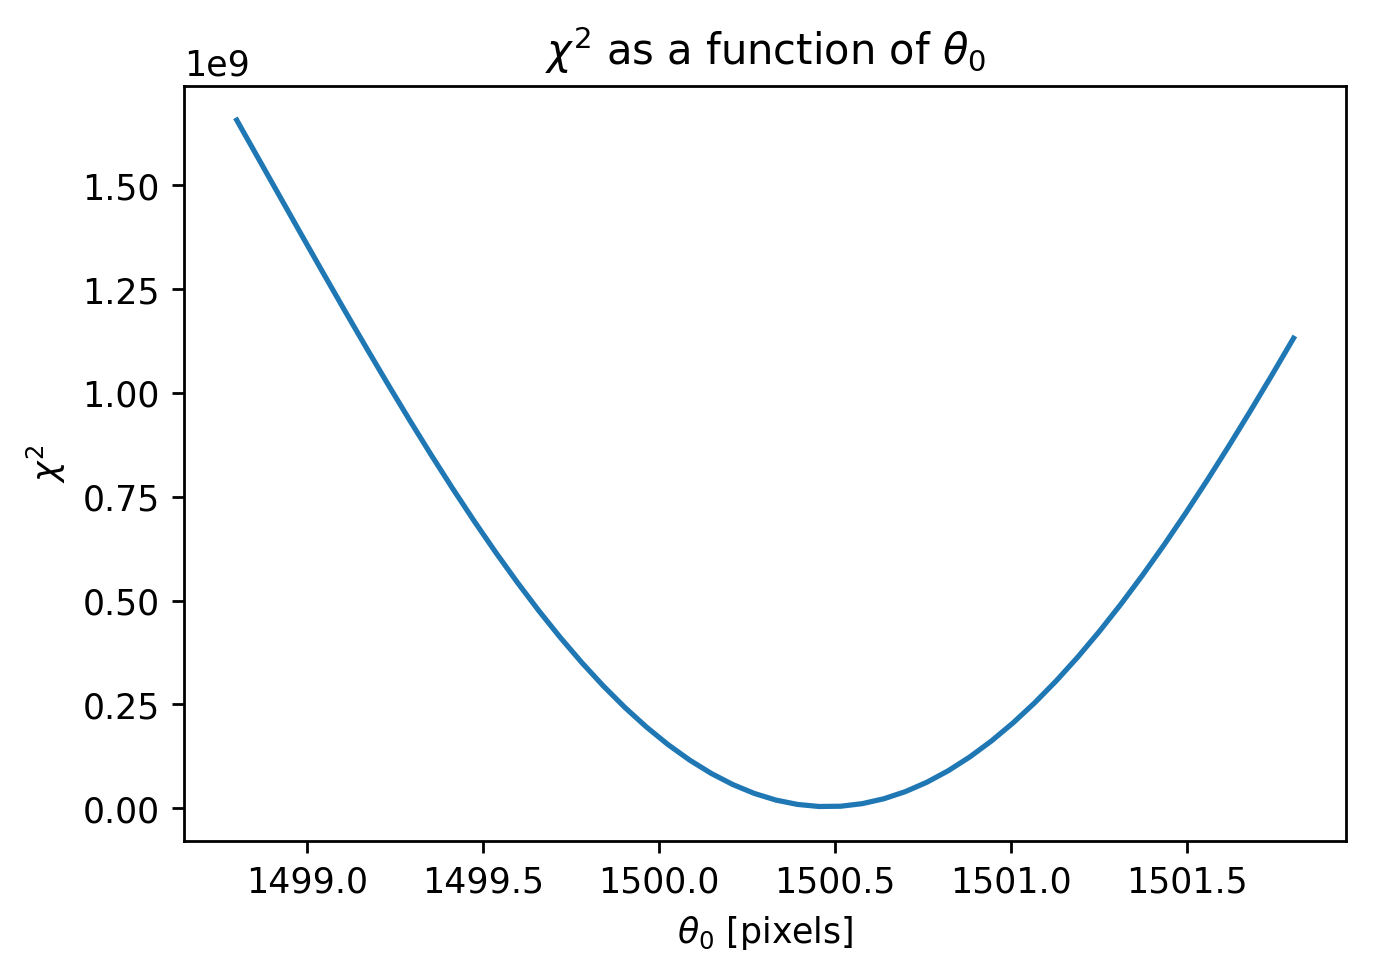

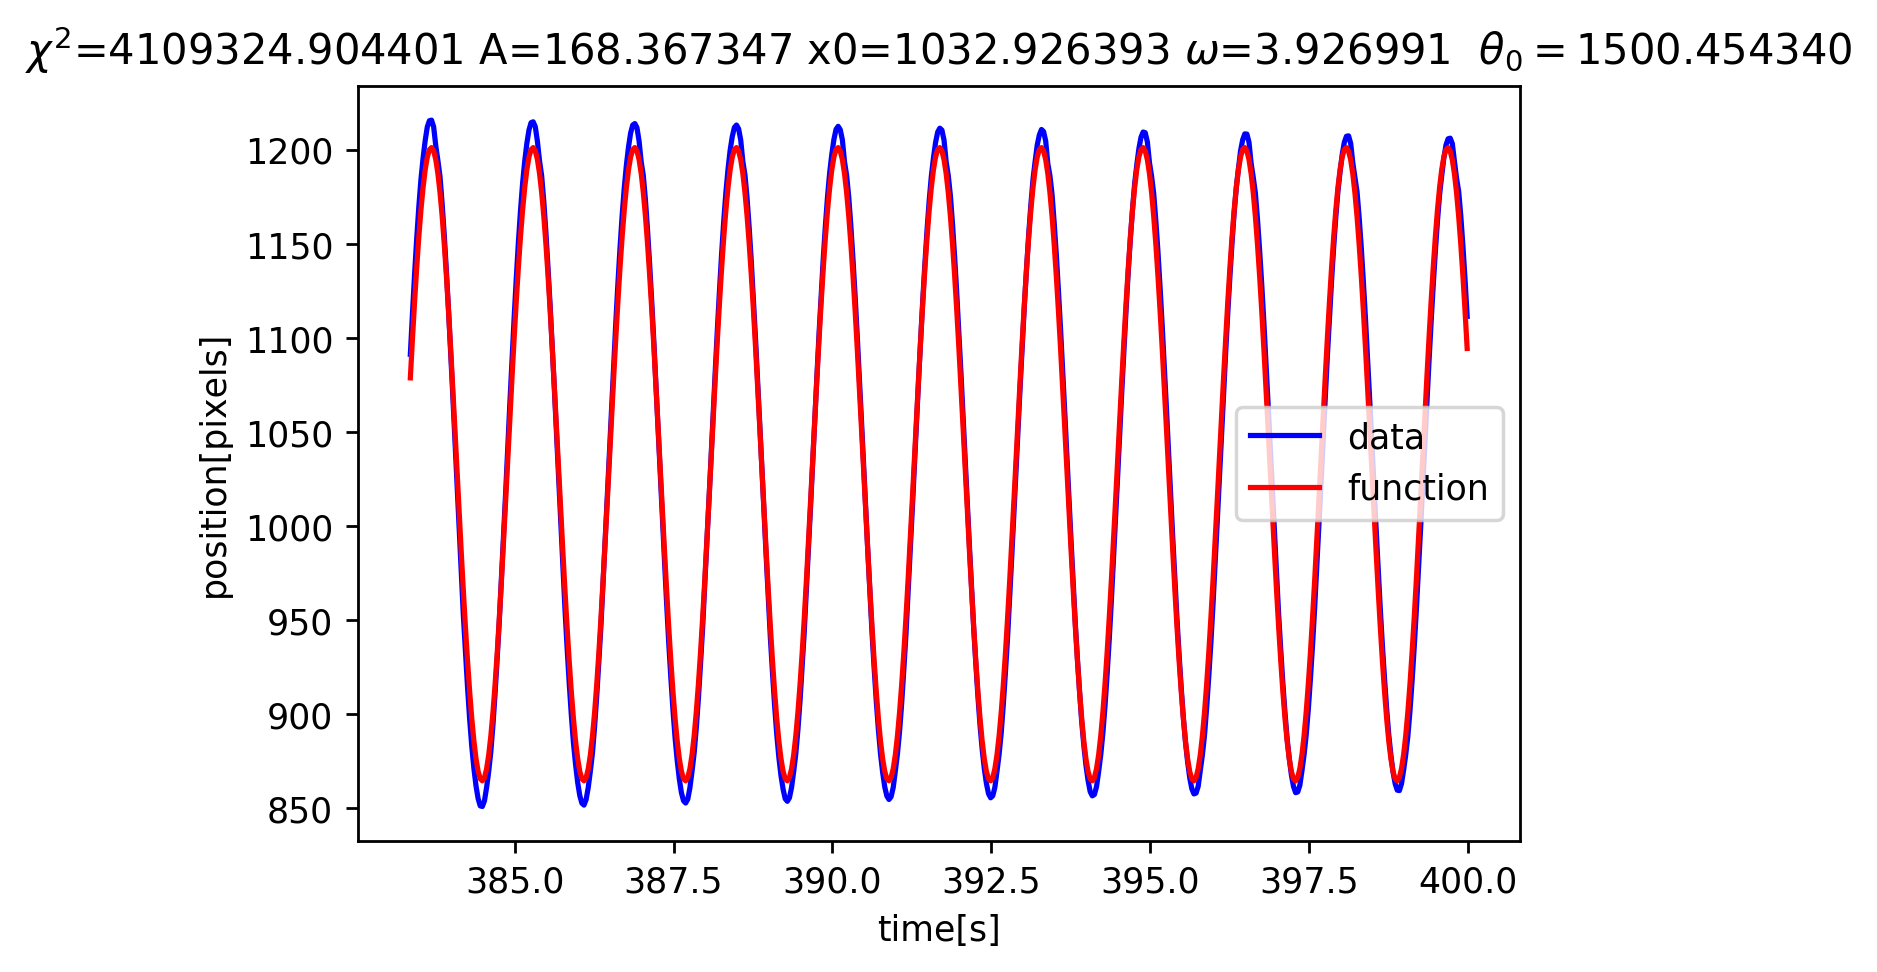

In [9]:
theta0array=np.linspace(theta0-2,theta0+1,50)
chisq=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amp0,x0,omega,theta0array)

theta0=theta0array[np.argmin(chisq)]
bestChiSquare=np.amin(chisq)

plt.figure()
plt.title(r'$\chi^2$ as a function of $\theta_0$')
plt.xlabel(r'$\theta_0$ [pixels]')
plt.ylabel(r'$\chi^2$')
plt.plot(theta0array,chisq)

xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
title=r'$\chi^2$=%f A=%f x0=%f $\omega$=%f  $\theta_0=%f$' % (bestChiSquare,amp0,x0,omega,theta0)
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()


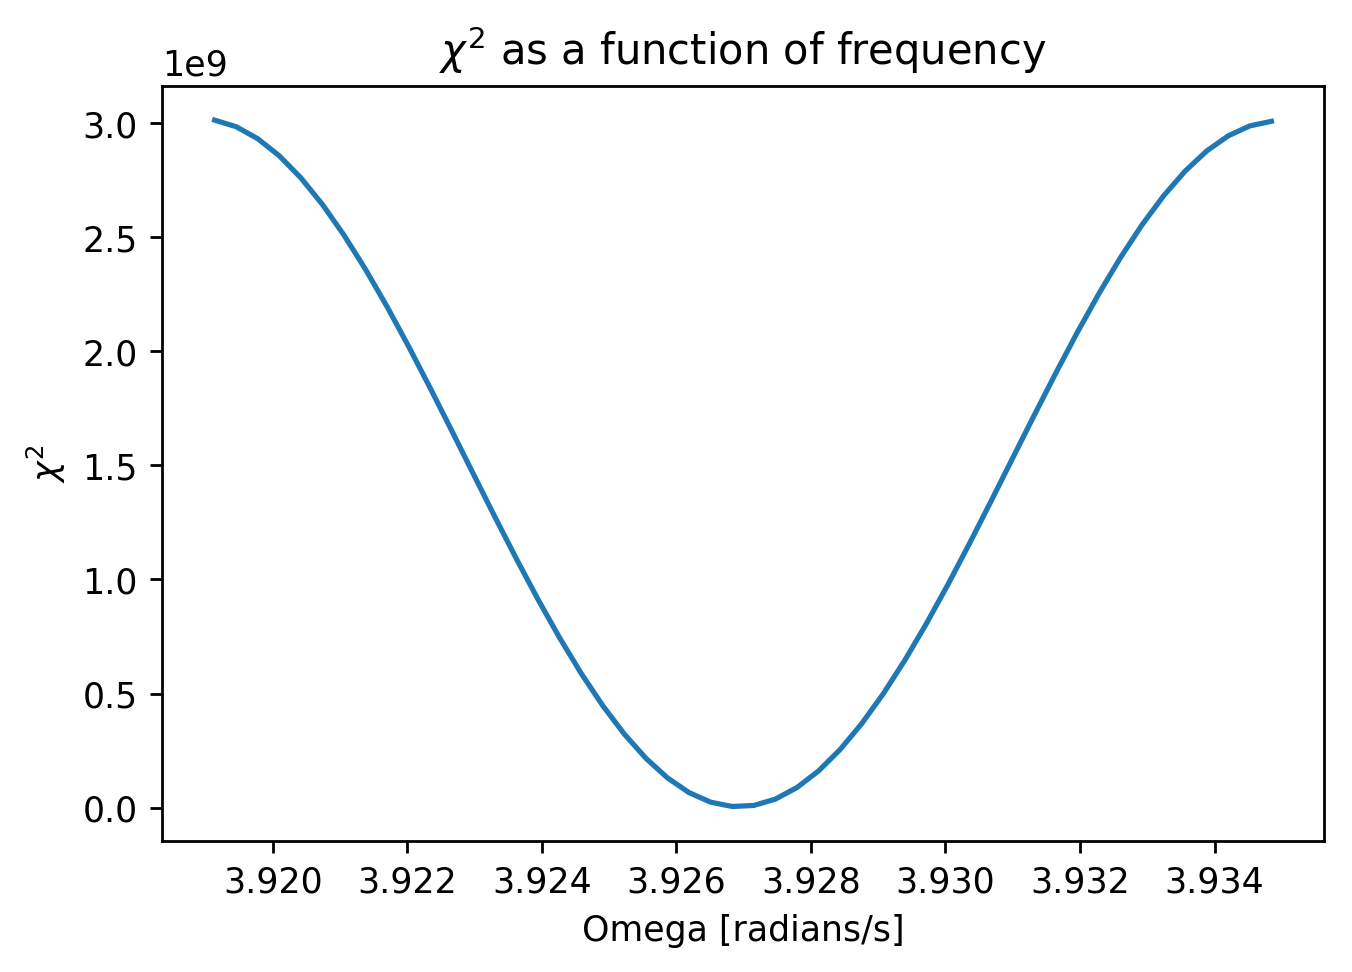

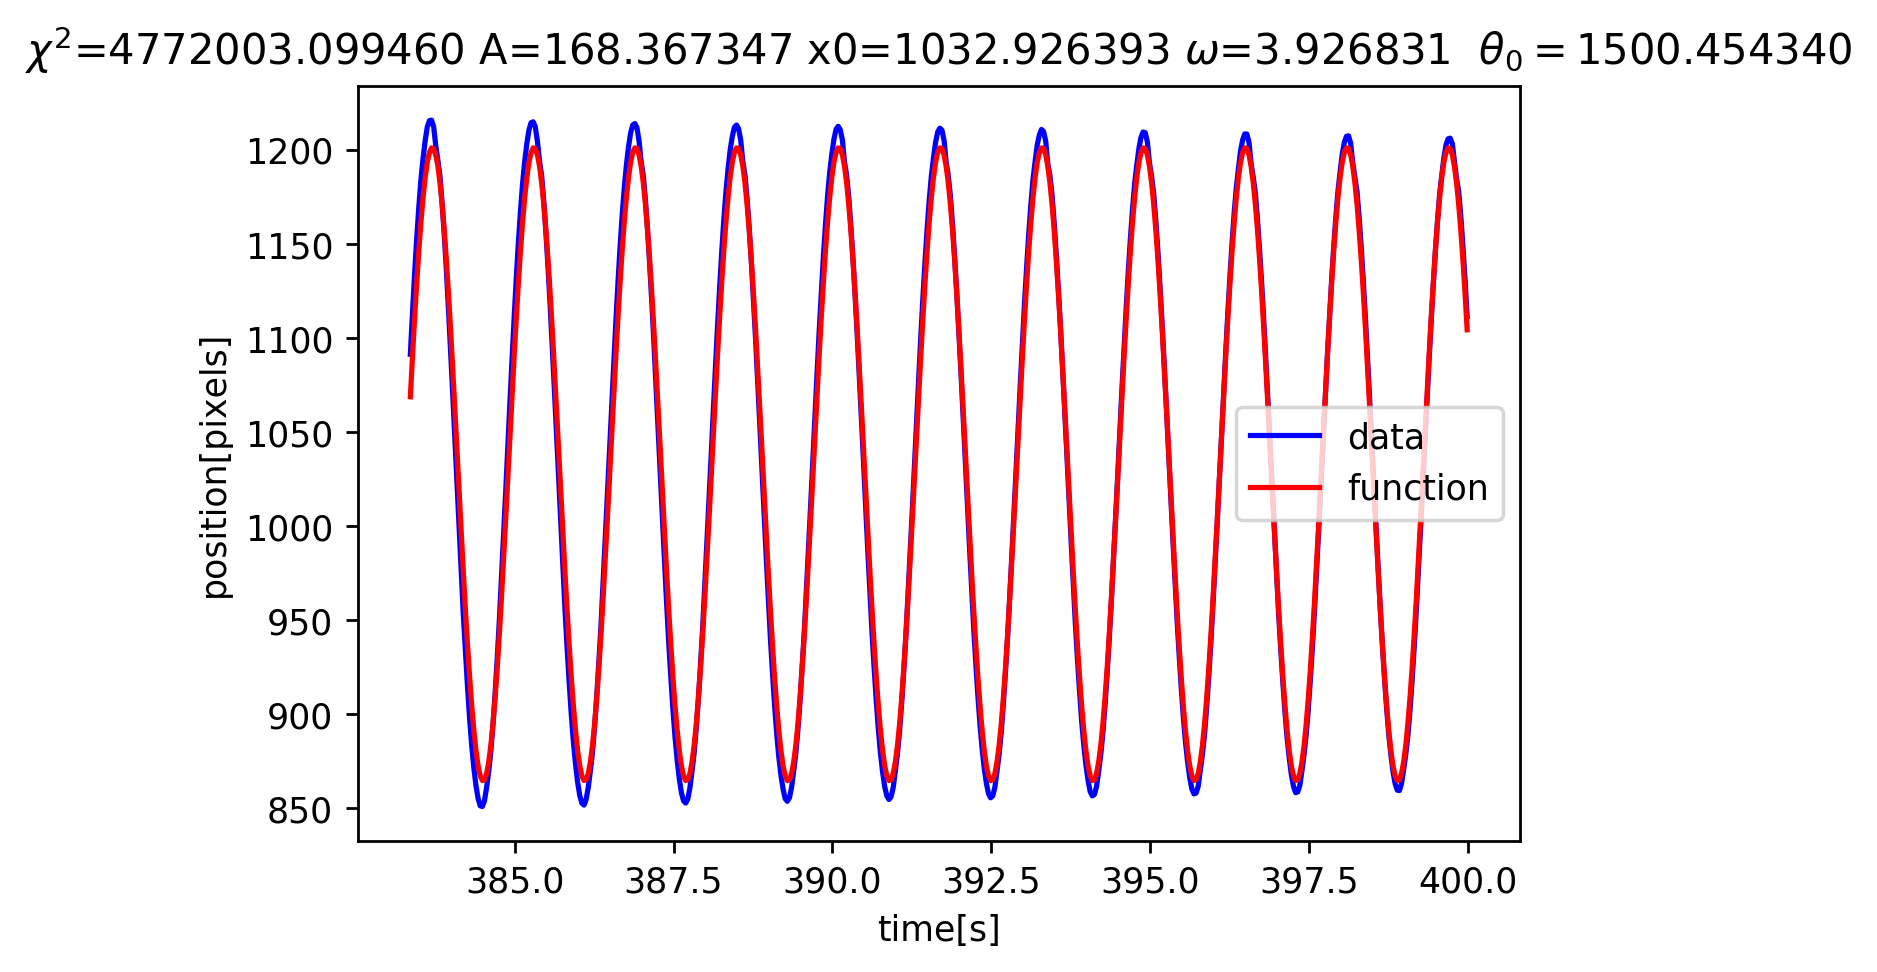

In [10]:
omegaarray=np.linspace(omega*0.998,omega*1.002,50)
chisq=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amp0,x0,omegaarray,theta0)

omega=omegaarray[np.argmin(chisq)]
bestChiSquare=np.amin(chisq)

plt.figure()
plt.title(r'$\chi^2$ as a function of frequency')
plt.xlabel('Omega [radians/s]')
plt.ylabel(r'$\chi^2$')
plt.plot(omegaarray,chisq)

xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
title=r'$\chi^2$=%f A=%f x0=%f $\omega$=%f  $\theta_0=%f$' % (bestChiSquare,amp0,x0,omega,theta0)
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()


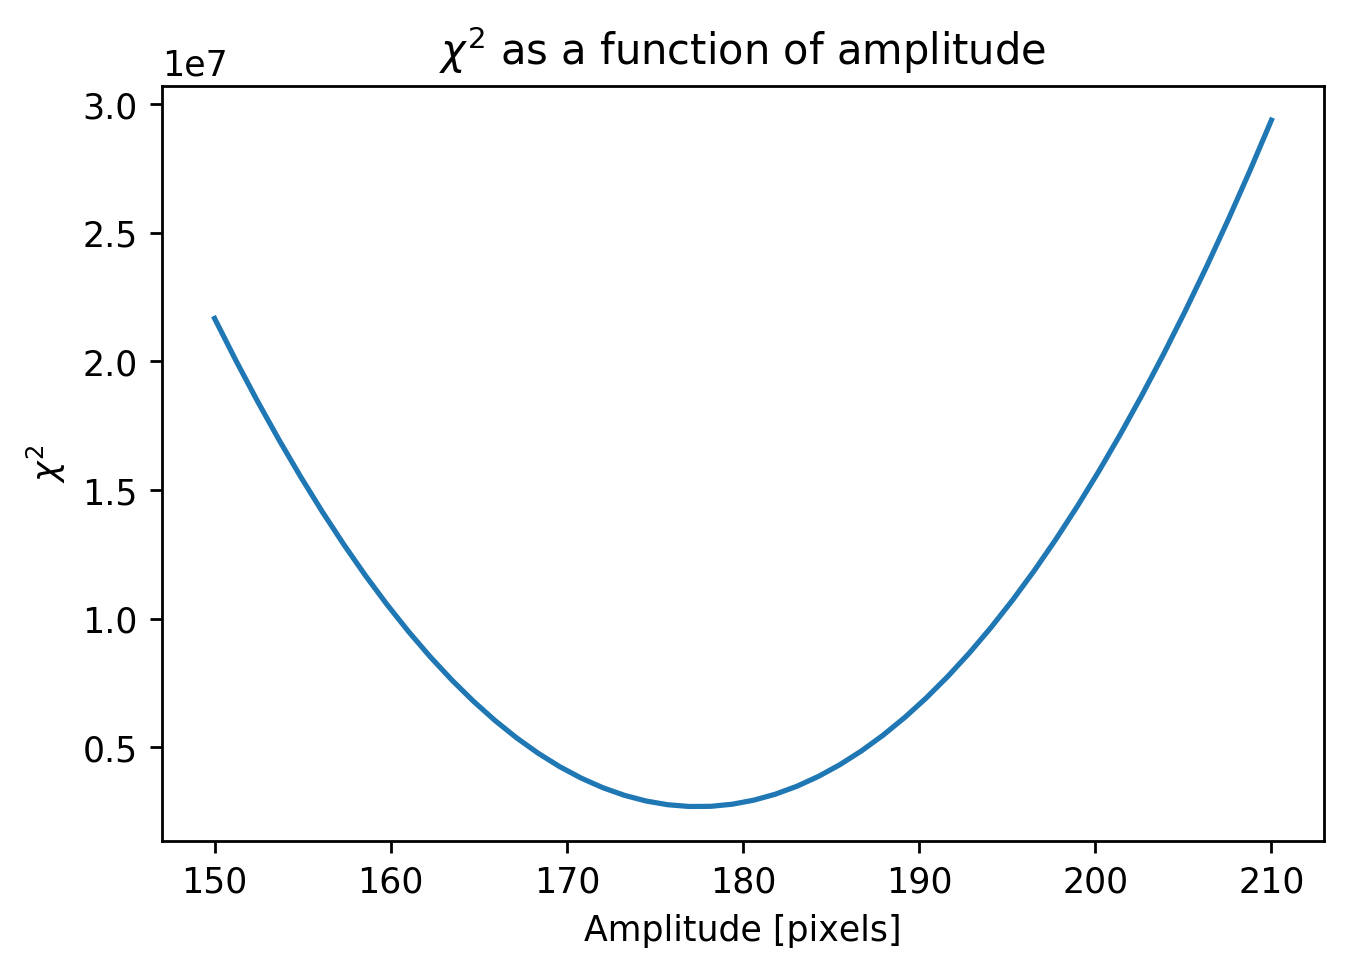

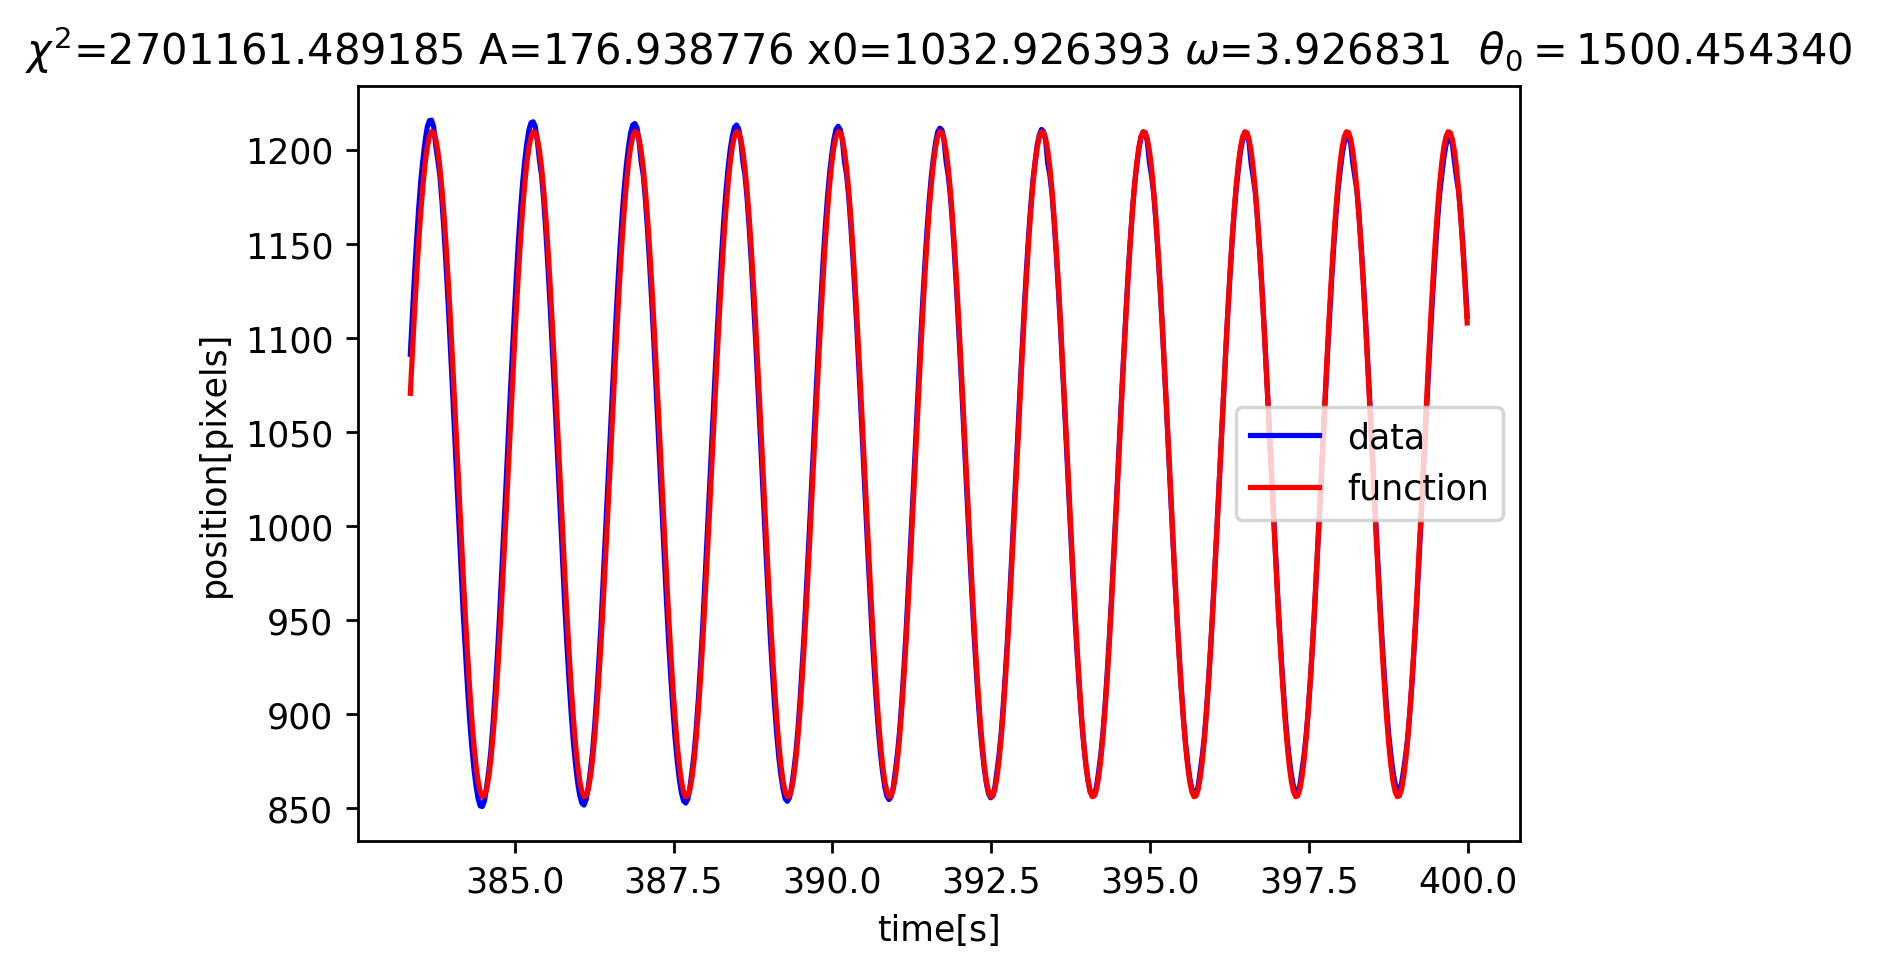

In [11]:
# Redo the amplitude, since it seems most off
amplitude=np.linspace(150,210,50)
chisq=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amplitude,x0,omega,theta0)

amp0=amplitude[np.argmin(chisq)]
bestChiSquare=np.amin(chisq)

plt.figure()
plt.title(r'$\chi^2$ as a function of amplitude')
plt.xlabel('Amplitude [pixels]')
plt.ylabel(r'$\chi^2$')
plt.plot(amplitude,chisq)

xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
title=r'$\chi^2$=%f A=%f x0=%f $\omega$=%f  $\theta_0=%f$' % (bestChiSquare,amp0,x0,omega,theta0)
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()


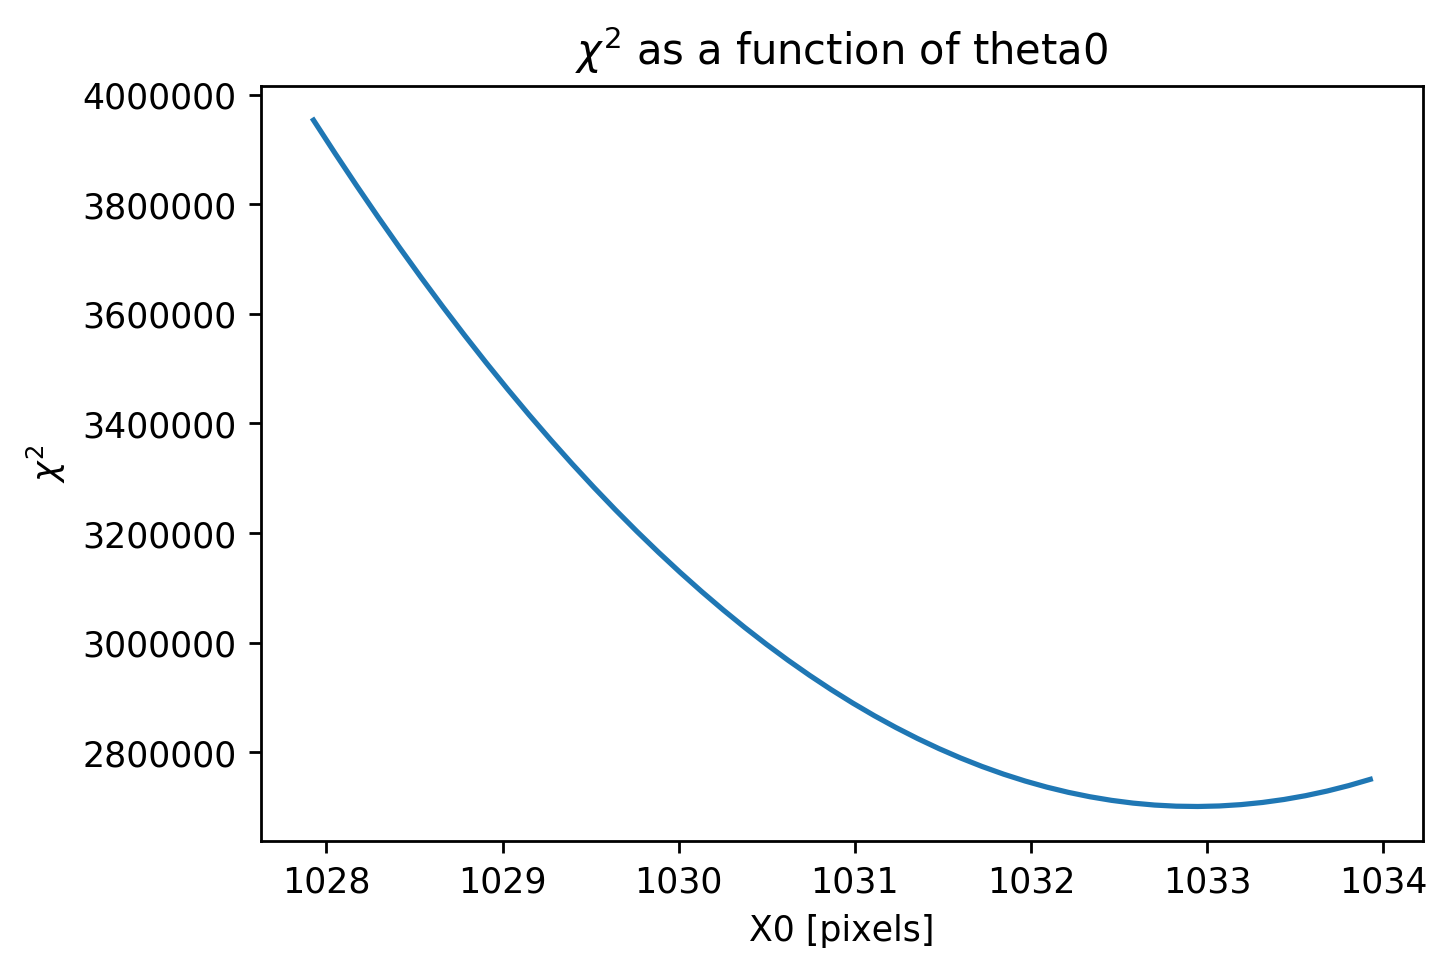

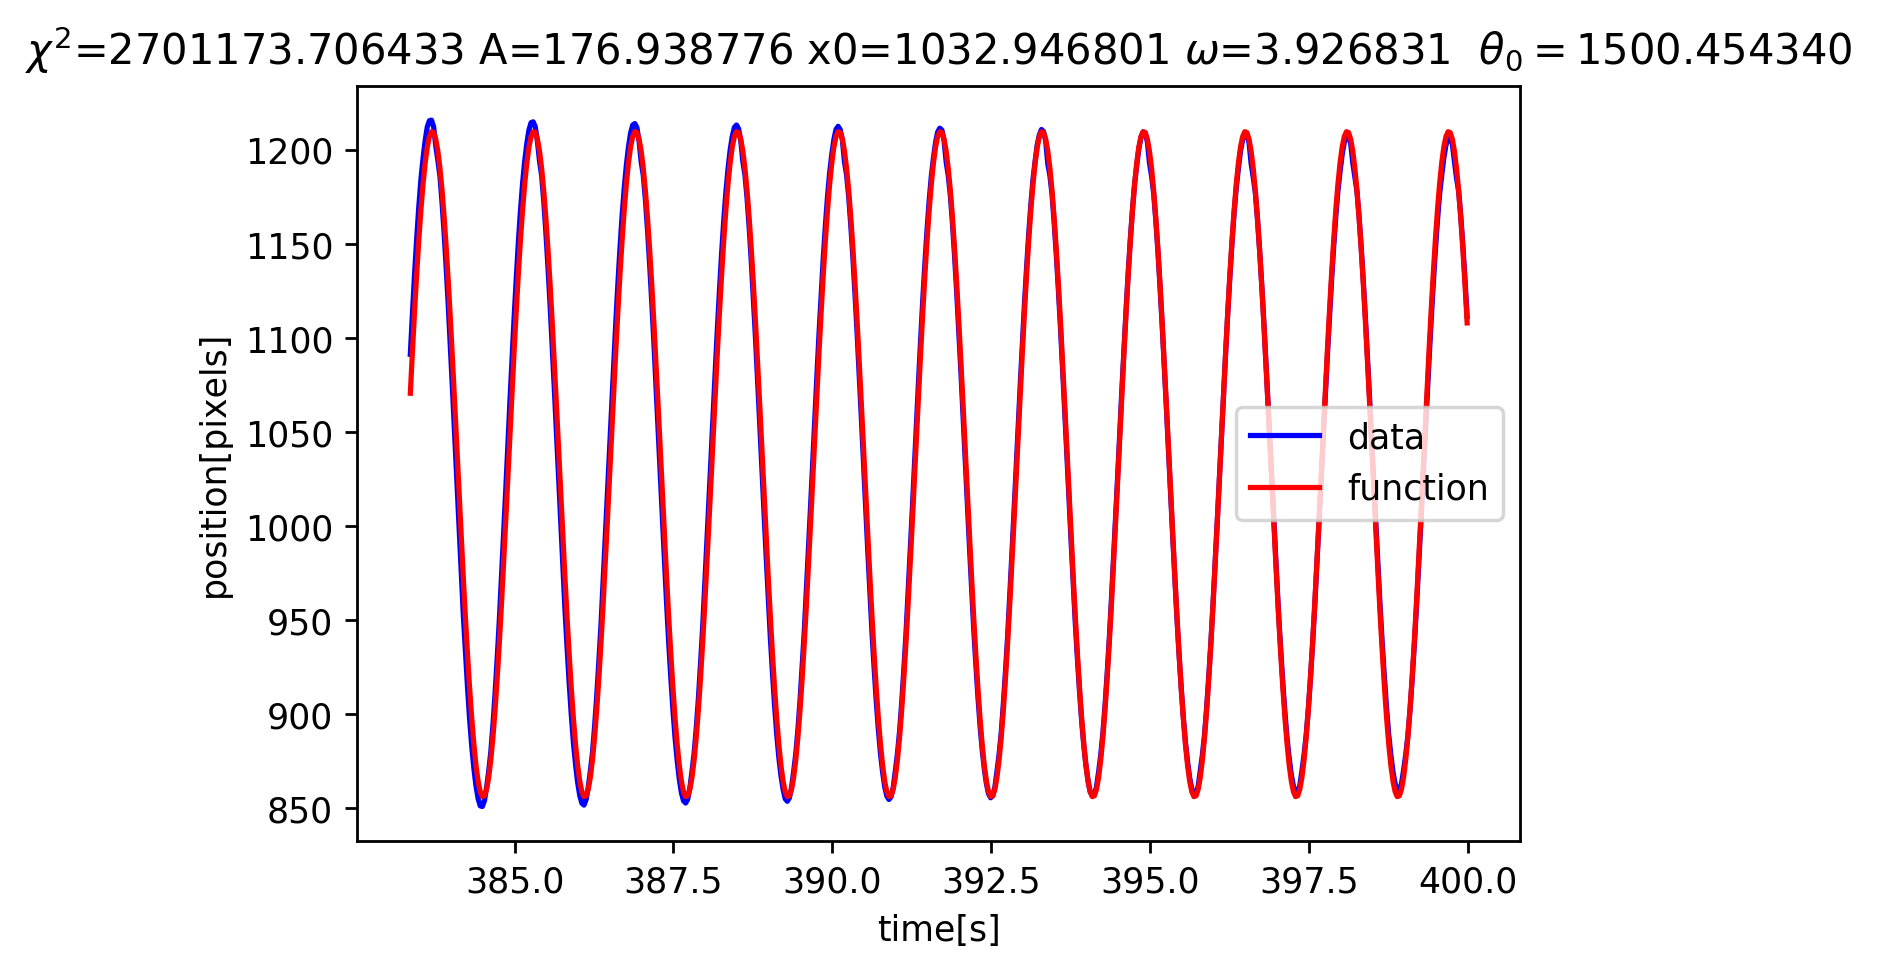

In [12]:
offset=np.linspace(x0-5,x0+1,50)
chisq=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amp0,offset,omega,theta0)

x0=offset[np.argmin(chisq)]
bestChiSquare=np.amin(chisq)

plt.figure()
plt.title(r'$\chi^2$ as a function of theta0')
plt.xlabel('X0 [pixels]')
plt.ylabel(r'$\chi^2$')
plt.plot(offset,chisq)

xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
title=r'$\chi^2$=%f A=%f x0=%f $\omega$=%f  $\theta_0=%f$' % (bestChiSquare,amp0,x0,omega,theta0)
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()


# Automated ways to do this: fitting functions

Read Numerical Recipes, Chapter 15.  It discusses linear least squares fitting, the chisquare distribution, and a number of other concepts that you will run into when modelling data.  We will focus on the section 15.5:
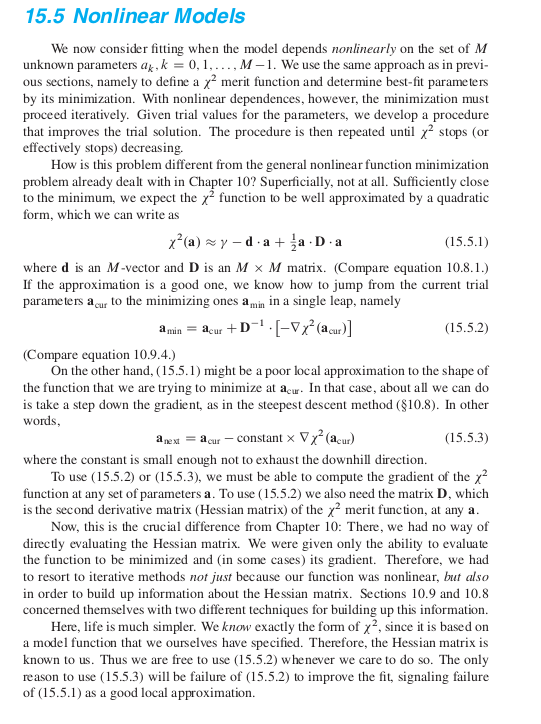
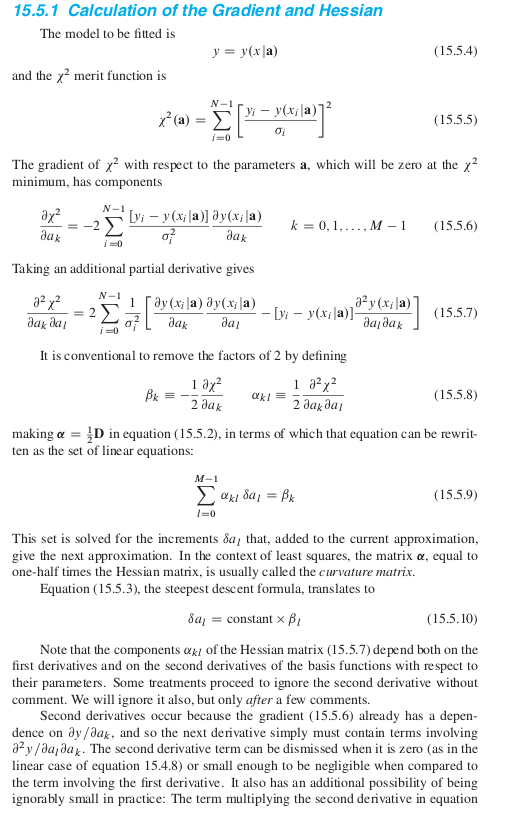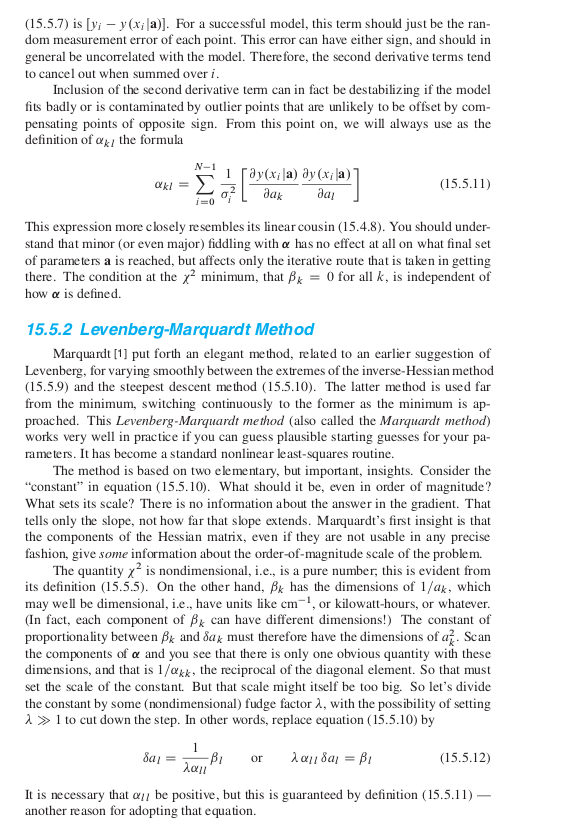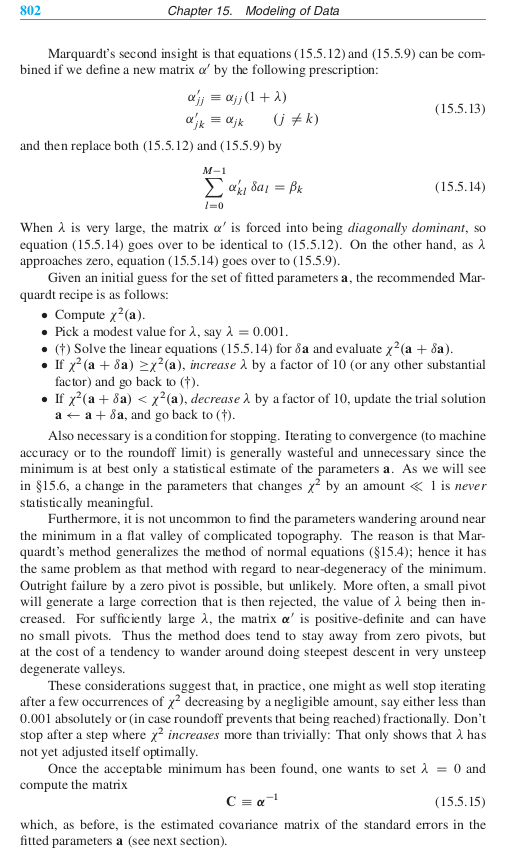

This is implemented inside scipy as https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.least_squares.html

A problem with "packages", like that of scipy or of NR3, is that they sometimes contain features that one is tempted to use but are dangerous.  I don't like constraining ranges of variables over which to fit; and I don't like reweighting the function with the "rho(z) capability.  However, this is turned off by default, and we will leave it that way.  In all cases, one should be scientific- we should understand the data, why there might be fluctuations, and we should understand the fit procedure.

So we start by defining our function, which has the specification:
Function which computes the vector of residuals, with the signature fun(x, *args, \**kwargs), i.e., the minimization proceeds with respect to its first argument. The argument x passed to this function is an ndarray of shape (n,) (never a scalar, even for n=1). It must return a 1-d array_like of shape (m,) or a scalar. I

In [13]:
def residuals(parameters,*args):
    t,x,sigma=args
    A,x0,omega,theta0=parameters
    return ((A*np.cos(omega*t-theta0)+x0-x)/sigma)

#test it out with our function
fitParameters=np.array([amp0,x0,omega,theta0])
args=(t[m:n],x[m:n],uncertainties)
xx=residuals(fitParameters,*args)

In [14]:
from scipy.optimize import least_squares
args=(t[m:n],x[m:n],uncertainties)
startingParameters=np.array([amp0,x0,omega,theta0])
#amp,x,omega,theta0=
out=least_squares(residuals,startingParameters,args=args,method='lm')
print(out)

 active_mask: array([0, 0, 0, 0])
        cost: 125956.70003375609
         fun: array([ -2.06293875e+01,  -2.36094742e+01,  -3.03139530e+01,
        -3.48743204e+01,  -3.90438331e+01,  -4.25021768e+01,
        -3.78998480e+01,  -4.16987839e+01,  -5.34712793e+01,
        -5.48153557e+01,  -5.61531876e+01,  -4.96024727e+01,
        -7.09890542e+00,  -1.59092150e+01,  -4.47705939e+01,
        -4.15519953e+01,  -3.79707058e+01,  -3.15688670e+01,
        -2.40791911e+01,  -1.78755940e+01,  -1.06618076e+01,
        -2.83978835e+00,   3.69431635e+00,   1.04181801e+01,
         1.24759131e+01,   3.19494885e+01,   2.79499022e+01,
         3.07422791e+01,   3.55897910e+01,   3.60401003e+01,
         3.50701877e+01,   3.70173223e+01,   4.20096773e+01,
         4.72324604e+01,   4.72571451e+01,   4.38397376e+01,
         3.02689024e+01,   3.04480607e+01,   3.86875107e+01,
         3.52792963e+01,   3.09169256e+01,   2.58612127e+01,
         2.46585495e+01,   1.01215655e+01,   1.15487389e+01,
    

What do the outputs mean?  

A few general comments about fits:
a.  If there are issues, it is almost always a bug in the fitting function.  Always plot out the function, and see that it makes sense.  In multidimensional fits, you can probably only look in the vicinity of a few points.
b.  Occasionally, fits fail because the parameters are not independent.  
c.  Fitting results in parameters with correlations.  The covariance matrix gives you these correlations.
d.  For a well defined problem, with a single minimum, the results of the fit should not depend upon starting parameters.  If fits only converge with carefully chosen initial conditions there might be multiple local minima.  There is no general solution for this- it requires intelligence to pick out an algorithm that will work.  Often this is seen if you have dependent parameters or bugs in the fitting function.  

Let start by replotting the data, the function, and then the residuals.  

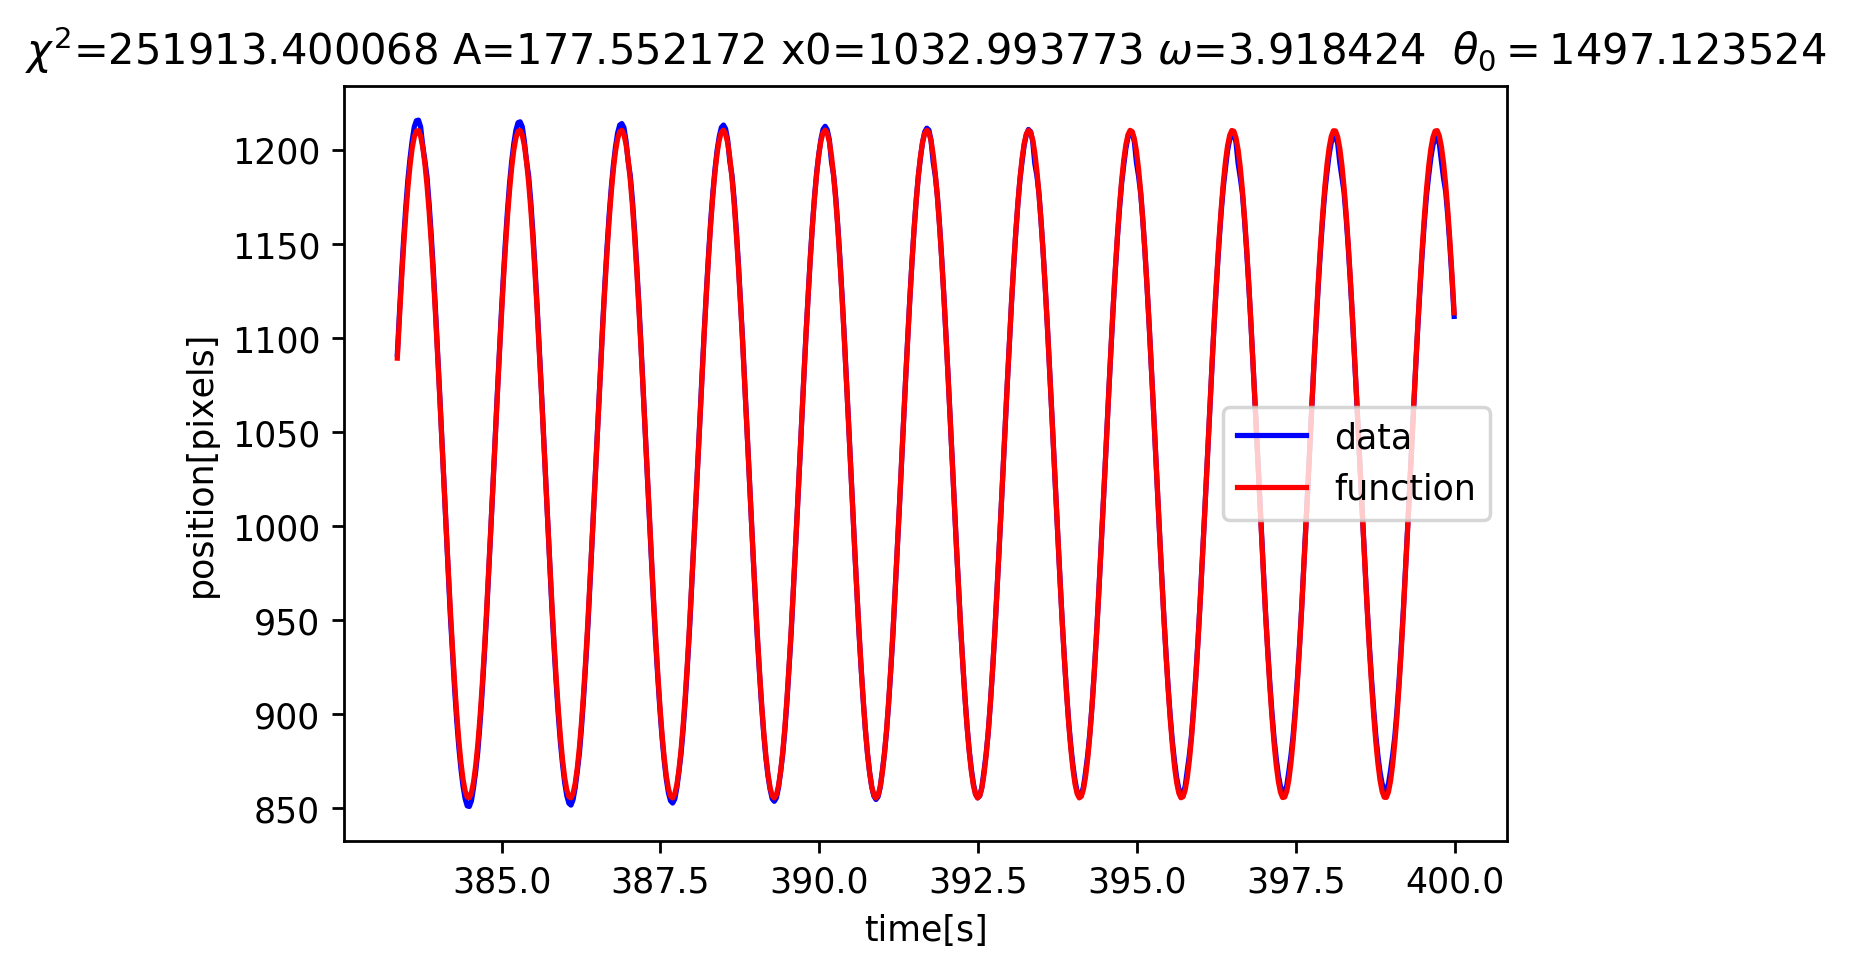

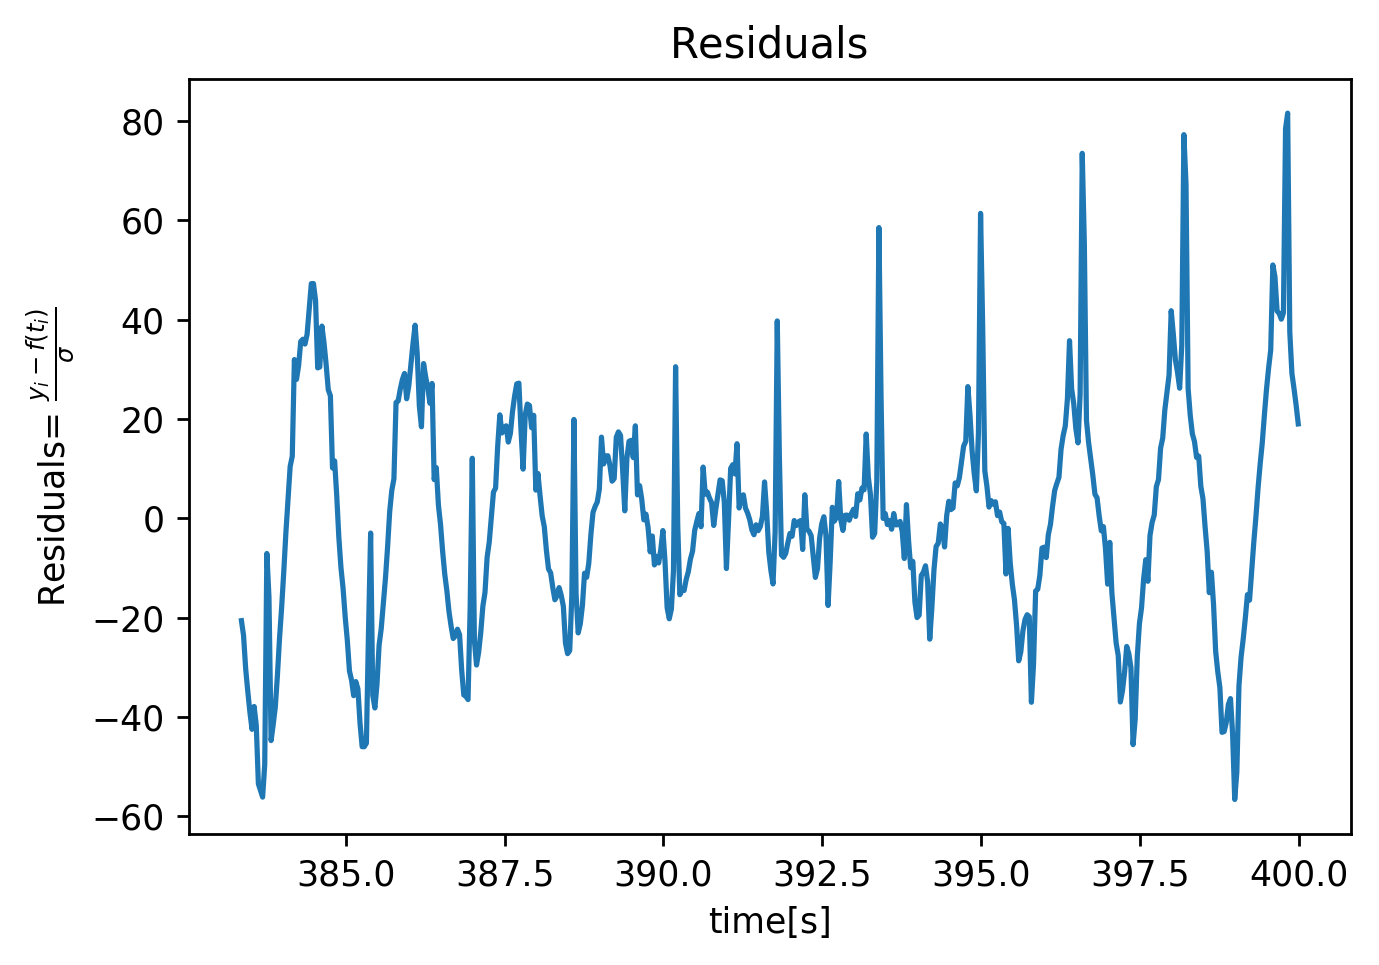

In [15]:
amp0,x0,omega,theta0=out.x
xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
bestChiSquare=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amp0,x0,omega,theta0)
title=r'$\chi^2$=%f A=%f x0=%f $\omega$=%f  $\theta_0=%f$' % (bestChiSquare,amp0,x0,omega,theta0)
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()
plt.figure()
plt.title('Residuals')
plt.xlabel('time[s]')
plt.ylabel(r'Residuals= $\frac{y_i-f(t_i)}{\sigma}$')
plt.plot(t[m:n],out.fun)

Notice that the chisquare is twice the "cost function".  This is just a question of definition- the cost is probably appropriate for a log-likelihood fit. 

But note that the automated fit has done significantly better- with only a handful of calls than we did seeking by hand one dimension at a time.  

The residuals show that the fitting function doesn't have a damping term in it, although the data clearly do.

But it also seems that there is a systematic offset at the peak to the right.  We zoom in to look at that:

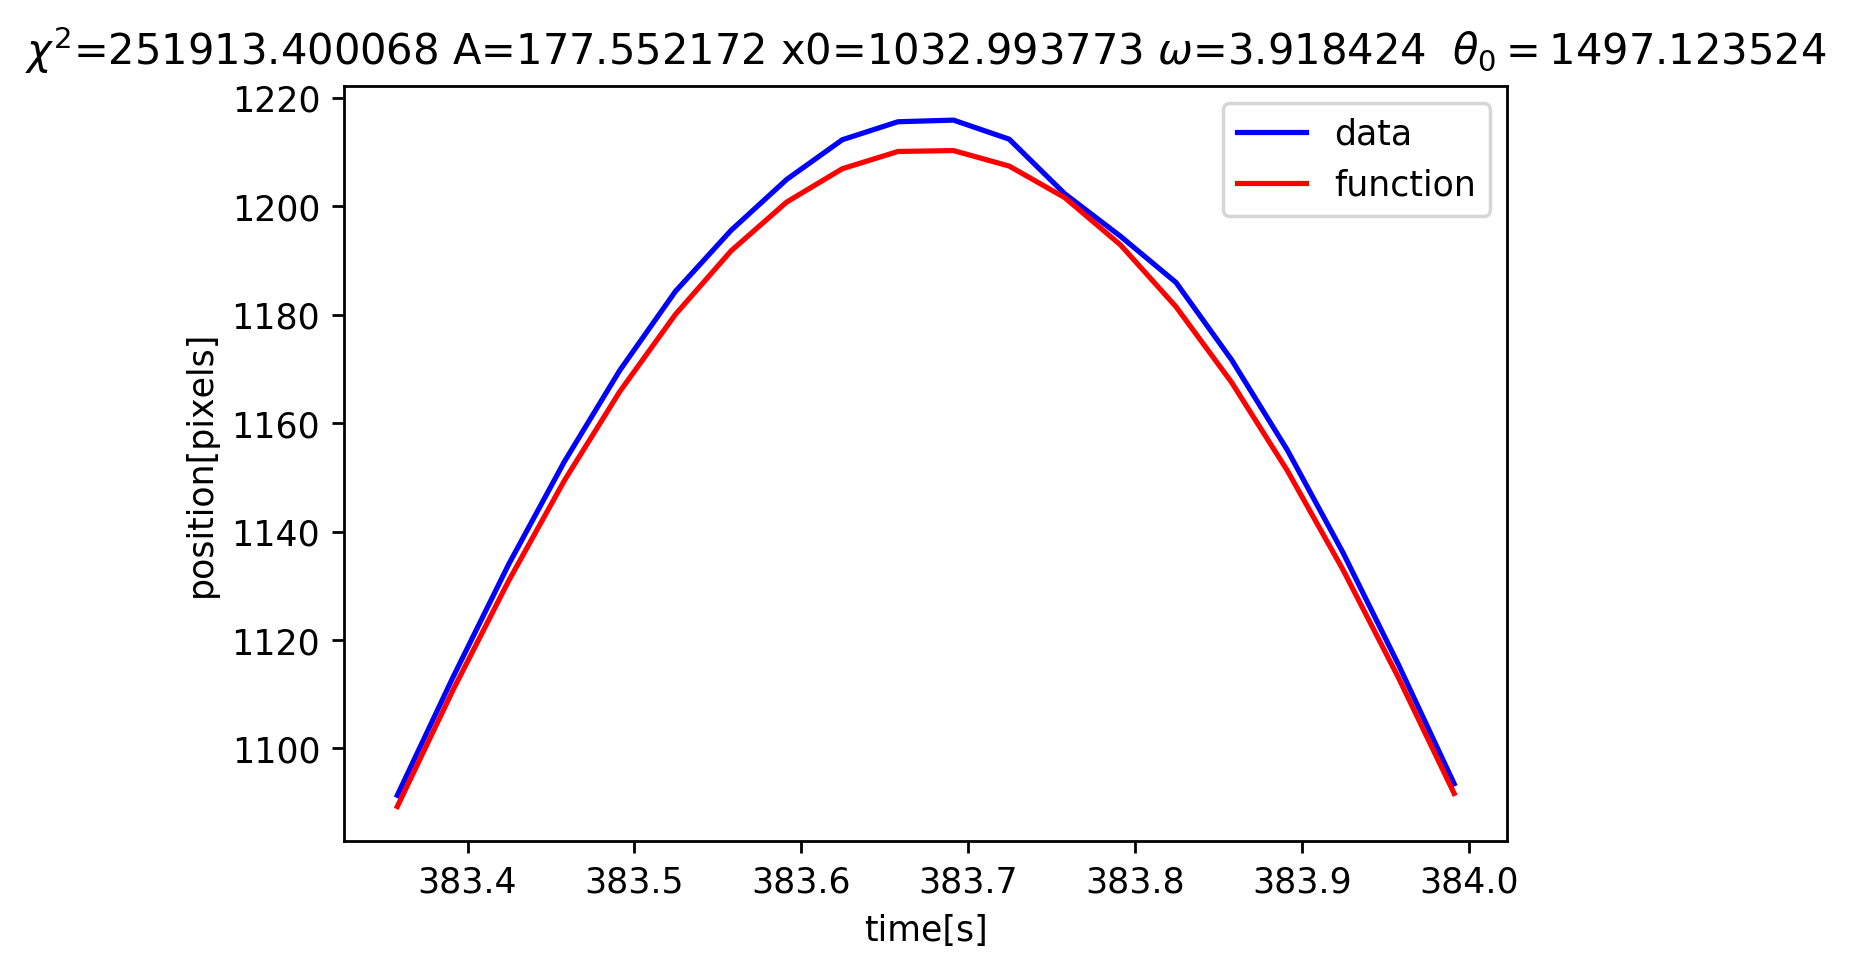

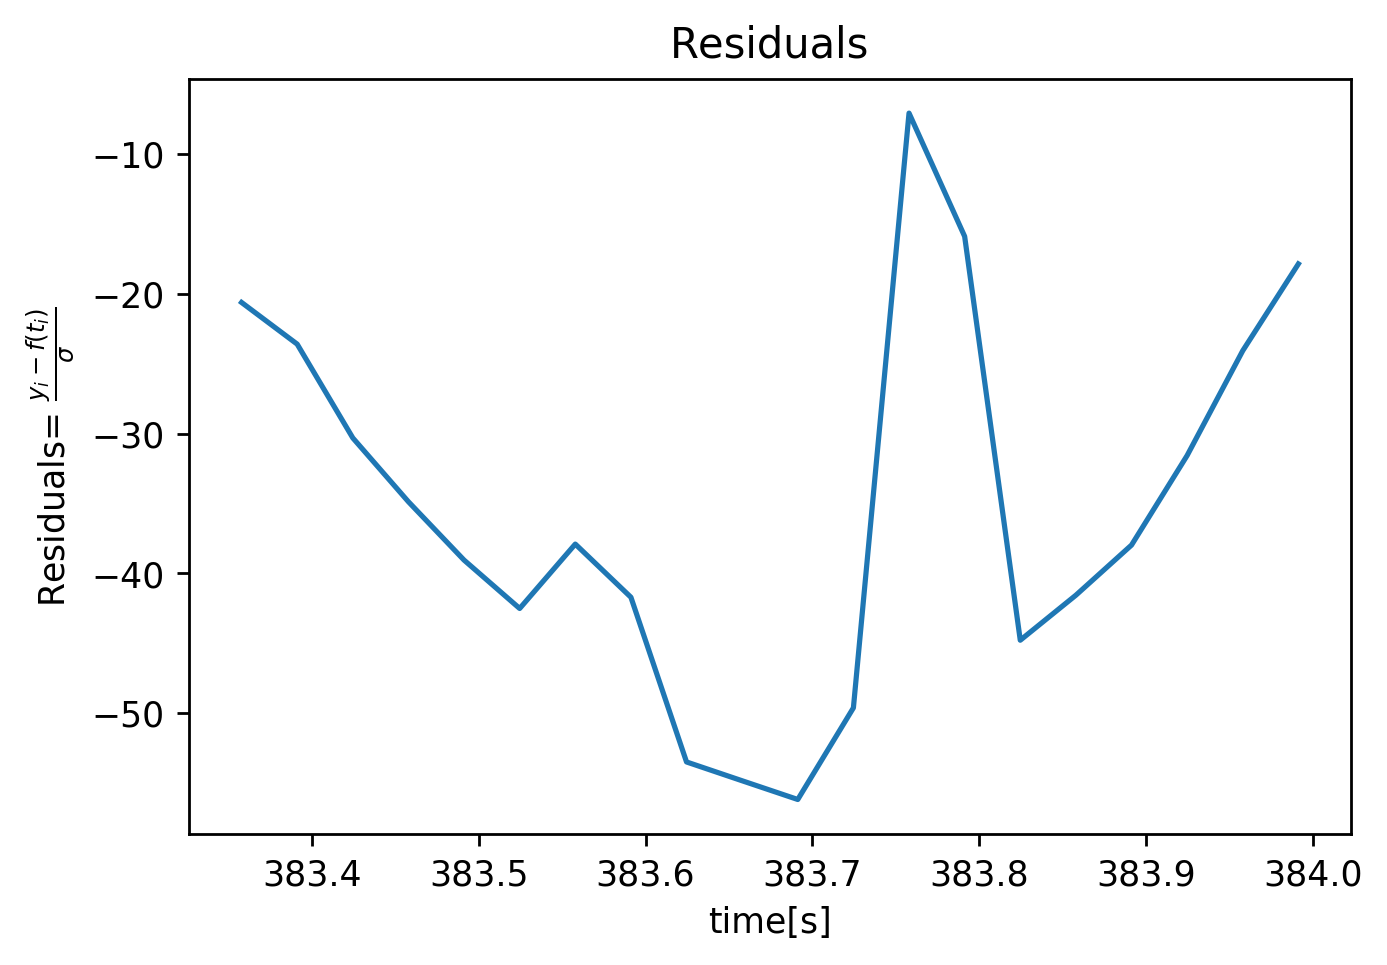

In [16]:
delta=20
n=m+delta
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc[:delta],'r',label='function')
plt.legend()
plt.figure()
plt.title('Residuals')
plt.xlabel('time[s]')
plt.ylabel(r'Residuals= $\frac{y_i-f(t_i)}{\sigma}$')
plt.plot(t[m:n],out.fun[:delta])

The fact that this is so regular makes one think that it is part of the motion- perhaps motion in the z direction? It is quite small- remember that $\sigma=0.1$ pixels, so a jump in residual of 40 is a change in position of 4 pixels.  

What about uncertainties?  Because we have left out certain factors- like the z-velocity of the ball or the fact that there is damping-$\chi^2=252000$, while we expected $\chi^2=500$- so the fluctuations between data and fit show that the "actual" uncertainties are about 22 times larger than what we used.  These are not properly statistical uncertainties, but we can treat them as such, and we scale the uncertainty by 22.

We do that, and then plot $\chi^2$ as a function of x0.





[[ 1032.79377274   524.61446848]
 [ 1032.801936     524.28402743]
 [ 1032.81009927   523.96735474]
 [ 1032.81826253   523.66445042]
 [ 1032.8264258    523.37531447]
 [ 1032.83458907   523.09994689]
 [ 1032.84275233   522.83834767]
 [ 1032.8509156    522.59051682]
 [ 1032.85907886   522.35645435]
 [ 1032.86724213   522.13616023]
 [ 1032.87540539   521.92963449]
 [ 1032.88356866   521.73687711]
 [ 1032.89173192   521.55788811]
 [ 1032.89989519   521.39266747]
 [ 1032.90805845   521.24121519]
 [ 1032.91622172   521.10353129]
 [ 1032.92438498   520.97961575]
 [ 1032.93254825   520.86946858]
 [ 1032.94071151   520.77308978]
 [ 1032.94887478   520.69047935]
 [ 1032.95703805   520.62163729]
 [ 1032.96520131   520.56656359]
 [ 1032.97336458   520.52525826]
 [ 1032.98152784   520.4977213 ]
 [ 1032.98969111   520.4839527 ]
 [ 1032.99785437   520.48395248]
 [ 1033.00601764   520.49772062]
 [ 1033.0141809    520.52525713]
 [ 1033.02234417   520.56656201]
 [ 1033.03050743   520.62163525]
 [ 1033.03

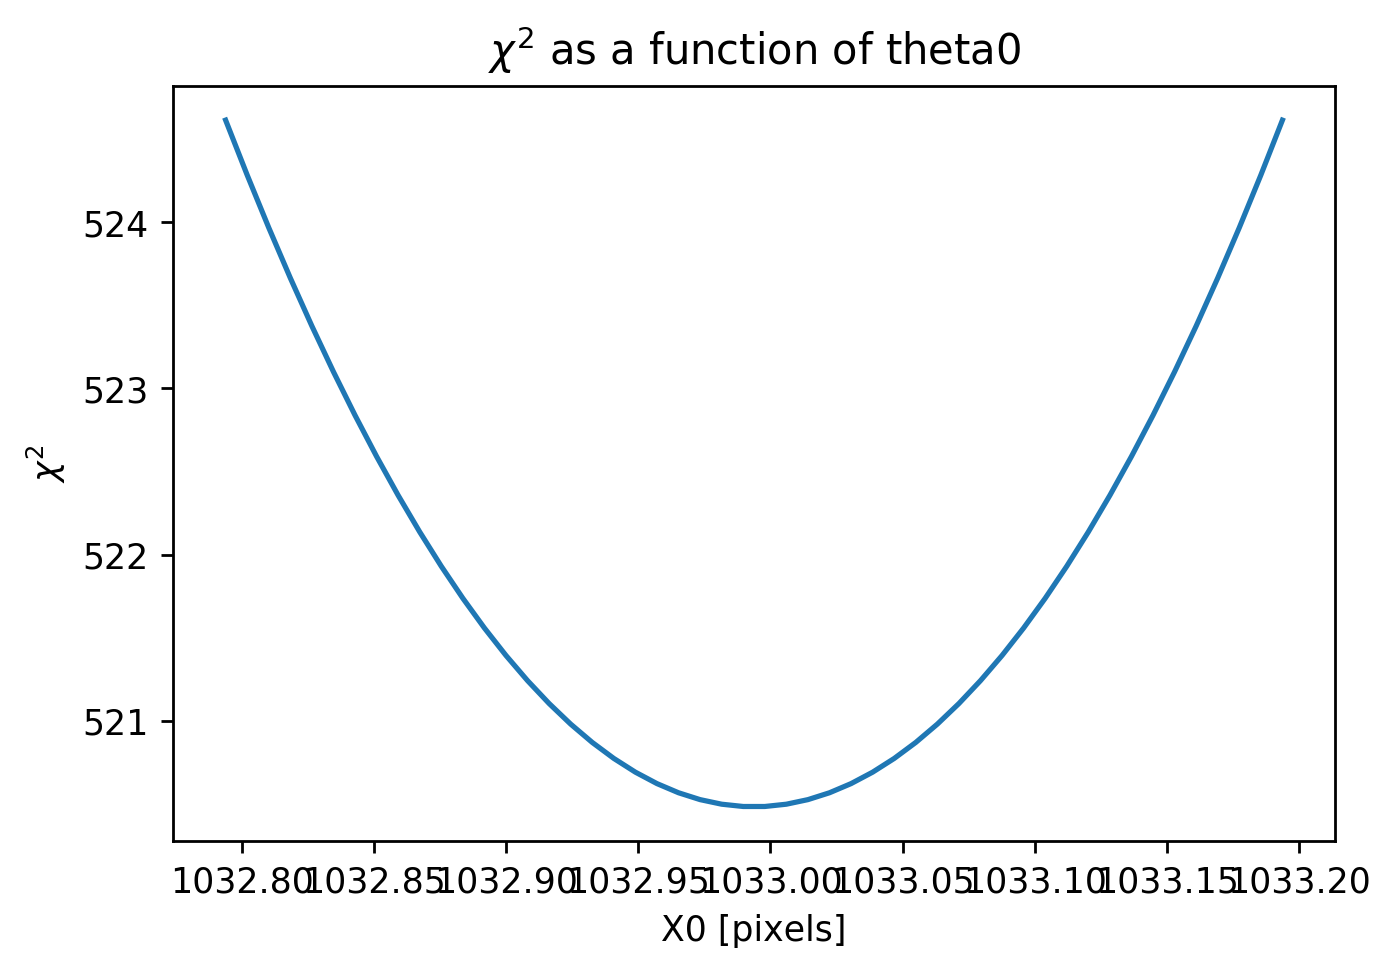

In [17]:
n=m+500
uncertainties=uncertainties*22.0
offset=np.linspace(x0-0.2,x0+0.2,50)
chisq=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amp0,offset,omega,theta0)

x0=offset[np.argmin(chisq)]
bestChiSquare=np.amin(chisq)

plt.figure()
plt.title(r'$\chi^2$ as a function of theta0')
plt.xlabel('X0 [pixels]')
plt.ylabel(r'$\chi^2$')
plt.plot(offset,chisq)
print(np.array([offset,chisq]).transpose())

If we hold the other variables fixed, the uncertainty on X0 is the abscissa at which $\chi^2$ has increased by 1.  Ie.  we have [ 1032.99785438   520.4839525 ] and [ 1033.0876503    521.39266385], [ 1033.09581356   521.55788418]- so basically the uncertainty will be 1033.09-1032.99=0.10 pixel.

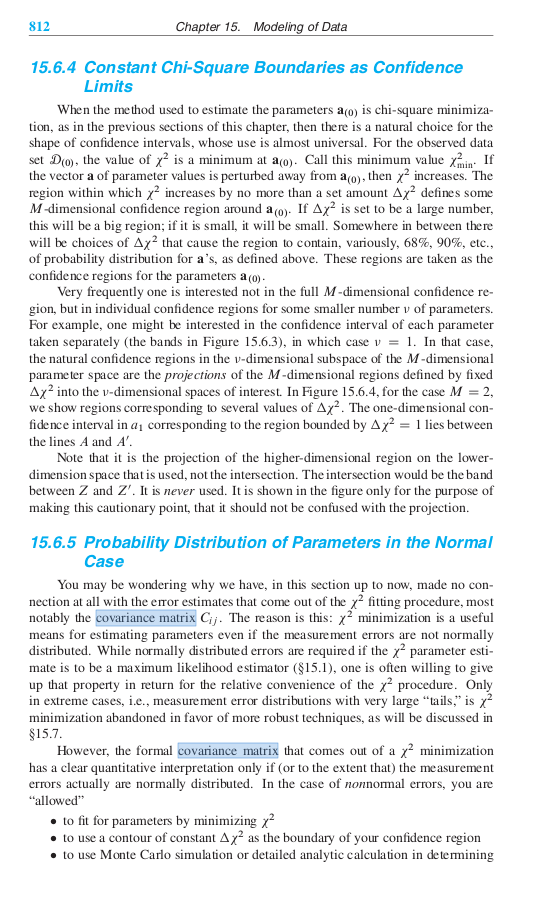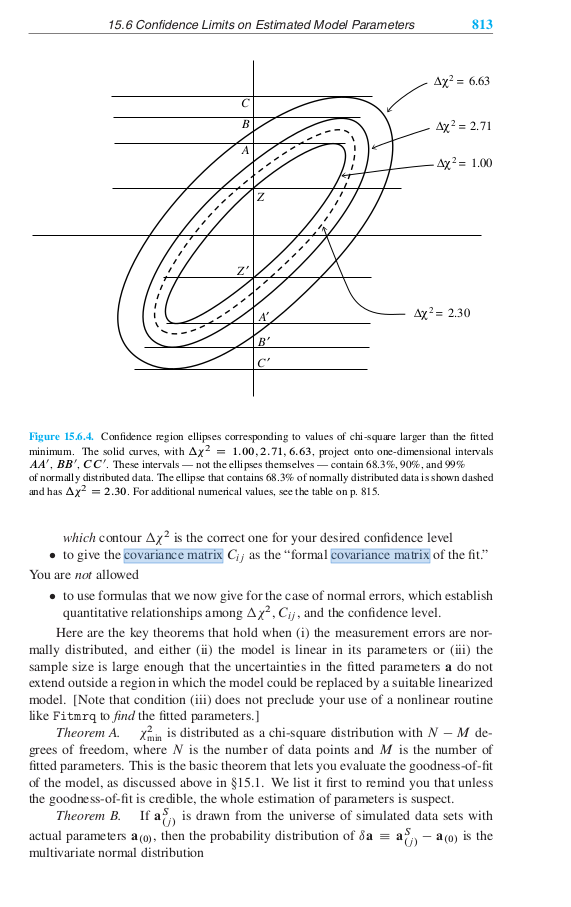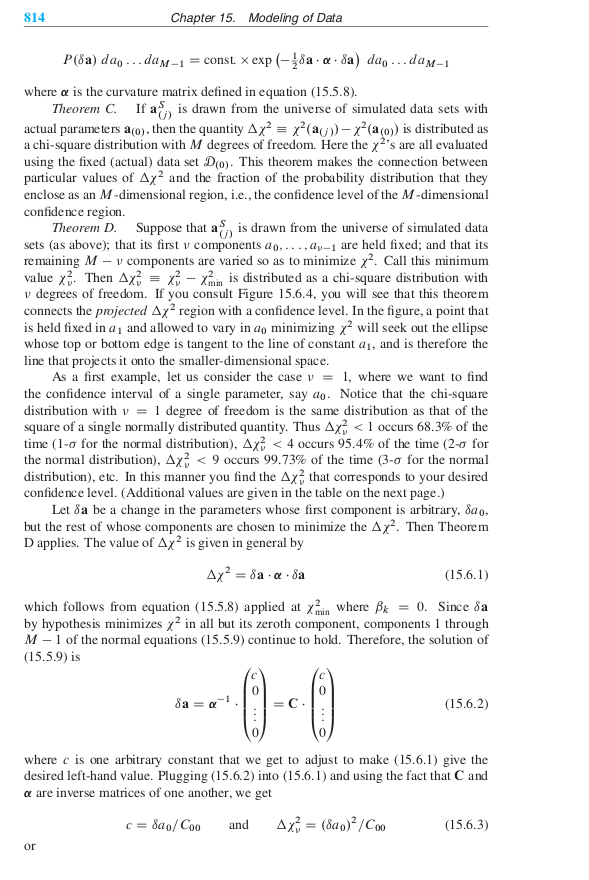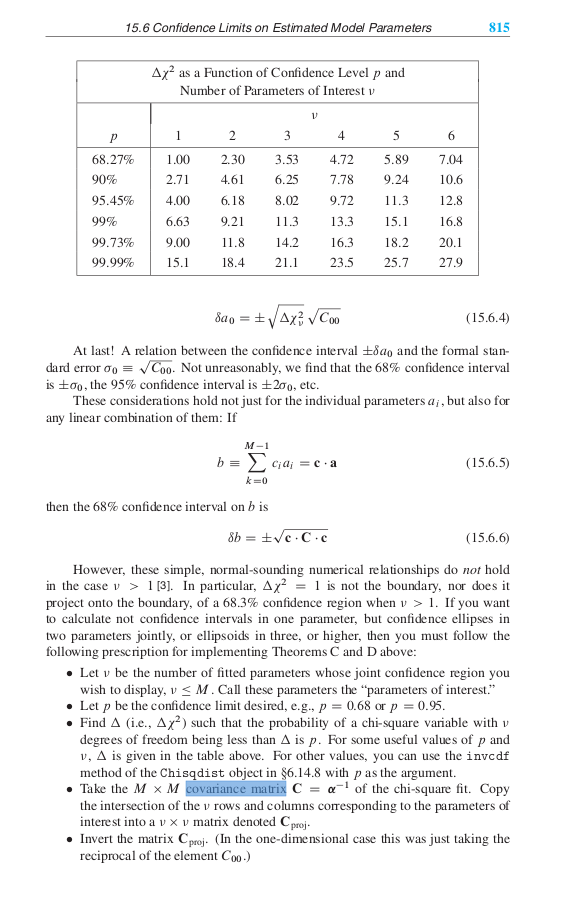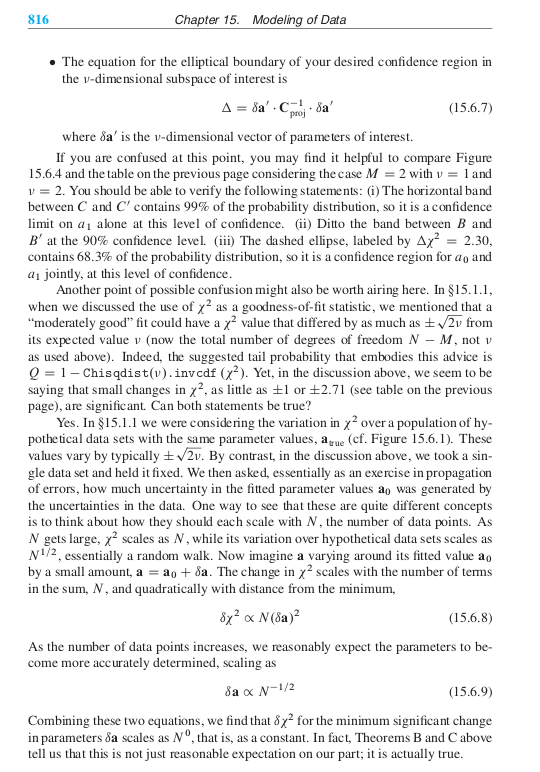

 active_mask: array([0, 0, 0, 0])
        cost: 125956.70005948696
         fun: array([ -2.06303969e+01,  -2.36104214e+01,  -3.03148222e+01,
        -3.48750973e+01,  -3.90445050e+01,  -4.25027329e+01,
        -3.79002795e+01,  -4.16990841e+01,  -5.34714438e+01,
        -5.48153826e+01,  -5.61530772e+01,  -4.96022276e+01,
        -7.09853060e+00,  -1.59087176e+01,  -4.47699831e+01,
        -4.15512822e+01,  -3.79699033e+01,  -3.15679891e+01,
        -2.40782534e+01,  -1.78746128e+01,  -1.06608000e+01,
        -2.83877166e+00,   3.69532460e+00,   1.04191627e+01,
         1.24768533e+01,   3.19503705e+01,   2.79507111e+01,
         3.07430013e+01,   3.55904148e+01,   3.60406153e+01,
         3.50705857e+01,   3.70175970e+01,   4.20098246e+01,
         4.72324784e+01,   4.72570341e+01,   4.38395001e+01,
         3.02685430e+01,   3.04475861e+01,   3.86869295e+01,
         3.52786189e+01,   3.09161641e+01,   2.58603803e+01,
         2.46576608e+01,   1.01206357e+01,   1.15477841e+01,
    

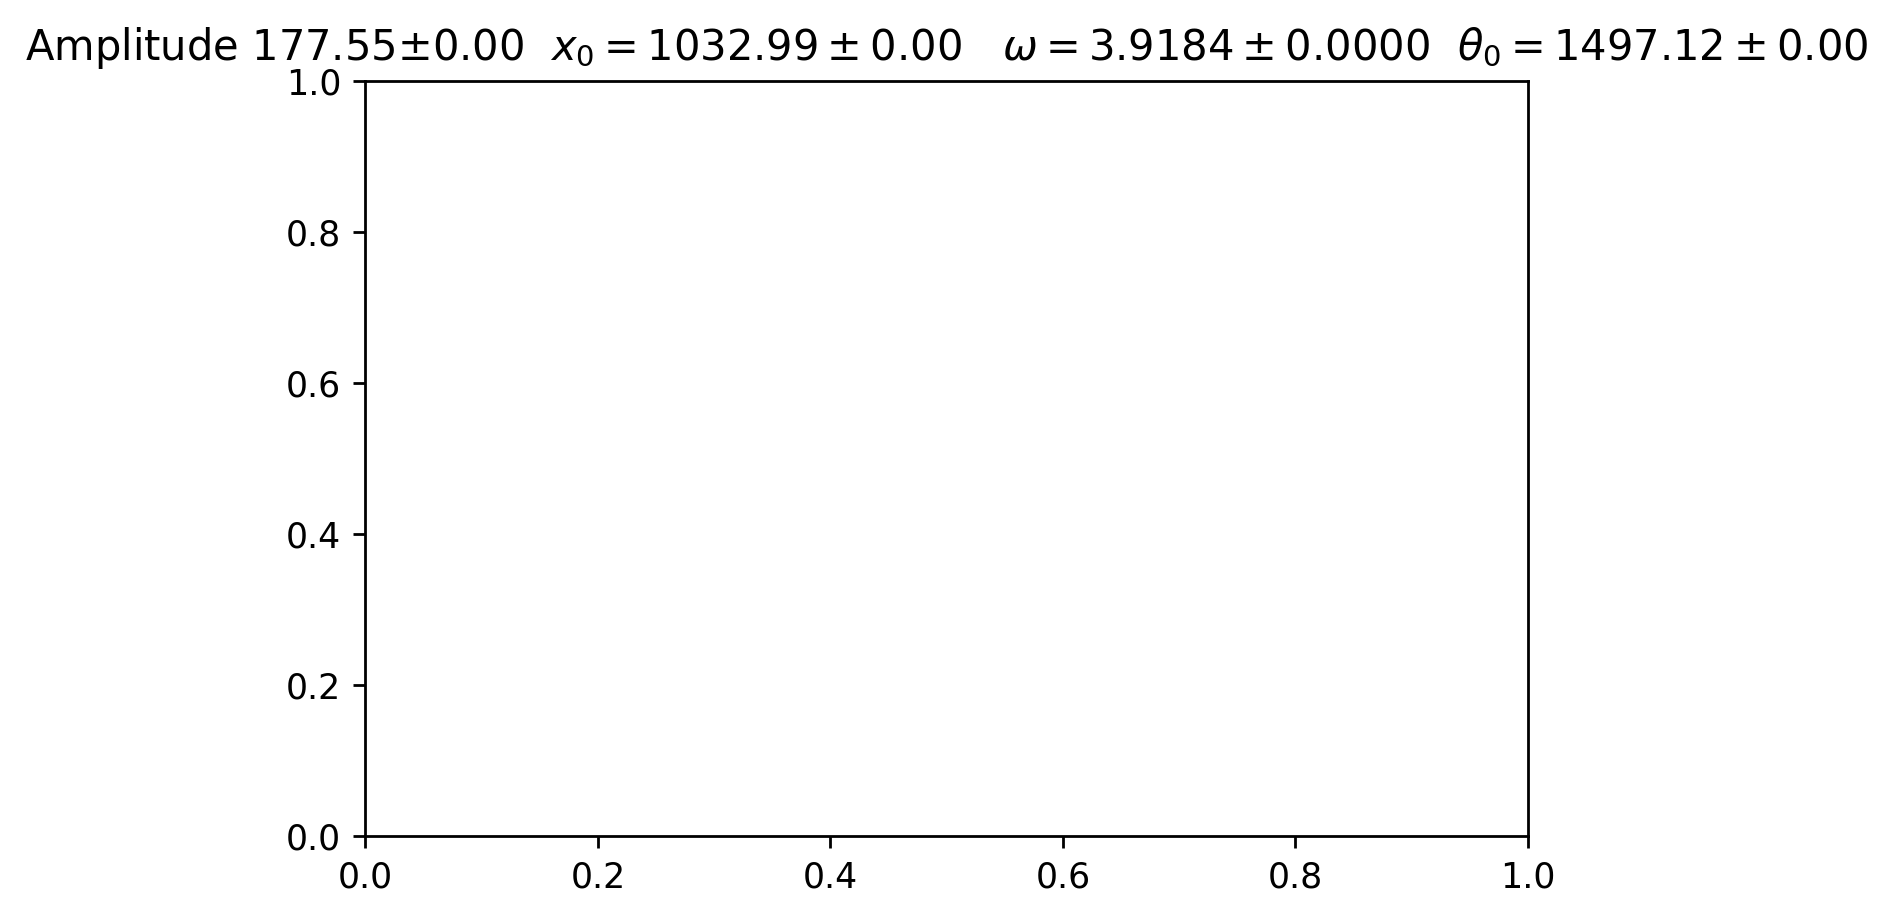

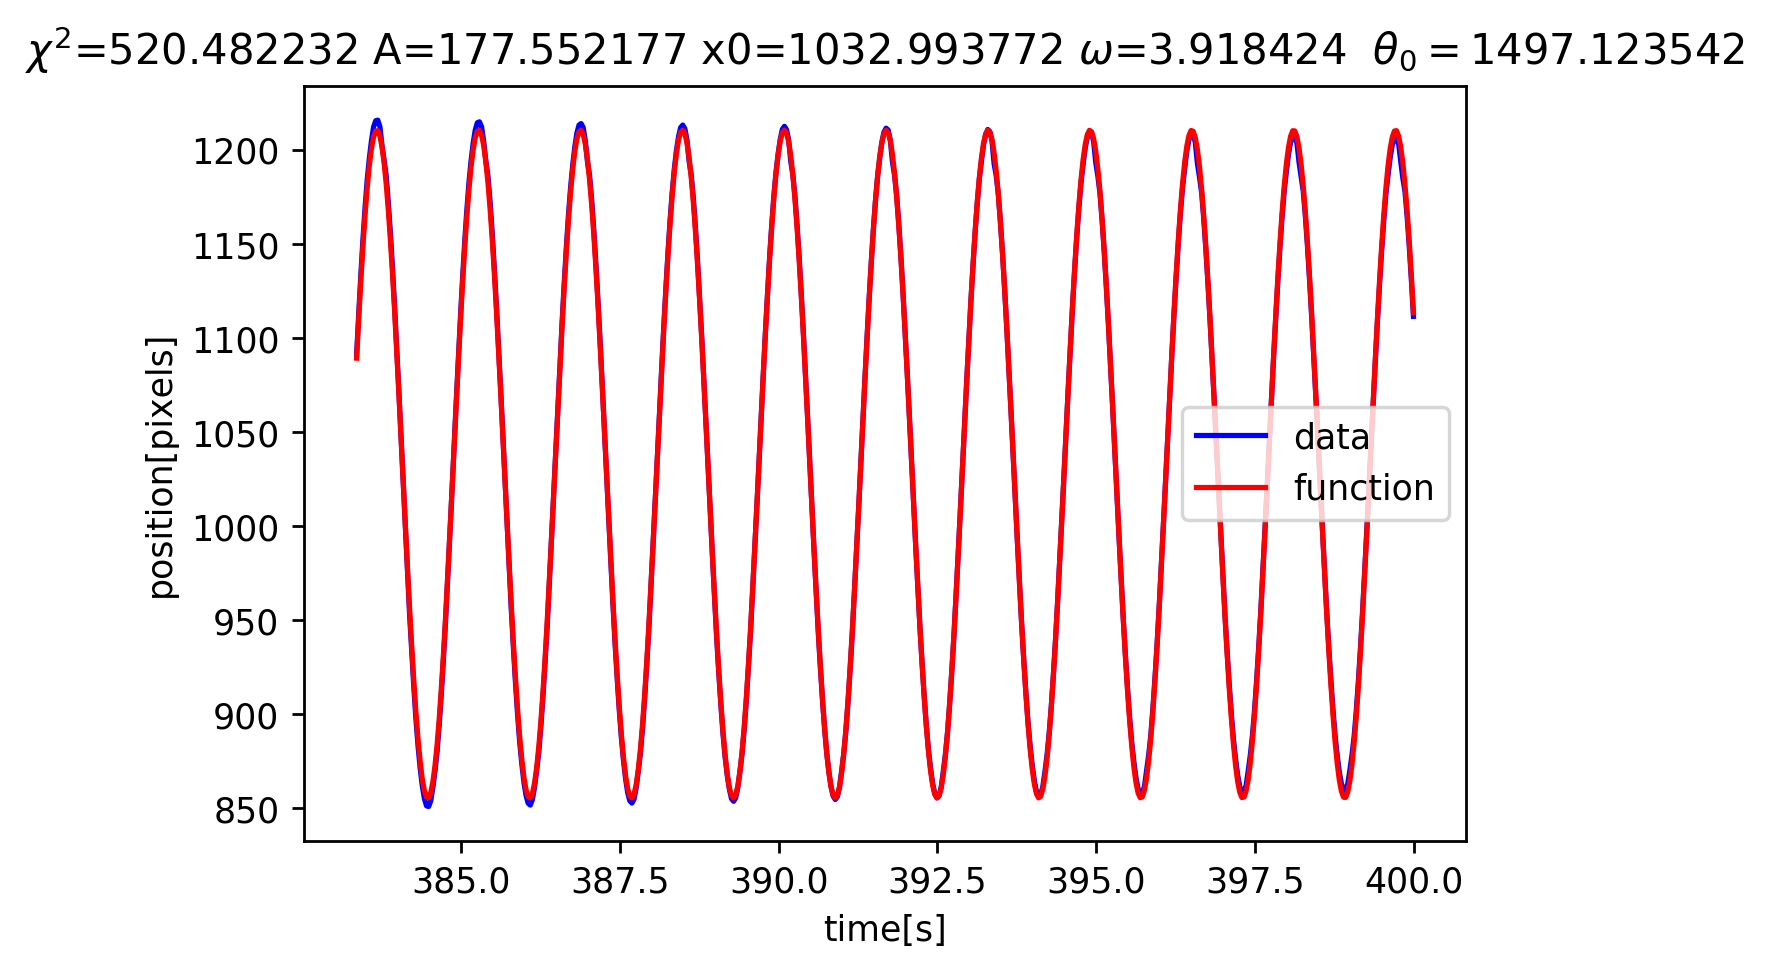

In [18]:
#refit, with the new uncertainties
startingParameters=np.array([amp0,x0,omega,theta0])
#amp,x,omega,theta0=
out=least_squares(residuals,startingParameters,args=args,method='lm')
print(out)

#to find the single parameter uncertainties, we follow the prescription
hessian=out.jac.transpose().dot(out.jac)
alpha=2*hessian  #since we want the hessian of chisquare, and the fitter used the hessian of the cost function=1/2 chisquare
C=np.linalg.inv(alpha)
unc=np.sqrt(np.diagonal(C))

print('Best fit values with single parameter uncertainties are:')
plt.figure()
plt.title(r'Amplitude %6.2f$\pm %6.2f$  $x_0=%6.2f\pm %6.2f$   $\omega=%6.4f\pm %6.4f$  $\theta_0=%6.2f\pm %6.2f$'%
          (out.x[0],unc[0], out.x[1],unc[1],out.x[2],unc[2],out.x[3],unc[3]))

amp0,x0,omega,theta0=out.x
xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
bestChiSquare=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amp0,x0,omega,theta0)
title=r'$\chi^2$=%f A=%f x0=%f $\omega$=%f  $\theta_0=%f$' % (bestChiSquare,amp0,x0,omega,theta0)
plt.figure()
plt.title(title)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()

Now double check to see if the starting guesses matter.  We find that the amplitude and x0 are pretty robust, but that we need to specify theta between 3.7 and 4.2 in order to make the fits work and theta0 around 1300-1550.  Does this make sense?

 active_mask: array([0, 0, 0, 0])
        cost: 125956.70005936781
         fun: array([ -2.06303939e+01,  -2.36104185e+01,  -3.03148196e+01,
        -3.48750950e+01,  -3.90445030e+01,  -4.25027312e+01,
        -3.79002782e+01,  -4.16990832e+01,  -5.34714434e+01,
        -5.48153825e+01,  -5.61530775e+01,  -4.96022284e+01,
        -7.09853174e+00,  -1.59087191e+01,  -4.47699850e+01,
        -4.15512844e+01,  -3.79699057e+01,  -3.15679918e+01,
        -2.40782562e+01,  -1.78746158e+01,  -1.06608031e+01,
        -2.83877477e+00,   3.69532151e+00,   1.04191597e+01,
         1.24768504e+01,   3.19503677e+01,   2.79507086e+01,
         3.07429991e+01,   3.55904128e+01,   3.60406137e+01,
         3.50705845e+01,   3.70175961e+01,   4.20098242e+01,
         4.72324783e+01,   4.72570344e+01,   4.38395008e+01,
         3.02685441e+01,   3.04475876e+01,   3.86869313e+01,
         3.52786210e+01,   3.09161664e+01,   2.58603829e+01,
         2.46576635e+01,   1.01206386e+01,   1.15477871e+01,
    

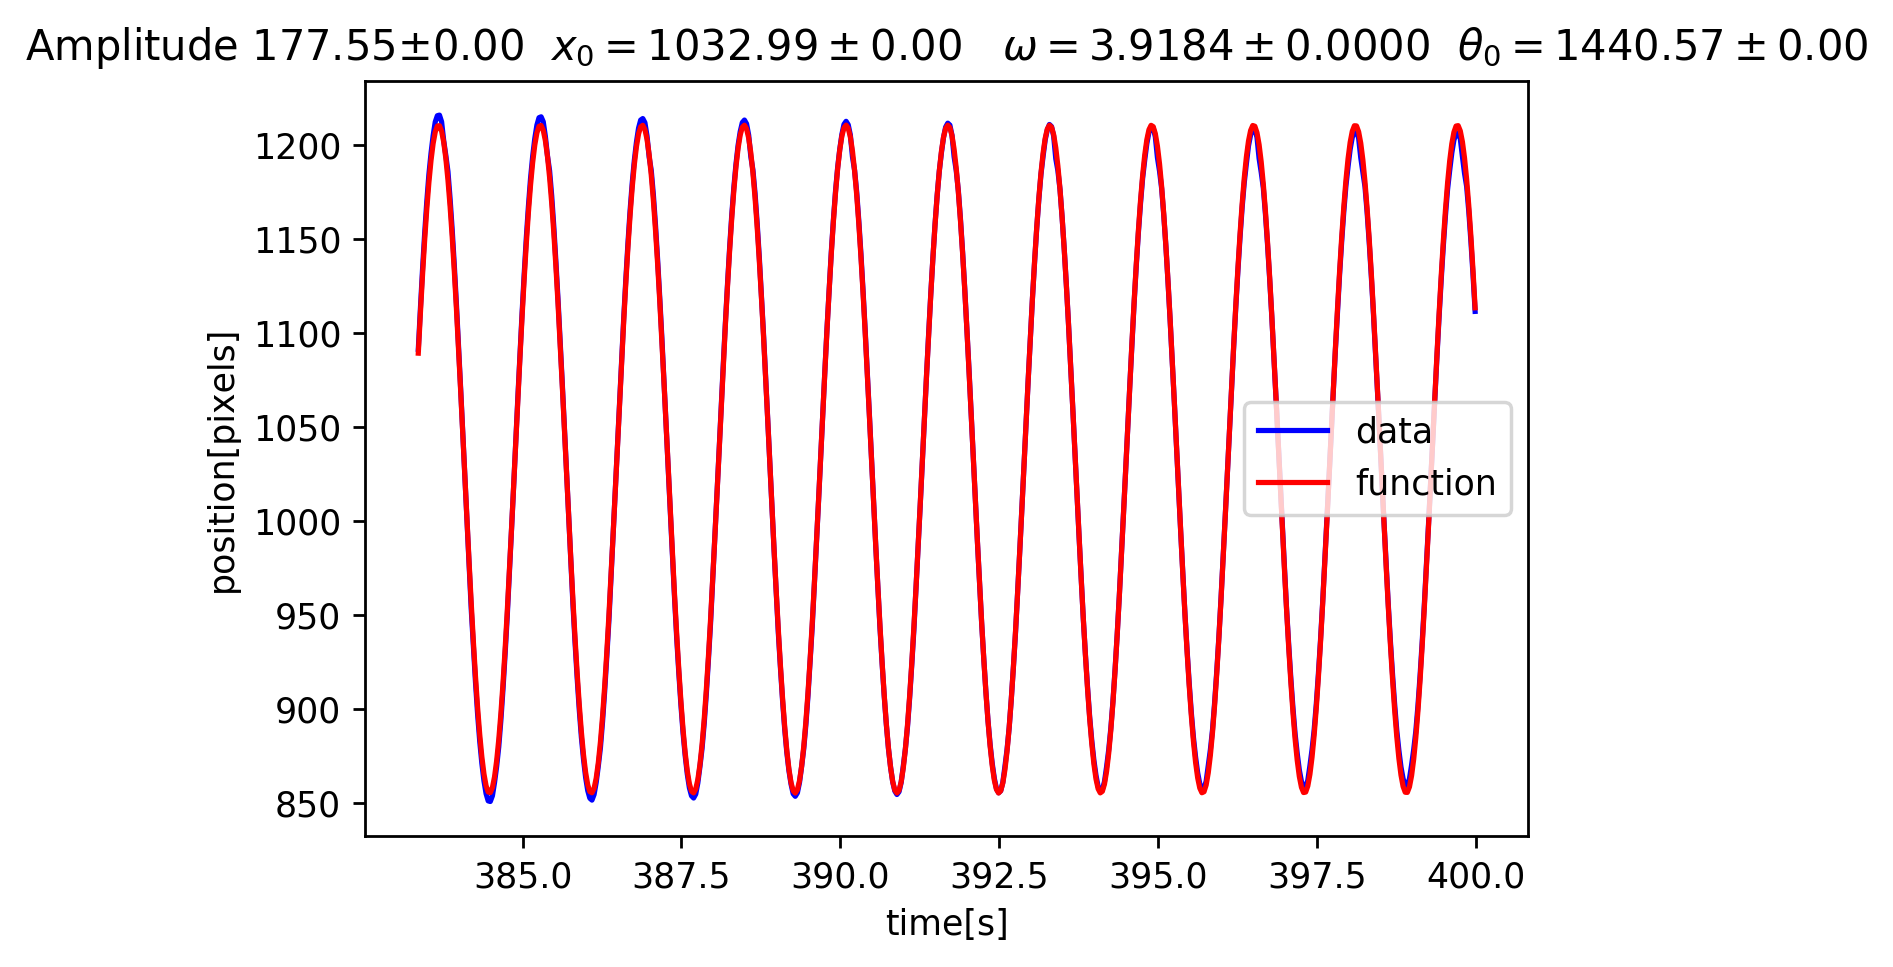

In [19]:
startingParameters=np.array([500,10,4.2,1550])
#amp,x,omega,theta0=
out=least_squares(residuals,startingParameters,args=args,method='lm')
print(out)
#startingParameters=out.x
#out=least_squares(residuals,startingParameters,args=args,method='lm')

#to find the single parameter uncertainties, we follow the prescription
hessian=out.jac.transpose().dot(out.jac)
alpha=2*hessian  #since we want the hessian of chisquare, and the fitter used the hessian of the cost function=1/2 chisquare
C=np.linalg.inv(alpha)
unc=np.sqrt(np.diagonal(C))

print('Best fit values with single parameter uncertainties are:')
plt.figure()
plt.title(r'Amplitude %6.2f$\pm %6.2f$  $x_0=%6.2f\pm %6.2f$   $\omega=%6.4f\pm %6.4f$  $\theta_0=%6.2f\pm %6.2f$'%
          (out.x[0],unc[0], out.x[1],unc[1],out.x[2],unc[2],out.x[3],unc[3]))

amp0,x0,omega,theta0=out.x
xcalc=xFunction(t[m:n],amp0,x0,omega,theta0).reshape(-1)
bestChiSquare=chisquare(xFunction,t[m:n],x[m:n],uncertainties,amp0,x0,omega,theta0)
plt.xlabel('time[s]')
plt.ylabel('position[pixels]')
plt.plot(t[m:n],x[m:n],'b',label='data')
plt.plot(t[m:n],xcalc,'r',label='function')
plt.legend()

Now we know $x_0=1032.99\pm0.07$.  $y_0$ is harder to get, since we never go through zero.  But we proceed and see how well we can do with a simple fit.

Let's go back to the small angle pendulum solution, which is approximately correct at small amplitudes, which we have at long times.  Then we have

\begin{equation}\theta=\theta_0\cos(\omega t+\phi)\end{equation}
\begin{equation}x-x_0=l\sin(\theta)=l\sin(\theta_0\cos(\omega t+\phi))\approx l\theta_0\cos(\omega t+\phi)\end{equation}
\begin{equation}y-y_0=l(1-\cos(\theta))=l(1-\cos(\theta_0\cos(\omega t+\phi))0\approx l\theta_0^2\frac{\cos^2(\omega t+\phi)}{2}\end{equation}
\begin{equation}\end{equation}

Note that here we have defined $(x0,y0$ as the rest position of the pendulum (so y is always positive) and we have used the small angle approximation $\cos\theta\approx 1-\frac{\theta^2}{2}$ in the last equation.

Now we can proceed and fit the y data.  But we have three choices:  fit four parameters in the y equation and compare them to the x equation; fix the parameters in the y equation to those determined by the x equation, or simultaneously fit both x and y.  What are the advantages of each of the three?  

Start by defining yResiduals, with all four parameters free.  $B=\frac{l\theta_0^2}{2}.$

 active_mask: array([0, 0, 0, 0])
        cost: 89.942831902836716
         fun: array([ 0.49816557,  0.42913053,  0.5208767 ,  0.66789813,  0.76603701,
        0.81855221,  0.86354924,  1.05759143,  1.14063235,  1.3192916 ,
        1.40603704,  1.34498734,  1.32371673,  0.81935654,  0.69196746,
        0.61446439,  0.49962491,  0.40432085,  0.39126726,  0.40467678,
        0.18585186,  0.13139802,  0.05238654, -0.10947059, -0.19091718,
       -0.31109797, -0.42010002, -0.5696281 , -0.64778207, -0.63979767,
       -0.60670284, -0.52642456, -0.57278955, -0.49595619, -0.34666352,
       -0.26737303, -0.27920558, -0.64442407, -0.69064808, -0.5475683 ,
       -0.50344398, -0.3904948 , -0.28299072, -0.19035107, -0.02817781,
        0.06174919,  0.11151789,  0.19743374,  0.41609742,  0.56382542,
        0.56566448,  0.55428366,  0.66761453,  0.7211543 ,  0.74061501,
        0.93504436,  1.04921997,  1.17022252,  1.33766254,  1.27783389,
        1.13032007,  0.85399422,  0.63133904,  0.584150

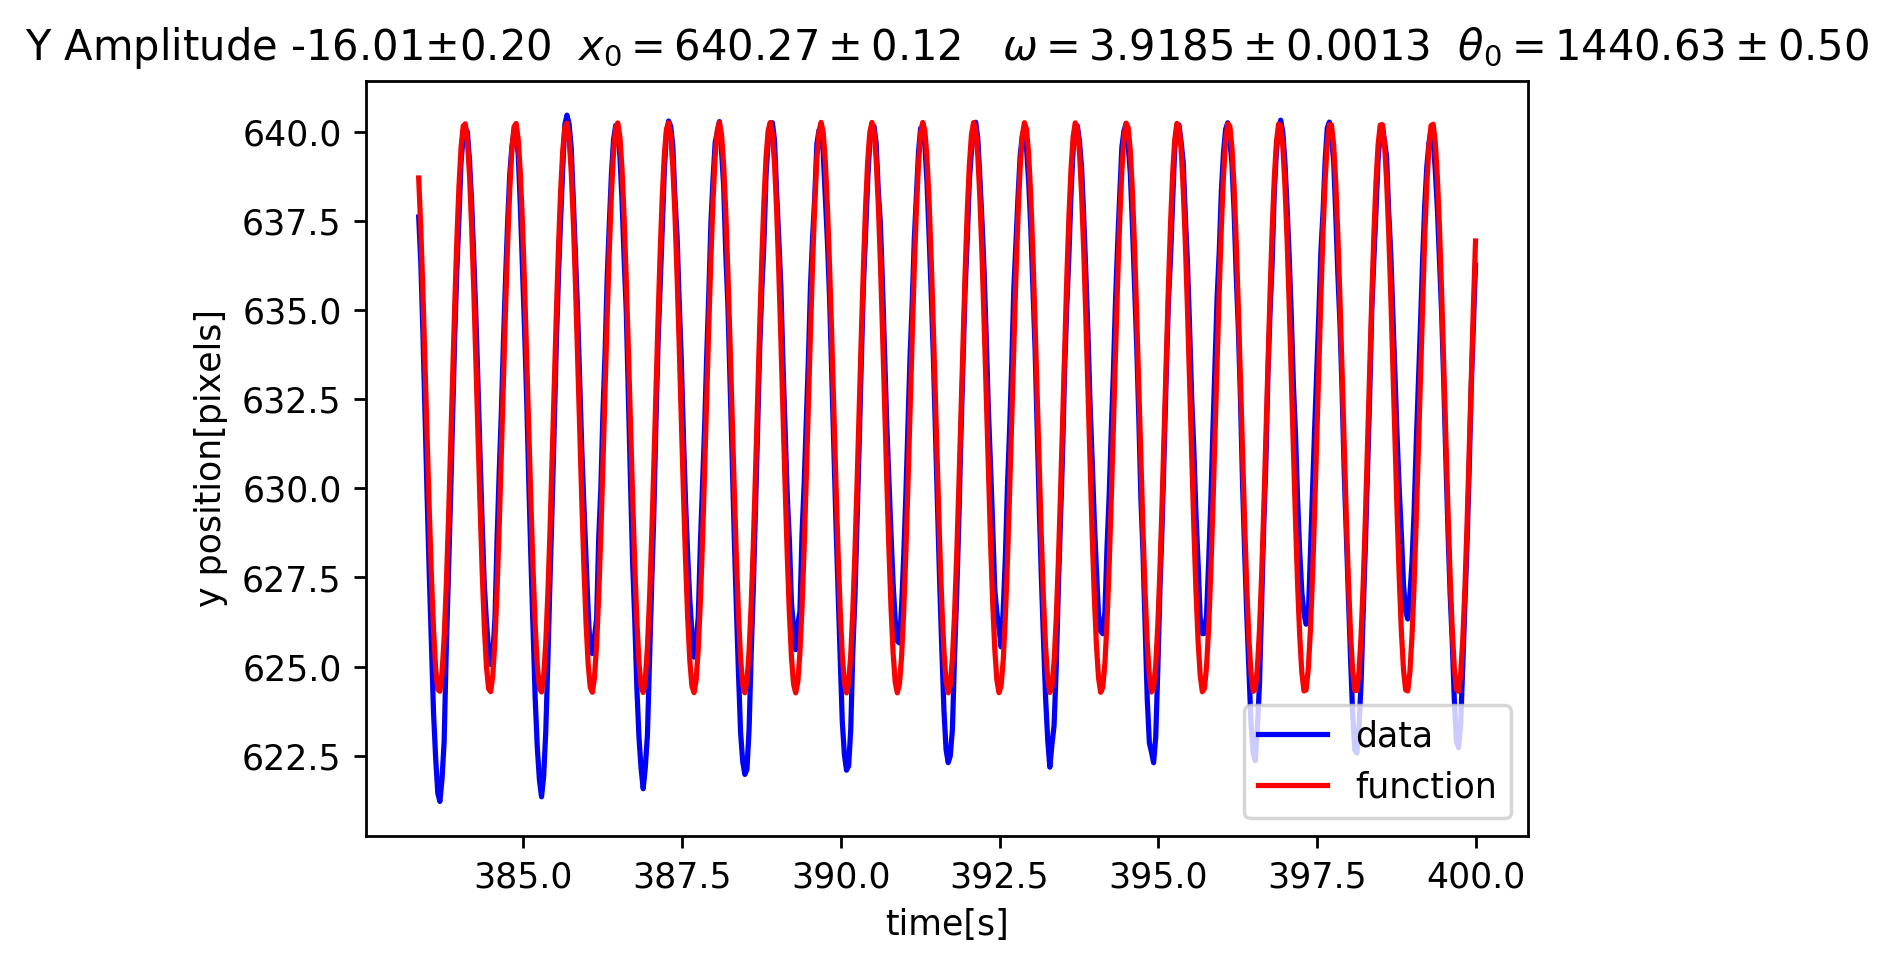

In [20]:
def yResiduals(parameters,*args):
    t,y,sigma=args
    B,y0,omega,theta0=parameters
    return ((B*np.cos(omega*t-theta0)**2+y0-y)/sigma)

#test it out with our function
fitParameters=np.array([amp0,x0,omega,theta0])
args=(t[m:n],y[m:n],uncertainties)
yout=least_squares(yResiduals,fitParameters,method='lm',args=args)
print(yout)

yhessian=yout.jac.transpose().dot(yout.jac)
yalpha=2*yhessian  #since we want the hessian of chisquare, and the fitter used the hessian of the cost function=1/2 chisquare
yC=np.linalg.inv(yalpha)
yunc=np.sqrt(np.diagonal(yC))

plt.figure()
plt.title(r'Y Amplitude %6.2f$\pm %6.2f$  $x_0=%6.2f\pm %6.2f$   $\omega=%6.4f\pm %6.4f$  $\theta_0=%6.2f\pm %6.2f$'%
          (yout.x[0],yunc[0], yout.x[1],yunc[1],yout.x[2],yunc[2],yout.x[3],yunc[3]))

B,y0,omega,theta0=yout.x
ycalc=(B*np.cos(omega*t[m:n]-theta0)**2+y0)
plt.xlabel('time[s]')
plt.ylabel('y position[pixels]')
plt.plot(t[m:n],y[m:n],'b',label='data')
plt.plot(t[m:n],ycalc,'r',label='function')
plt.legend()

A few comments:
    1.  The direction of the data y axis is opossite to the direction of the function y axis.  That is why B is negative.
    2.  The "bottom" of the pendulum is at 640, the top of the arc goes to 626 or 622.5
    3.  What can explain the alternating peak heights?  How can we differentiate the two models.  
    
We fix the model so the y axis is "down" like in the data.  And we refit the data, but now also plot the residuals.



 active_mask: array([0, 0, 0, 0])
        cost: 89.942831901353159
         fun: array([ 0.49816419,  0.42912871,  0.52087458,  0.66789583,  0.76603471,
        0.81855007,  0.8635474 ,  1.05759001,  1.14063144,  1.31929127,
        1.40603731,  1.34498818,  1.32371809,  0.81935833,  0.69196954,
        0.61446664,  0.49962717,  0.40432296,  0.39126909,  0.4046782 ,
        0.18585279,  0.1313984 ,  0.05238634, -0.10947134, -0.19091843,
       -0.31109963, -0.42010197, -0.56963021, -0.64778419, -0.63979966,
       -0.60670456, -0.52642589, -0.57279041, -0.49595652, -0.3466633 ,
       -0.26737228, -0.27920434, -0.64442244, -0.69064616, -0.54756623,
       -0.5034419 , -0.39049285, -0.28298902, -0.19034973, -0.02817692,
        0.06174956,  0.11151774,  0.19743307,  0.4160963 ,  0.56382392,
        0.5656627 ,  0.55428174,  0.66761259,  0.72115247,  0.74061342,
        0.93504312,  1.04921916,  1.1702222 ,  1.33766272,  1.27783456,
        1.13032118,  0.85399569,  0.63134078,  0.584152

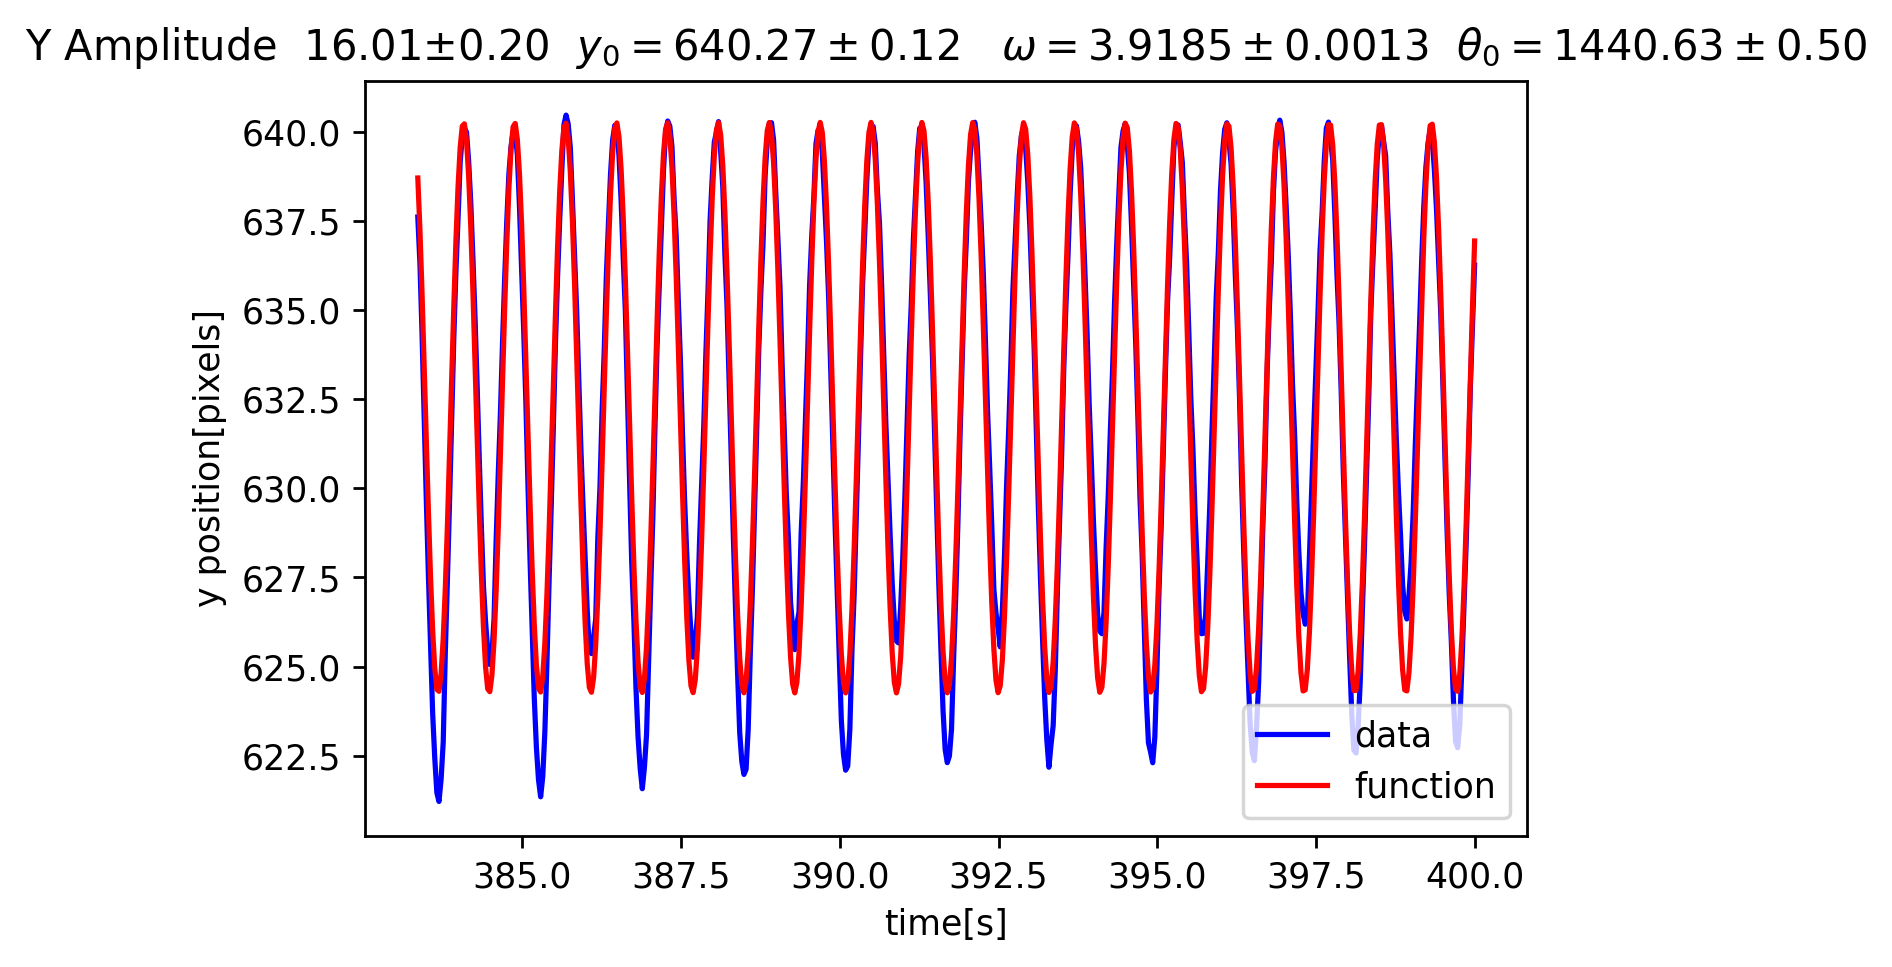

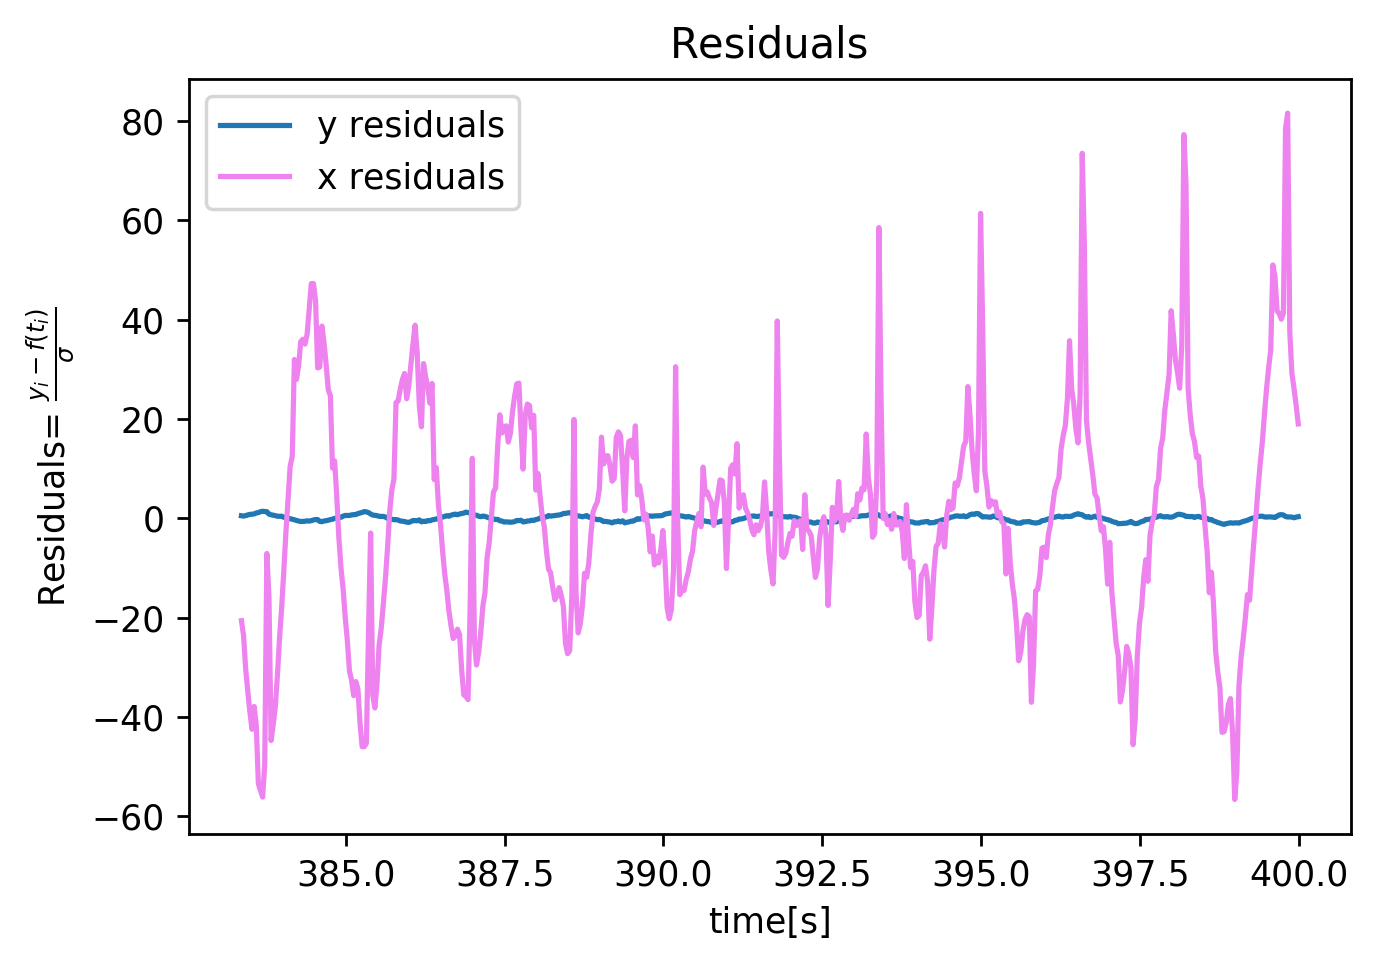

In [21]:
def yResiduals(parameters,*args):
    t,y,sigma=args
    B,y0,omega,theta0=parameters
    return ((y0-B*np.cos(omega*t-theta0)**2-y)/sigma)

#test it out with our function
fitParameters=np.array([amp0,x0,omega,theta0])
args=(t[m:n],y[m:n],uncertainties)
yout=least_squares(yResiduals,fitParameters,method='lm',args=args)
print(yout)

yhessian=yout.jac.transpose().dot(yout.jac)
yalpha=2*yhessian  #since we want the hessian of chisquare, and the fitter used the hessian of the cost function=1/2 chisquare
yC=np.linalg.inv(yalpha)
yunc=np.sqrt(np.diagonal(yC))

plt.figure()
plt.title(r'Y Amplitude %6.2f$\pm %6.2f$  $y_0=%6.2f\pm %6.2f$   $\omega=%6.4f\pm %6.4f$  $\theta_0=%6.2f\pm %6.2f$'%
          (yout.x[0],yunc[0], yout.x[1],yunc[1],yout.x[2],yunc[2],yout.x[3],yunc[3]))

B,y0,omega,theta0=yout.x
ycalc=(y0-B*np.cos(omega*t[m:n]-theta0)**2)
plt.xlabel('time[s]')
plt.ylabel('y position[pixels]')
plt.plot(t[m:n],y[m:n],'b',label='data')
plt.plot(t[m:n],ycalc,'r',label='function')
plt.legend()
plt.figure()
plt.title('Residuals')
plt.xlabel('time[s]')
plt.ylabel(r'Residuals= $\frac{y_i-f(t_i)}{\sigma}$')
plt.plot(t[m:n],yout.fun,label='y residuals')
plt.plot(t[m:n],out.fun,label='x residuals',color='violet')
plt.legend()

#print out parameters and uncertainties for both x fit and y fit
print()
print('The parameters and uncertainties are:')
print(np.array([out.x,unc,yout.x,yunc]).transpose())

Now the amplitude has the right sign.  Notice that there is evidence for z-motion.  How does it manifest itself in the residuals?  The x and y residuals have obvious correlations, but start anticorrelated as well.  What does that tell us?

We now know $(x_0,y_0)$ and we can proceed with converting our x-y measurements into $\theta$ measurements.  

In [22]:
#  First just print out length of pendulum in pixels and theta0.  We don't actually use these except for sanity checks.
A=amp0
B=yout.x[0]
print('A=%6.2f  B=%6.2f'%(A,B))
theta0=2*B/A
length=A/theta0
print('length = %6.2f theta0=%6.4f'%(length,theta0))


A=177.55  B= 16.01
length = 984.25 theta0=0.1804


Go back to the old equations
\begin{equation}\theta=\theta_0\cos(\omega t+\phi)\end{equation}
\begin{equation}x-x_0=l\sin(\theta)=l\sin(\theta_0\cos(\omega t+\phi))\approx l\theta_0\cos(\omega t+\phi)\end{equation}
\begin{equation}y-y_0=l(1-\cos(\theta))=l(1-\cos(\theta_0\cos(\omega t+\phi))0\approx l\theta_0^2\frac{\cos^2(\omega t+\phi)}{2}\end{equation}

We can get the exact result:
\begin{equation}\frac{y-y_0}{x-x_0}=\frac{1-\cos\theta}{\sin\theta}\end{equation}

We will define the yx function:
\begin{equation}\rm{yx}(\theta)=\frac{1-\cos\theta}{sin\theta}\end{equation}

with the th function as its inverse:
\begin{equation}\rm{th}(x)=\rm{yx}^{-1}(x)\end{equation}

We note that yx(0)=0.

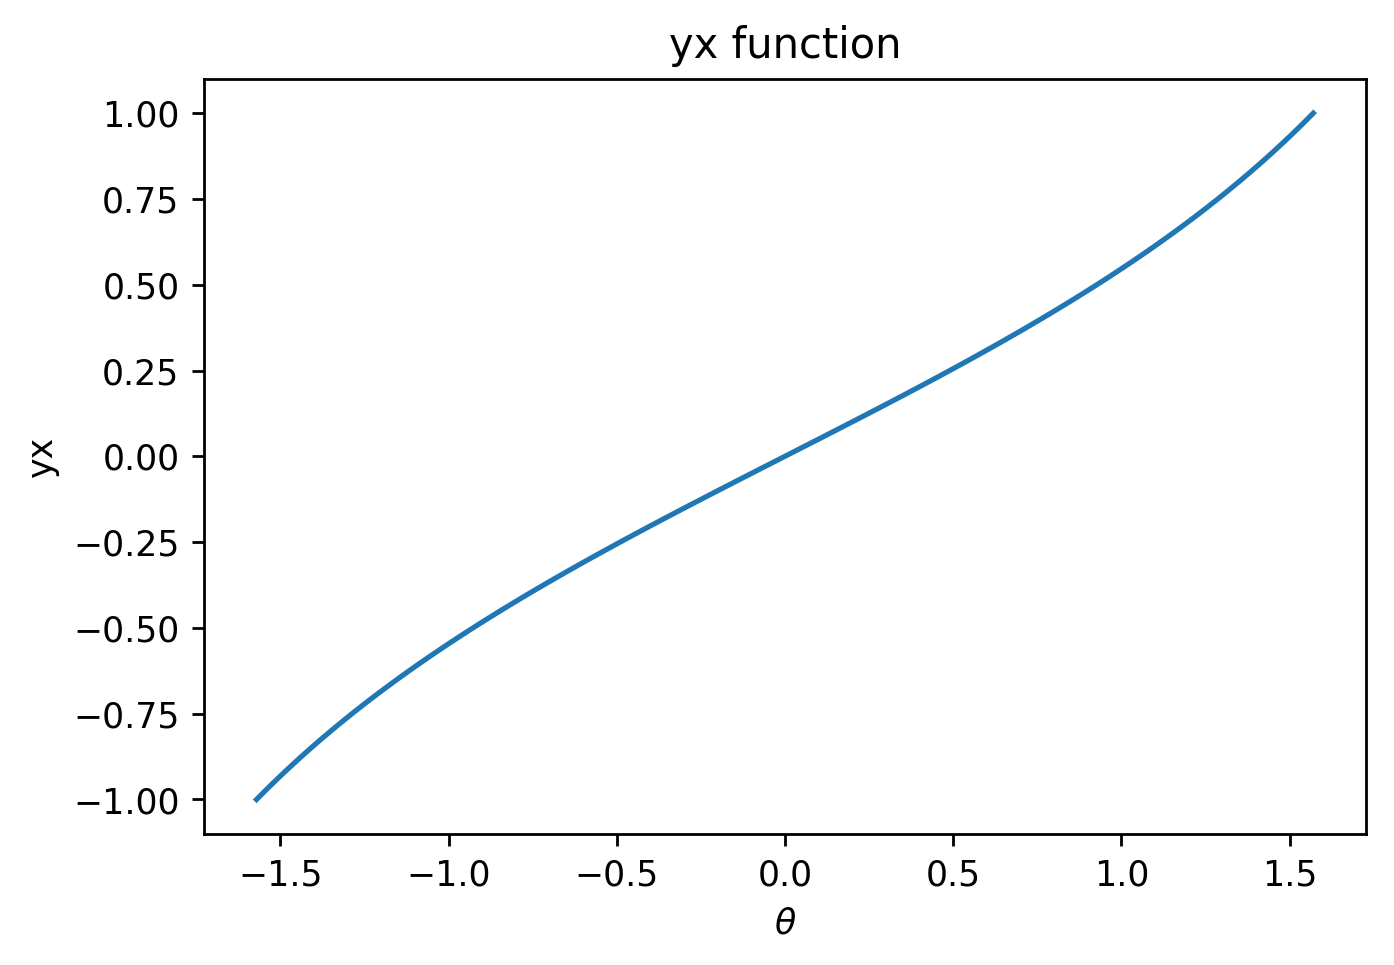

In [23]:
def yx(theta,offset=0):
    return np.where(theta==0,0,(1-np.cos(theta))/np.sin(theta))-offset

thetaRange=np.linspace(-np.pi/2,np.pi/2,100)
plt.figure()
plt.title('yx function')
plt.xlabel(r'$\theta$')
plt.ylabel('yx')
plt.plot(thetaRange,yx(thetaRange))

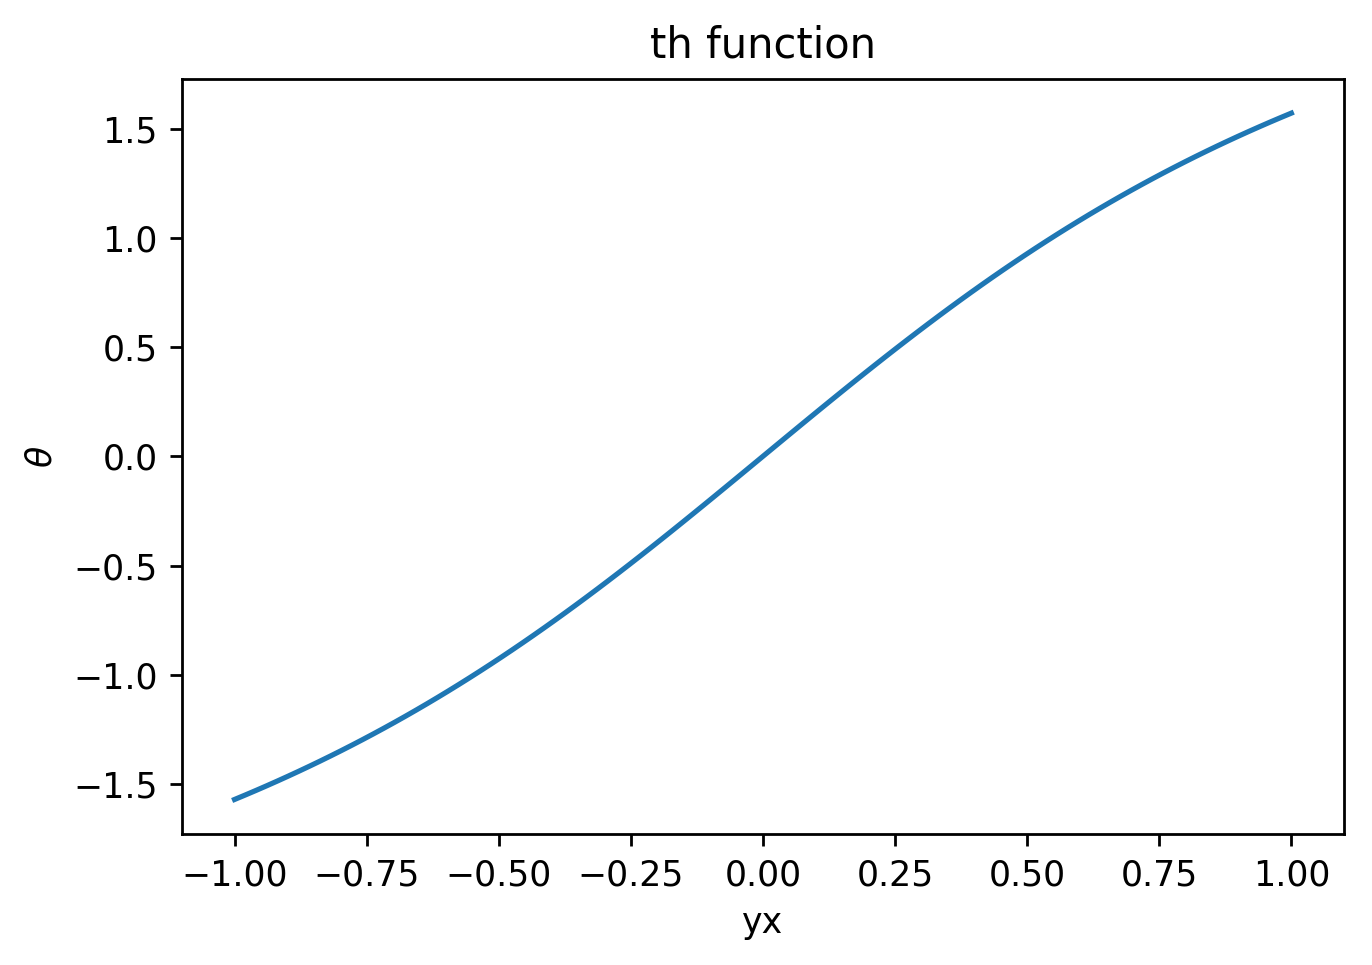

In [24]:
#now invert it
from scipy.optimize import fsolve
def th(x):
    offset=(x)
    guess=1.5*x
    return fsolve(yx,guess,args=offset)

yxRange=np.linspace(-1,1,100)
plt.figure()
plt.title('th function')
plt.ylabel(r'$\theta$')
plt.xlabel('yx')
plt.plot(yxRange,th(yxRange))
    

In [25]:
#test things out
yx(th(yxRange))-yxRange

array([ -3.57491814e-12,  -1.17269527e-11,  -1.60300662e-11,
        -1.38351552e-11,  -5.87008220e-12,   4.34163816e-12,
         1.23869803e-11,   1.50385260e-11,   1.15292220e-11,
         3.62554431e-12,  -5.32907052e-12,  -1.18478560e-11,
        -1.35976785e-11,  -1.01088027e-11,  -2.74946732e-12,
         5.91215965e-12,   1.30484512e-11,   1.64716019e-11,
         1.52208246e-11,   9.70823422e-12,   1.45516932e-12,
        -7.44115880e-12,  -1.49190660e-11,  -1.94597671e-11,
        -2.03800310e-11,  -1.78651538e-11,  -1.27889366e-11,
        -6.40298925e-12,   3.16413562e-15,   5.38286082e-12,
         9.09533560e-12,   1.09467990e-11,   1.11206599e-11,
         1.00453534e-11,   8.24262880e-12,   6.19870821e-12,
         4.28246327e-12,   2.71027645e-12,   1.55922497e-12,
         8.03135336e-13,   3.60822483e-13,   1.32838185e-13,
         3.33899575e-14,  -2.22044605e-16,  -7.02216063e-15,
        -4.98212582e-15,  -2.63677968e-15,  -1.54737334e-15,
        -4.44089210e-16,

In [26]:
# and now we can convert data from x-y to theta
n=500
y0=yout.x[1]
x0=out.x[1]
theta=th((y[:n]-y0)/(x[:n]-x0))



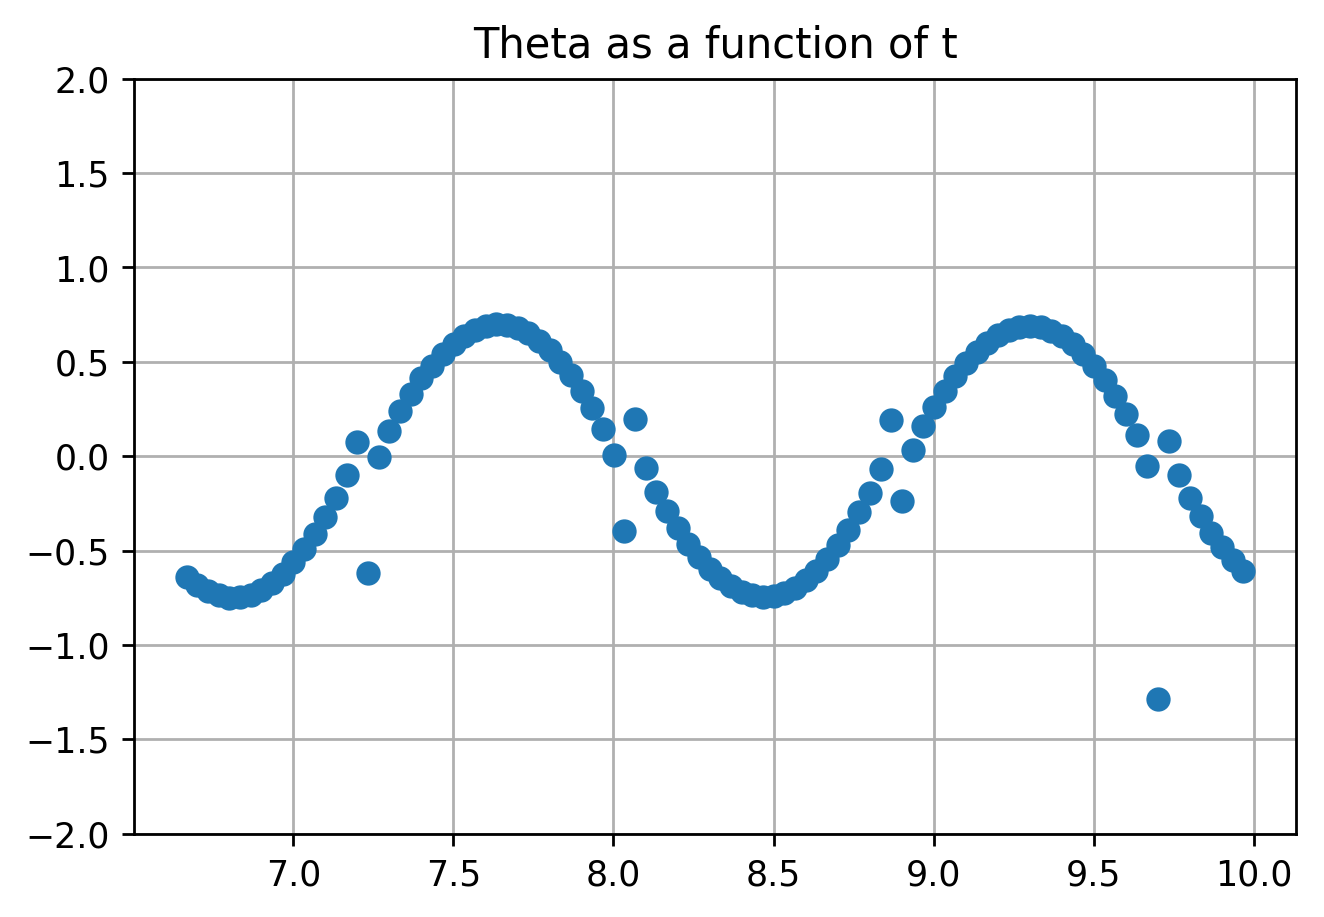

In [27]:
m=200
n=300
plt.figure()
plt.plot(t[m:n],theta[m:n],'o')
plt.title('Theta as a function of t')
plt.ylim(-2,2)
plt.grid()

In [28]:
print(np.where(abs(theta)>1))
for i in np.where(abs(theta)>1):
    print(i,theta[i],x[i]-x0,y[i]-y0)

(array([ 42,  92, 167, 291, 366, 440]),)
[ 42  92 167 291 366 440] [ -1.37902851   8.78395007  15.30544842  -1.28797671  -1.57004328
  -1.08632662] [-10.6587722    2.7117614    1.21123919  -9.89340723  -6.40201962
 -11.47539696] [ 8.78836882  8.17167581  5.93688059  7.42759024  6.39720044  6.92813027]


This takes a long time, so we will go back and do a Chebyshev polynomial interpolation for th

In [29]:
def ChebyshevCoefficients(func,a,b,n):
    '''Evaluate n chebyshev coefficients for func evaluated between a and b;  based on NR 5.8.7'''
    range=0.5*(b-a)  
    average=0.5*(b+a)
    x=range*np.cos((np.arange(0,n)+0.5)*np.pi/n)+average  #maps from -1 to 1 onto a-b
    v=func(x).reshape(1,n)  #row array of function values
    A=np.cos(np.pi/n*np.arange(0,n)*((np.arange(0,n)+0.5)).reshape(n,1))
    C=np.dot(v,A)*2/n 
    return C.reshape(-1)
    
    
def ChebEval(x,c,a,b):
    '''Evaluate a chebyshev series c(x), for the range a-b'''
    range=0.5*(b-a)
    average=0.5*(a+b)
    mapped=(x-average)/range
    return np.polynomial.chebyshev.chebval(mapped,c)-c[0]/2

    
chebyshevTheta=ChebyshevCoefficients(th,-1,1,50)
def ChebTheta(x):
    return np.polynomial.chebyshev.chebval(x,chebyshevTheta)-chebyshevTheta[0]/2

yxV1=(y-y0)/(x-x0)
yxV2=np.where(yxV1>1,1,yxV1)
yxValues=np.where(yxV2<-1,-1,yxV2)

#for uncertainties we will add fractional uncertainties in quadrature
thetaTh=th(yxValues[:100])
theta=ChebTheta(yxValues)
sigma=2.3*np.sqrt(1/(y-y0)**2+1/(x-x0)**2)*theta
theta[:100]-thetaTh #test the Chebyshev interpolation

array([  2.72140421e-10,   5.02936248e-10,   7.84280529e-10,
         1.03135889e-09,   1.21479393e-09,   1.29506761e-09,
         1.27182487e-09,   1.04073328e-09,   7.89515453e-10,
         5.06827025e-10,   2.61096478e-10,   1.02679643e-10,
         2.52156629e-11,   1.90197857e-12,  -1.01241238e-12,
        -2.96818126e-13,   5.91193761e-15,   7.20923321e-13,
        -9.10660436e-14,   1.31145095e-15,   3.31096262e-13,
         1.02112763e-12,  -7.18314297e-13,  -2.03588257e-11,
        -8.15798540e-11,  -1.97651562e-10,  -3.79106191e-10,
        -5.91793281e-10,  -7.97256039e-10,  -9.34800015e-10,
        -9.89975768e-10,  -9.38298217e-10,  -7.65810526e-10,
        -5.47349610e-10,  -3.36063732e-10,  -1.63625891e-10,
        -5.49319479e-11,  -1.06009090e-11,   4.41591208e-13,
         7.20423721e-13,   8.75133299e-14,   4.92314522e-15,
        -2.00025774e-10,   2.93098879e-14,  -1.98729921e-14,
        -4.46725990e-13,  -1.03922426e-12,   4.24427160e-12,
         3.56513707e-11,

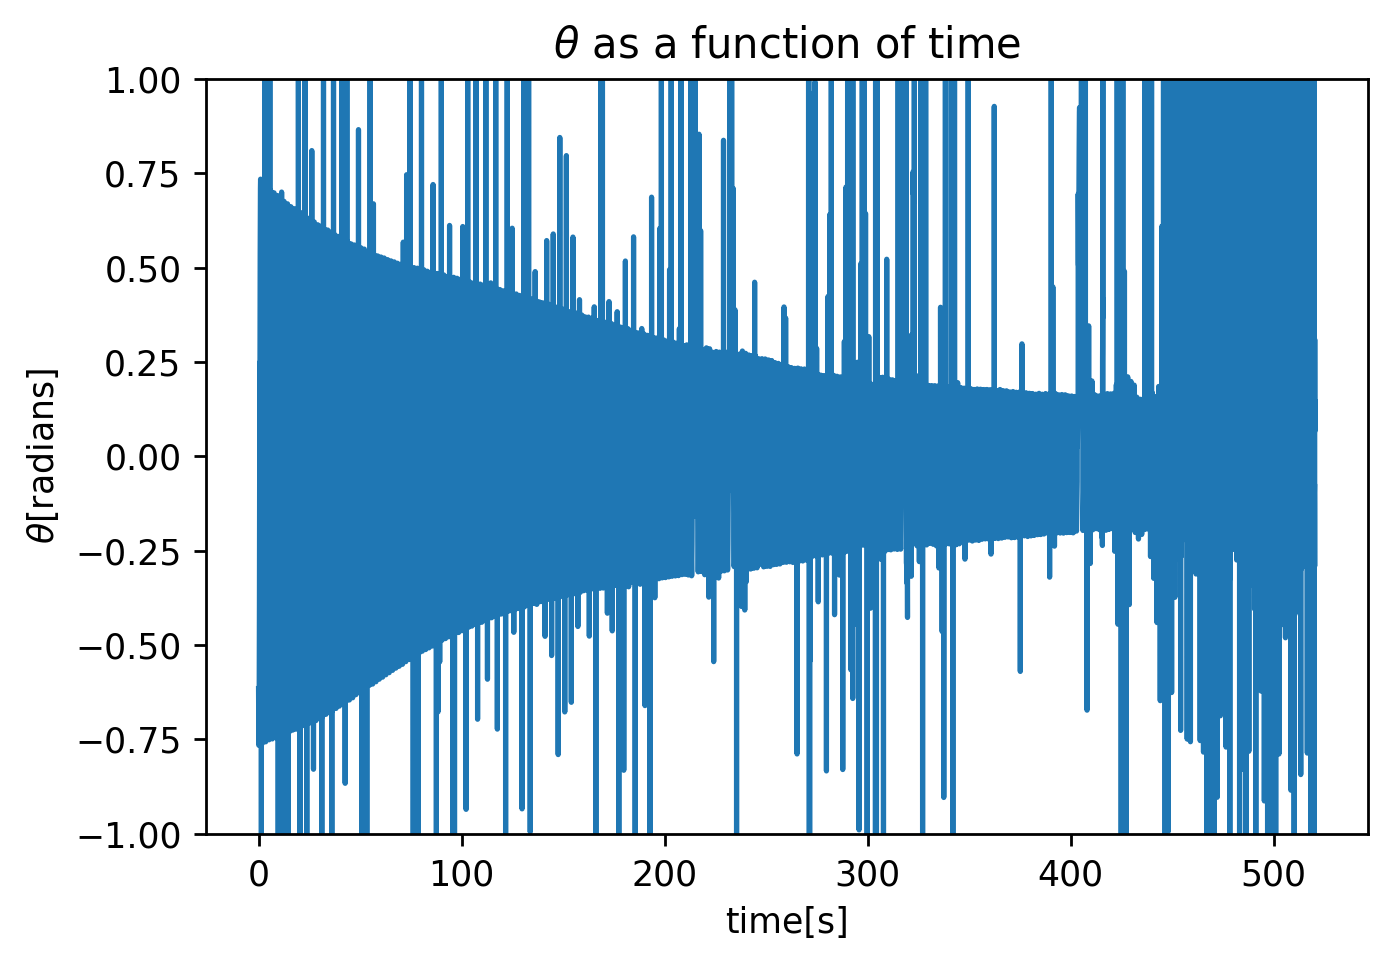

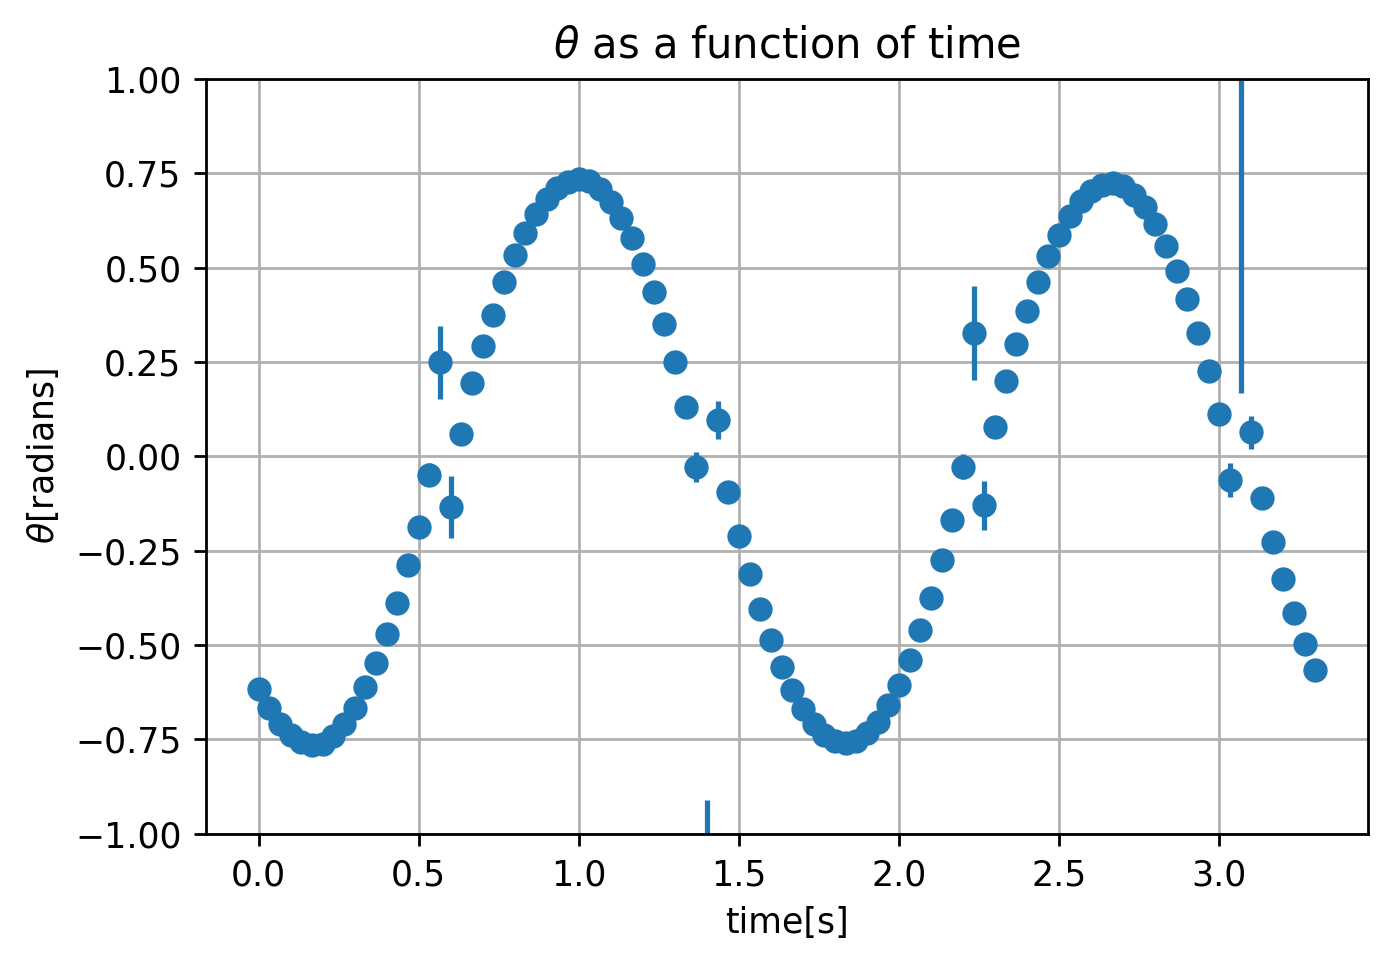

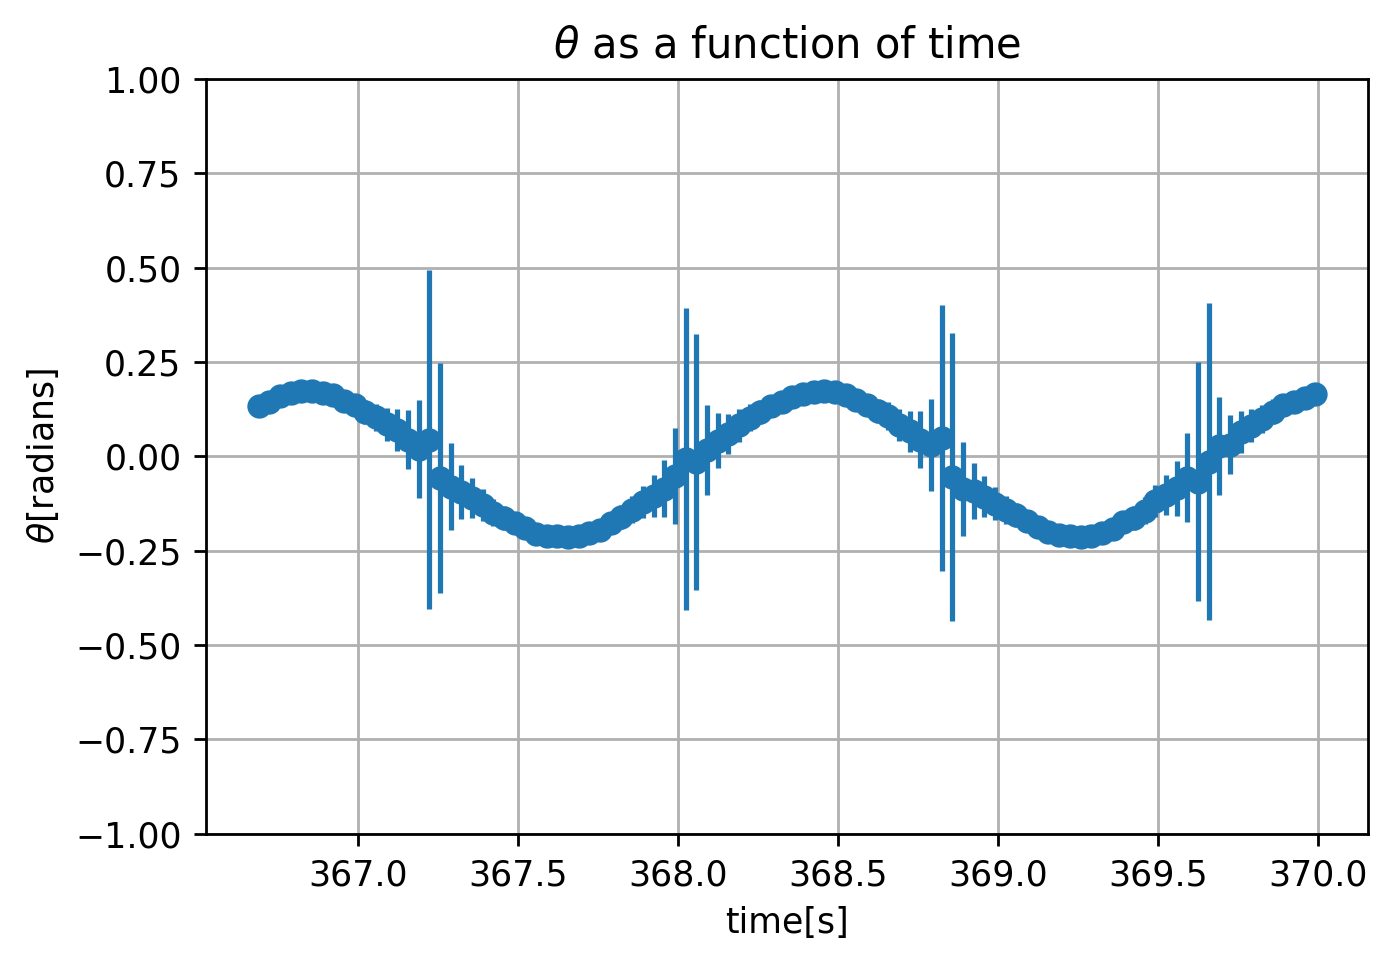

In [30]:
plt.figure()
plt.title(r'$\theta$ as a function of time')
plt.xlabel('time[s]')
plt.ylabel(r'$\theta$[radians]')
plt.ylim(-1,1)
plt.plot(t,theta)

m=0
n=100
plt.figure()
plt.title(r'$\theta$ as a function of time')
plt.xlabel('time[s]')
plt.ylabel(r'$\theta$[radians]')
#plt.plot(t[m:n],sigma[m:n],'osigma=')
plt.errorbar(t[m:n],theta[m:n],yerr=sigma[m:n],fmt='o')
plt.ylim(-1,1)
plt.grid()

m=11000
n=11100
plt.figure()
plt.title(r'$\theta$ as a function of time')
plt.xlabel('time[s]')
plt.ylabel(r'$\theta$[radians]')
#plt.plot(t[m:n],sigma[m:n],'osigma=')
plt.errorbar(t[m:n],theta[m:n],yerr=sigma[m:n],fmt='o')
plt.ylim(-1,1)
plt.grid()



What can we conclude from these plots?  What is the source of the systematic wiggle when the pendulum crosses zero?

Now we turn to fit the data.  We need to decide the coordinate system in which to fit.  We can fit in $\theta$, we can fit in $\frac{y-y_0}{x-x_0}$.  Originally I had thought to fit in $\theta$- it is straightforward (our pendulum function already calculates it), and it is immune to small z motion (since we calculate it from y/x).   However, it is clear that there is a dependence on $x_0,y_0$, and we obviously haven't determined thos well.  Fitting in x and y has the advantage that it is "closest" to the data- the general rule of thumb is that the model should calculate the data that you have and you compare it at the lowest level.  To do this we would need to incorporate z motion- since when we are closer to the camera the a pixel represents a larger distance than when we are far from the camera.  This could be significant.  

We are probably best off fitting (using as residuals):
\begin{equation}\frac{y(t_i)-y_0}{x(t_i)-x_0}-\rm{yx}\left(\theta(t_i;\theta_0,g,\alpha_{\rm{drag}})\right)\end{equation}

I was originally thinking we could have six fit parameters-$x_0, y_0$, the initial amplitude $\theta_0$, the time difference between calculation and data, $dt$, and we will allow the acceleration due to gravity and a factor on the overall drag calculation.  However, the initial amplitude and the time difference are dependent, so we will fix theta0 to a reasonable value, and allow dt to float.

Because it is expensive in computation time and changes things very little, we will leave out the compound pendulum, and just use the pendulum with drag.  

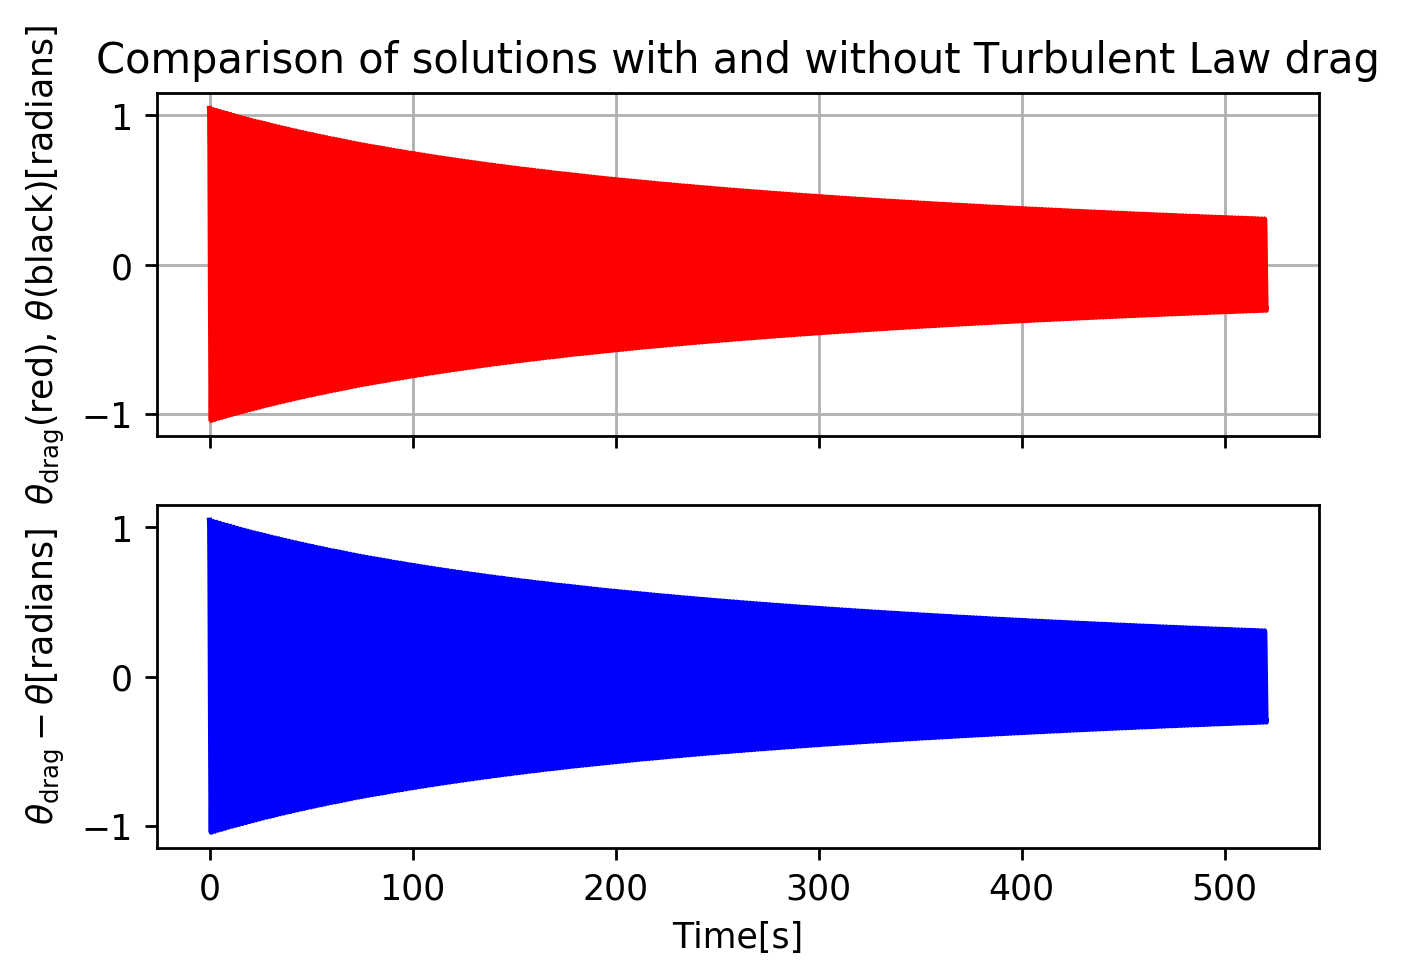

In [31]:
from scipy.integrate import odeint
from scipy.integrate import quadrature

#and now we set up some constants (measured quantities)
l=0.635 #length of pendulum, meters
g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
airViscosity=1.827e-5   #Pa-s  
mass=0.029 #kg  mass of pendulum bob
radius=0.00949 #m radius of pendulum bob
wireDiameter=0.00071 # m
b=6*np.pi*airViscosity*radius
airPressure=92.6 #kPa
standardAirDensity=1.225 # kg/m**3
standardAirPressure=101.325 #kPa
airDensity=airPressure/standardAirPressure*standardAirDensity
omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/3


def ReynoldsNumber(velocity):
    '''Calculates Reynolds number for a pendulum of length l and angular velocity omega.  Because it is used 
    in an logarithmic interpolation, we impose 1 as a lower cutoff'''
    R=airDensity*velocity*radius*2/airViscosity
    return np.maximum(R,1)

RN=np.array([1,4,10,40,100,400,1000,2000,4000,10000])
DC=np.array([24,8,4,1.7,1.1,0.6,0.45,0.4,0.35,0.35])
import scipy.interpolate
logRN=np.log(RN)  #interpolation in log ReynoldsNumber will be more sensible
splineInterpolation=scipy.interpolate.interp1d(logRN,DC,kind='cubic')

def DragCoefficientSpline(reynoldsNumber):
    return splineInterpolation(np.log(reynoldsNumber))

area=np.pi*radius**2
velocityAtR1=airViscosity/(2*airDensity*radius)
ceta= 6*np.pi*airViscosity*radius
ct=.5*airDensity*area
def fdrag(velocity):
    v=abs(velocity)
    if v<velocityAtR1:
        force=ceta*v
    else:
        force=ct*v**2*DragCoefficientSpline(ReynoldsNumber(v))
    return force
drag=np.vectorize(fdrag)  #so that drag can accept either a scalar or an array

wireData=np.array([20,1.88,50,1.57,100,1.39,200,1.25,500,1.10,1000,.972,2000,.876,5000,.972,10000,1.092,20000,1.164,50000,1.178,100000,1.164]).reshape(12,2)
logWireData=np.log(wireData[:,0])  #interpolation in log ReynoldsNumber will be more sensible
interpolation=scipy.interpolate.interp1d(logWireData,wireData[:,1],kind='cubic')
def DragWire(reynoldsNumber):
    return interpolation(np.log(reynoldsNumber))

v20=20*airViscosity/(wireDiameter*airDensity)
v20_Coefficient=DragWire(20)*airDensity*v20*wireDiameter/2
def dWireForce_Scalar(velocity):
    v=abs(velocity)  #we make all velocities positive for this calculation
    if(v<v20):
        dforce=v20_Coefficient*v
    else:
        reynoldsNumber=airDensity*v*wireDiameter/airViscosity
        dforce=DragWire(reynoldsNumber)*airDensity*v**2*wireDiameter/2  #units are N/m since we put dz=1
    return dforce

dWireForce=np.vectorize(dWireForce_Scalar)



def dTorque(rPrime,omega):
    '''Calculates the torque from an element of wire at rprime moving with angular velocity omega'''
    return rPrime*dWireForce(rPrime*omega)
vdTorque=np.vectorize(dTorque)

def wireTorque(anOmega):
    om=np.abs(anOmega)
    if(np.isscalar(om)):
        return quadrature(dTorque,0,l,args=omyy)
    else:
        retval=np.zeros_like(om)
        for i in np.arange(0,om.size):
            retval[i]=quadrature(vdTorque,0,l,args=om[i])[0]
        return retval
    
def ChebyshevCoefficients(func,a,b,n):
    '''Evaluate n chebyshev coefficients for func evaluated between a and b;  based on NR 5.8.7'''
    range=0.5*(b-a)  
    average=0.5*(b+a)
    x=range*np.cos((np.arange(0,n)+0.5)*np.pi/n)+average  #maps from -1 to 1 onto a-b
    v=func(x).reshape(1,n)  #row array of function values
    A=np.cos(np.pi/n*np.arange(0,n)*((np.arange(0,n)+0.5)).reshape(n,1))
    C=np.dot(v,A)*2/n 
    return C
    
    
def ChebEval(x,c,a,b):
    '''Evaluate a chebyshev series c(x), for the range a-b'''
    range=0.5*(b-a)
    average=0.5*(a+b)
    mapped=(x-average)/range
    return np.polynomial.chebyshev.chebval(mapped,c)-c[0]/2

omegaArray=np.linspace(0,10,500)
ChebyshevCoefficientsForWireTorque=ChebyshevCoefficients(wireTorque,omegaArray[0],omegaArray[-1],60).reshape(60,)

def wireTorqueCheb(x):
    return ChebEval(np.abs(x),ChebyshevCoefficientsForWireTorque[:10],omegaArray[0],omegaArray[-1])

def pendulumWithTurbulentDragAndString(y,t):
    theta, omega,energy = y
    dydt = np.array([omega, 
                     - g/l*np.sin(theta)-(drag(l*omega)/(mass*l)
                      +wireTorqueCheb(l*omega)/(mass*l**2))*np.sign(omega),
                     (drag(l*omega)*l+wireTorqueCheb(l*omega))*np.abs(omega)])
    return dydt
#use f0 for the initial conditions
f0 = np.array([theta_0, 0.0,0.0])
                     
dragSolutionWithTurbulenceAndString = odeint(pendulumWithTurbulentDragAndString, f0, t)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Comparison of solutions with and without Turbulent Law drag')
axarr[0].set_ylabel(r'$\theta_{\rm{drag}}$(red), $\theta$(black)[radians]')
#axarr[0].plot(t, solrk[:, 0], 'k', label='rk omega(t)')
axarr[0].plot(t, dragSolutionWithTurbulenceAndString[:, 0], 'r', label='rk theta(t)')
axarr[0].grid()
axarr[1].set_xlabel('Time[s]')
axarr[1].set_ylabel(r'$\theta_{\rm{drag}}-\theta \rm{[radians]}$')
axarr[1].plot(t,dragSolutionWithTurbulenceAndString[:,0], 'b');



In [52]:
t2=t[0:100]
neval=0
def pendulum(y,t,*pargs):
    theta, omega= y
    g,alpha=pargs
    global neval
    neval=neval+1
    if(neval<10):
        print(neval,theta,omega)

    dydt = np.array([omega, 
                     - g/l*np.sin(theta)-(alpha*drag(l*omega)/(mass*l)
                      +alpha*wireTorqueCheb(l*omega)/(mass*l**2))*np.sign(omega)])
    return dydt

def yxResiduals(parameters,*args):
    global sol # so we can plot out the solution
    global yxData
    global sigma
    t,x,y=args
    x0,y0,dt,theta0,g,alpha=parameters
#    theta0=0.74  #by looking at the data
    print('x0 %f y0 %f dt %g theta0 %g g %g alpha %g'%(x0,y0,dt,theta0,g,alpha))
    f0 = np.array([theta0, 0.0])
    tprime=np.linspace(0,dt,2)
    pargs=(g,alpha)
    global neval
    neval=0
    sol0=odeint(pendulum,f0,tprime,args=pargs) #integrate from 0 to dt                  
    sol = odeint(pendulum, sol0[-1], t,args=pargs)
    print('neval=',neval)
    delx=x-x0
    yxData=np.where(delx==0,0,(y-y0)/delx)
    sigma=2.3*np.sqrt(1/(y-y0)**2+1/delx**2)*yxData
    print(sol[:,0].shape)
    return (yxData-yx(sol[:,0]))/sigma


m=0
n=1000
fitParameters=np.array([x0,y0,0.6,0.7,9.8,1.0])
args=(t[m:n],x[m:n],y[m:n])
pendout=least_squares(yxResiduals,fitParameters,method='lm',args=args)
print(pendout)



x0 1032.993772 y0 640.274965 dt 0.6 theta0 0.7 g 9.8 alpha 1
1 0.7 0.0
2 0.7 -0.000120390620464
3 0.699999998542 -0.000120390646217
4 0.699999997084 -0.000240781292017
5 0.699999995627 -0.000240781288999
6 0.699999831613 -0.00182189429428
7 0.699999831613 -0.00182189417525
8 0.699999416156 -0.00340300626726
9 0.699999416157 -0.00340300602729
neval= 4168
(1000,)
x0 1032.993772 y0 640.274965 dt 0.6 theta0 0.7 g 9.8 alpha 1
1 0.7 0.0
2 0.7 -0.000120390620464
3 0.699999998542 -0.000120390646217
4 0.699999997084 -0.000240781292017
5 0.699999995627 -0.000240781288999
6 0.699999831613 -0.00182189429428
7 0.699999831613 -0.00182189417525
8 0.699999416156 -0.00340300626726
9 0.699999416157 -0.00340300602729
neval= 4168
(1000,)
x0 1032.993772 y0 640.274965 dt 0.6 theta0 0.7 g 9.8 alpha 1
1 0.7 0.0
2 0.7 -0.000120390620464
3 0.699999998542 -0.000120390646217
4 0.699999997084 -0.000240781292017
5 0.699999995627 -0.000240781288999
6 0.699999831613 -0.00182189429428
7 0.699999831613 -0.0018218941752

9 0.704163376059 -0.00340786505698
neval= 4222
(1000,)
x0 1030.399146 y0 641.541995 dt 0.600623 theta0 0.704164 g 9.74865 alpha 0.995143
1 0.70416396176 0.0
2 0.70416396176 -0.000120392946327
3 0.704163960302 -0.000120392971963
4 0.704163958844 -0.000240785943513
5 0.704163957385 -0.00024078594051
6 0.704163792872 -0.00182432613355
7 0.704163792872 -0.00182432601493
8 0.704163376059 -0.00340786529699
9 0.704163376059 -0.00340786505786
neval= 4262
(1000,)
x0 1030.399146 y0 641.541995 dt 0.600623 theta0 0.704164 g 9.74865 alpha 0.995143
1 0.704163972253 0.0
2 0.704163972253 -0.000120392946319
3 0.704163970795 -0.000120392971955
4 0.704163969337 -0.000240785943496
5 0.704163967878 -0.000240785940493
6 0.704163803365 -0.00182432613916
7 0.704163803365 -0.00182432602055
8 0.704163386552 -0.00340786530824
9 0.704163386552 -0.00340786506911
neval= 4226
(1000,)
x0 1030.399146 y0 641.541995 dt 0.600623 theta0 0.704164 g 9.74865 alpha 0.995143
1 0.70416396176 0.0
2 0.70416396176 -0.0001203929463

neval= 4232
(1000,)
x0 1019.701655 y0 638.491667 dt 0.611764 theta0 0.703003 g 9.74921 alpha 0.983608
1 0.703003228606 0.0
2 0.703003228606 -0.000120448128818
3 0.703003227145 -0.000120448154201
4 0.703003225683 -0.000240896307986
5 0.703003224221 -0.000240896305008
6 0.703003058388 -0.00183033622166
7 0.703003058388 -0.00183033610128
8 0.703002638039 -0.00341977510224
9 0.703002638039 -0.00341977485961
neval= 4280
(1000,)
x0 1019.701655 y0 638.491667 dt 0.611764 theta0 0.703003 g 9.74921 alpha 0.983608
1 0.703003239082 0.0
2 0.703003239082 -0.00012044812881
3 0.70300323762 -0.000120448154192
4 0.703003236159 -0.000240896307969
5 0.703003234697 -0.000240896304991
6 0.703003068864 -0.00183033622761
7 0.703003068864 -0.00183033610723
8 0.703002648514 -0.00341977511416
9 0.703002648514 -0.00341977487154
neval= 4192
(1000,)
x0 1019.701655 y0 638.491667 dt 0.611764 theta0 0.703003 g 9.74921 alpha 0.983608
1 0.703003228606 0.0
2 0.703003228606 -0.000120448128818
3 0.703003227145 -0.000120448

neval= 4286
(1000,)
x0 1015.231797 y0 639.079212 dt 0.619724 theta0 0.702229 g 9.73385 alpha 0.977712
1 0.702229220991 0.0
2 0.702229220991 -0.000120480992691
3 0.702229219525 -0.00012048101799
4 0.702229218059 -0.000240962035563
5 0.702229216593 -0.000240962032592
6 0.702229049943 -0.00183252671159
7 0.702229049943 -0.00183252659024
8 0.702228627459 -0.00342409035054
9 0.702228627459 -0.00342409010599
neval= 4280
(1000,)
x0 1015.231797 y0 639.079212 dt 0.619724 theta0 0.702229 g 9.73385 alpha 0.977712
1 0.702229231455 0.0
2 0.702229231455 -0.000120480992683
3 0.702229229989 -0.000120481017982
4 0.702229228523 -0.000240962035547
5 0.702229227057 -0.000240962032576
6 0.702229060407 -0.00183252671885
7 0.702229060407 -0.0018325265975
8 0.702228637923 -0.00342409036507
9 0.702228637923 -0.00342409012052
neval= 4236
(1000,)
x0 1015.231797 y0 639.079212 dt 0.619724 theta0 0.702229 g 9.73386 alpha 0.977712
1 0.702229220991 0.0
2 0.702229220991 -0.000120480992691
3 0.702229219525 -0.000120481

7 0.70223658984 -0.00183315982231
8 0.702236167046 -0.00342534965342
9 0.702236167046 -0.00342534940859
neval= 4268
(1000,)
x0 1015.231795 y0 639.079212 dt 0.620438 theta0 0.702255 g 9.73396 alpha 0.976636
1 0.702254577188 0.0
2 0.702254577188 -0.000120484701658
3 0.702254575722 -0.000120484726929
4 0.702254574256 -0.00024096945344
5 0.70225457279 -0.000240969450472
6 0.702254406028 -0.00183316833253
7 0.702254406028 -0.00183316821104
8 0.702253983239 -0.00342536617411
9 0.702253983239 -0.00342536592929
neval= 4270
(1000,)
x0 1015.231795 y0 639.079212 dt 0.620448 theta0 0.702268 g 9.73396 alpha 0.976642
1 0.702267882856 0.0
2 0.702267882856 -0.00012048479999
3 0.70226788139 -0.000120484825261
4 0.702267879924 -0.000240969650104
5 0.702267878458 -0.000240969647136
6 0.702267711697 -0.00183317465819
7 0.702267711697 -0.00183317453671
8 0.702267288912 -0.0034253786288
9 0.702267288912 -0.00342537838399
neval= 4202
(1000,)
x0 1015.225647 y0 639.079212 dt 0.620448 theta0 0.702268 g 9.73396 

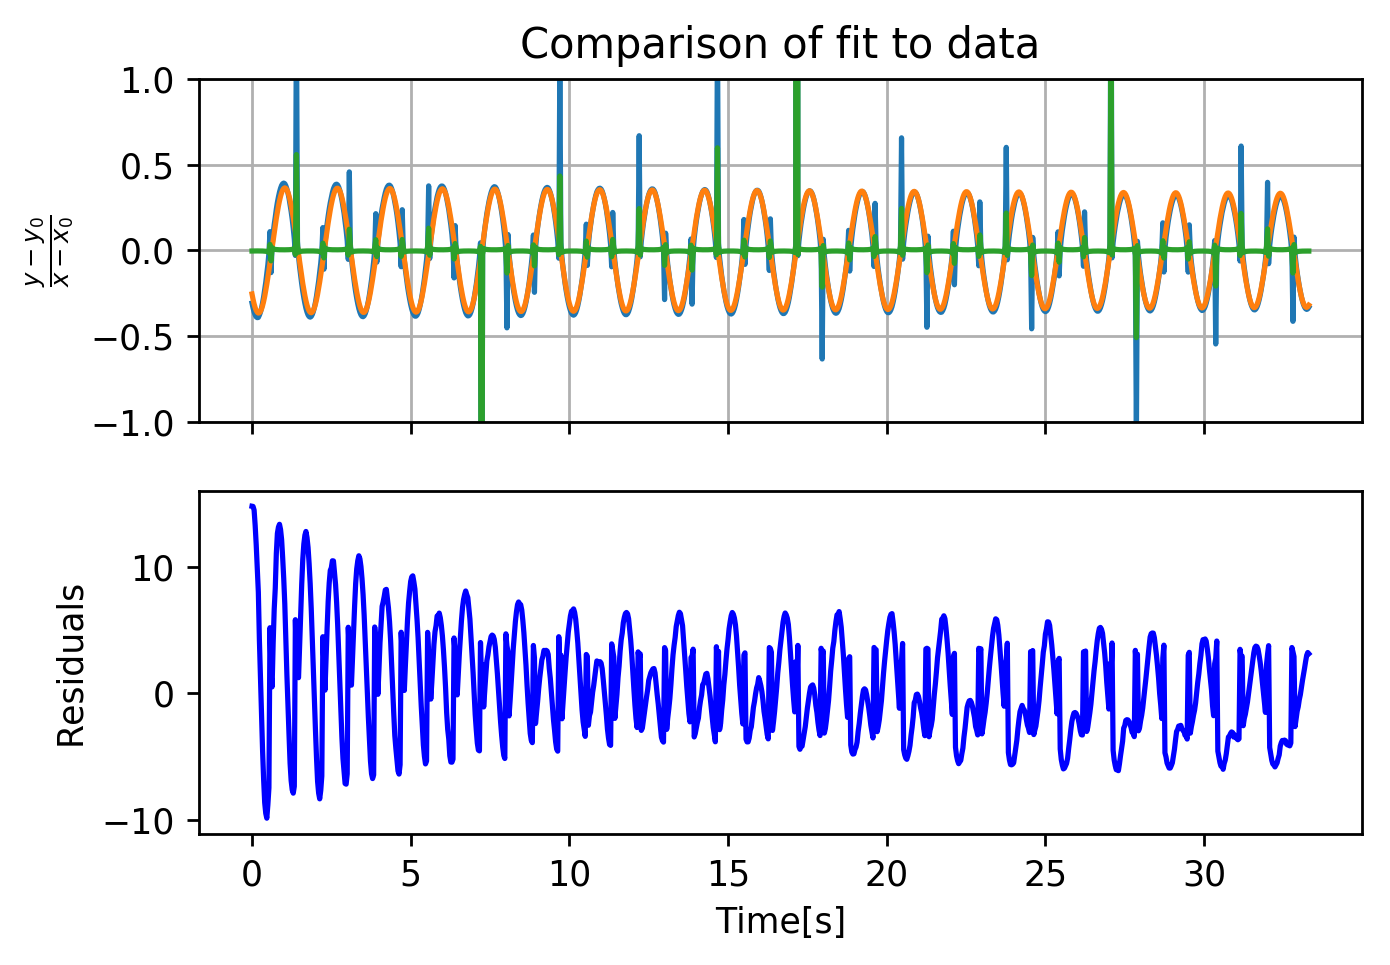

In [54]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Comparison of fit to data')
axarr[0].set_ylabel(r'$\frac{y-y_0}{x-x_0}$')
axarr[0].plot(t[m:n],yxData[m:n])
axarr[0].plot(t[m:n],yx(sol[m:n,0]))
axarr[0].plot(t[m:n],sigma[m:n])
axarr[0].set_ylim(-1,1)
axarr[0].grid()
axarr[1].set_xlabel('Time[s]')
axarr[1].set_ylabel(r'Residuals')
axarr[1].plot(t[m:n],pendout.fun, 'b');



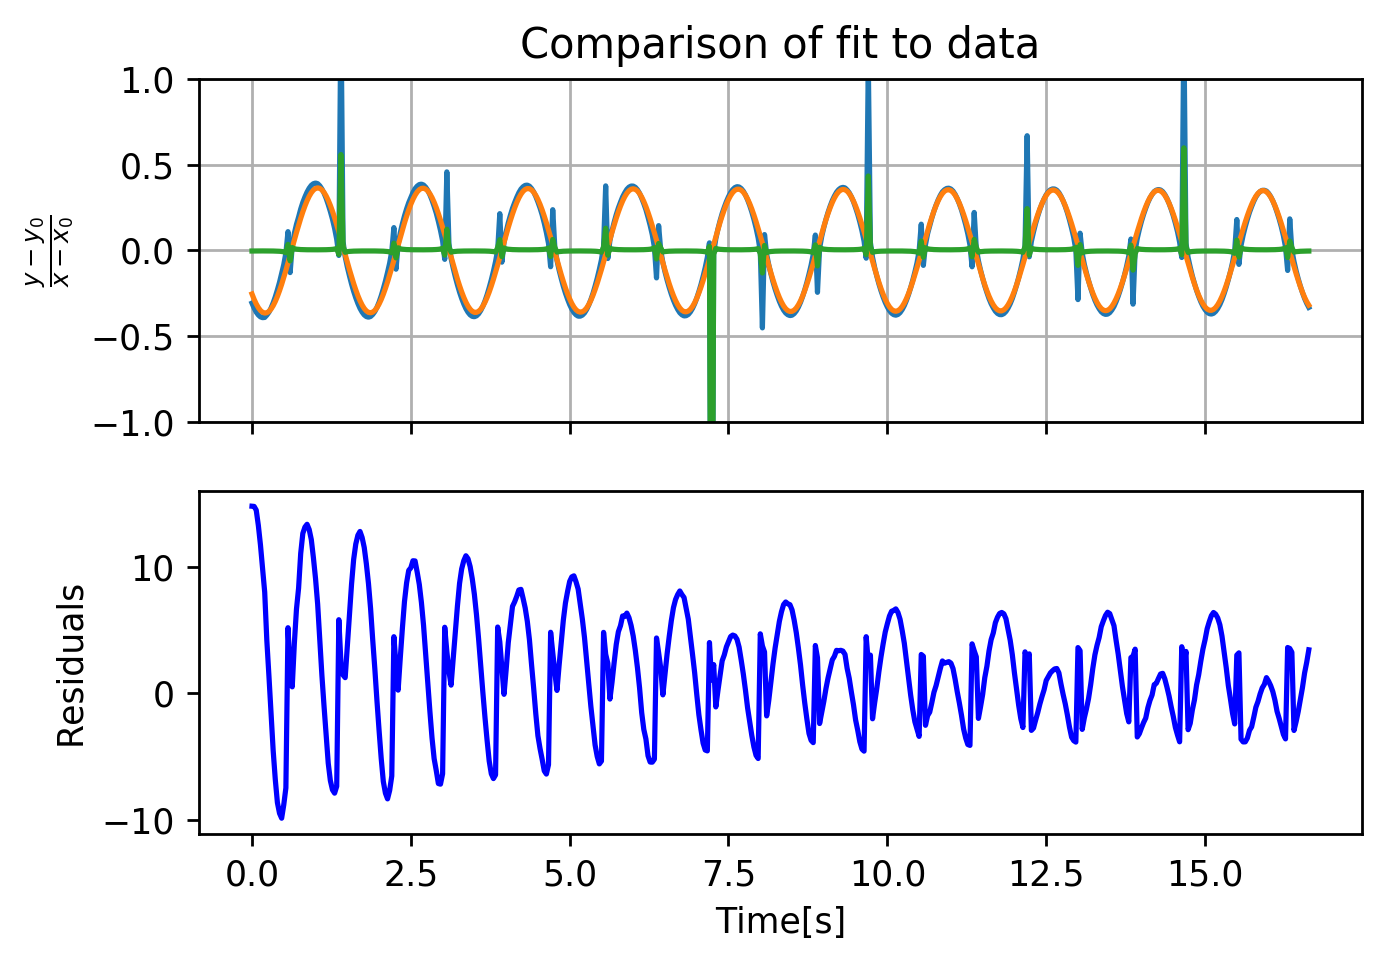

In [55]:
#zoom in a smaller range
n=500
f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Comparison of fit to data')
axarr[0].set_ylabel(r'$\frac{y-y_0}{x-x_0}$')
axarr[0].plot(t[m:n],yxData[m:n])
axarr[0].plot(t[m:n],yx(sol[m:n,0]))
axarr[0].plot(t[m:n],sigma[m:n])
axarr[0].set_ylim(-1,1)
axarr[0].grid()
axarr[1].set_xlabel('Time[s]')
axarr[1].set_ylabel(r'Residuals')
axarr[1].plot(t[m:n],pendout.fun[0:n-m], 'b');


We are seeing some sort of beat between the data and fit.  Perhaps the oscillations?  THe other possibility might be z oscillations.  
Now let's look at the derived quantities.



In [56]:
pendhessian=pendout.jac.transpose().dot(pendout.jac)
pendalpha=2*pendhessian  #since we want the hessian of chisquare, and the fitter used the hessian of the cost function=1/2 chisquare
pendC=np.linalg.inv(pendalpha)
pendunc=np.sqrt(np.diagonal(pendC))

for i in range(0,6):
    print('%f %f'%(pendout.x[i],pendunc[i]))


1015.231795 0.213931
639.079212 0.092327
0.620448 0.000323
0.702268 0.000507
9.733959 0.000719
0.976642 0.011083


Our results: $\chi^2=450000$ for 4000 degrees of freedom, so we don't have a good fit.  If we attribute this to, say, angular momentum compound pendulum oscillations that we haven't taken into account in the fit, then we would say that we have underestimated our uncertainties by a factor of 10.  We can't always do this- there needs to be real systematic that we understand, but in this case we are probably fine.  Rather than scale our intrinsic uncertainty by 10, we will simply scale the uncertainties returned from the fit by 10.

The fit returns an acceleration due to gravity of $9.800\pm0.004$, and an amazingly good factor for air resistance of $1.000\pm0.018$.  Notice that if we cut down the fit range we change things- a fit with 1000 data points gives 9.734 and alpha .977; we can argue that the longer data range gives a better fit but, to be conservative we add a systematic uncertainty from the subjective choice of a fit range of 0.07. 

We also have a correction for the fact that we have ignored the compound pendulum.  From the calculation we saw that the compound pendulum has a period that is 0.7 radians/152 radians slower than a simple pendulum.  We fit our data with the assumption of a simple pendulum- whereas the data is the data for a compount pendulum.  Thus the data correspond to a slower pendulum - ie. a smaller gravitational constant.  This correction is 2x0.7/152*9.8=0.09 m**2/s, at an amplitude of 0.7, and decreases as the pendulum slows down.

What other corrections are needed?

What are our other uncertainties?  The length is uncertain by 1 mm/635, which translates to an error in g of 0.015, and our statistical uncertainty from the fit is 0.004

Our number, based on these measurements is $9.89 \pm 0.07$.  Instead of correcting, we compare it to a m measurement on the UofA campus (https://sites.ualberta.ca/~unsworth/UA-classes/210/notes210/B/210B4-2008.pdf) which found 9.8117 (then we don't need to make any of the other corrections.  

In [4]:
1/635*9.8
0.29/39.35*2*9.8

0.14444726810673444